## **Machine Learning and Partial differential equations**. 

A type of machine learning called Physics-Informed Neural Networks (PINNs) represent a novel approach to solving partial differential equations (PDEs) by incorporating the physical laws described by the equations into the loss function of the neural network. Unlike traditional numerical methods, PINNs do not require a discretization to solve PDEs and can work with scattered data, making them highly flexible. This tutorial demonstrates the implementation of PINNs to solve the diffusion equation, followed by an in depth project where we solve the Black-Scholes equation. These codes have been develop by Fredrik Nysæeter, Oskar Fausko and Kristian Liodden

**Requirements**

* Pytorch (see https://pytorch.org/ for intallation on your system)
* NumPy
* Matplotlib
* Scipy 


#### The diffusion equation

To get a feeling of what PINNs is about we start with a PDE many of us are familiar with, the diffusion equation.


The one-dimensional diffusion equation is given by:

$$
\frac{\partial u(x,t)}{\partial t} = D \frac{\partial^2 u(x,t)}{\partial x^2}
$$

Where:

- $u(x, t)$ is the scalar field (e.g., temperature or concentration)
- $x$ is the spatial coordinate
- $t$ is time
- $D$ is the **diffusion coefficient** 




We will now look at the case of the distribution of heat over a one-dimensional rod of length $L$. The diffusion equation is then given by: 


$$
\frac{\partial u(x,t)}{\partial t} = \frac{\partial^2 u(x,t)}{\partial x^2}, \hspace{2cm}   t > 0, x \in [0,L]
$$


The initial condition at $t = 0$ is given by 

$$
u(x,0) = \sin(\pi x) \hspace{1cm} 0 < x < L
$$

The boundary conditions are given by 

$$
u(t,0) = 0  \hspace{2cm} t \geq 0
$$

$$
u(t,L) = 0 \hspace{2cm} t \geq 0
$$

#### Setting up the Neural network 

We import the necessary packages and define a neural network class, PINN, that inherits from torch.nn.Module. The network architecture is defined as a fully-connected neural network with an input layer, several hidden layers with a SiLU activation function. The weights are initialized using the Xavier uniform initialization method.

The forward method in the PINN class defines the forward pass of the neural network, which computes the output given the input.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn

In [2]:
class PINN(nn.Module):
    """
    A Physics-Informed Neural Network (PINN) module for solving the diffusion equation.
    """
    def __init__(self, num_inputs, num_layers, num_neurons, device):
        """
        Initialize the PINN model.

        Parameters:
        num_inputs (int): Number of input features.
        num_layers (int): Number of hidden layers.
        num_neurons (int): Number of neurons in each hidden layer.
        device (torch.device): The device on which to perform computations.
        """
        super(PINN, self).__init__()
        self.device = device
        num_layers = num_layers
        num_neurons = num_neurons
        activation = nn.SiLU()

        layers = [nn.Linear(num_inputs, num_neurons), activation] # Input layer
        for _ in range(num_layers ):
            layers += [nn.Linear(num_neurons, num_neurons), activation] # Hidden layers
        layers += [nn.Linear(num_neurons, 1)] # Output layer

        self.model = nn.Sequential(*layers).to(device) #Create the model by stacking the layers sequentially and move to device
        # Initialize weights using Xavier uniform initialization and biases to zero
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_normal_(layer.weight)
                torch.nn.init.zeros_(layer.bias)

    def forward(self, x):
            """
            Perform a forward pass of the PINN model.

            Parameters:
            x (torch.Tensor): The input tensor containing the spatial and temporal coordinates.

            Returns:
            torch.Tensor: The output of the neural network, representing the solution u(x, t) of the PDE at input points.
            """
            return self.model(x)

## Loss Function

In Physics-Informed Neural Networks, the loss function is a composite of the mean squared errors of the residuals from the governing Partial Differential Equation (PDE) and the initial and boundary conditions (IC/BC). The overall loss function $L_{\text{total}}$ is expressed as:

- **PDE Loss**: The PDE loss, $L_{\text{PDE}}$, is based on the PDE residual, $R_{\text{PDE}}$, which is the discrepancy between the predicted temporal derivative $u_t$ and the second spatial derivative $u_{xx}$:

  $$
  L_{\text{PDE}} = \frac{1}{N_{\text{pde}}} \sum_{i=1}^{N_{\text{pde}}} \left( R_{\text{PDE}}(x_i, t_i) \right)^2 = \frac{1}{N_{\text{pde}}} \sum_{i=1}^{N_{\text{pde}}} \left( u_t(x_i, t_i) - u_{xx}(x_i, t_i) \right)^2
  $$

- **Initial Condition Loss**: The initial condition loss $L_{\text{IC}}$ comes from the residual $R_{\text{IC}}$ at $ t = 0 $:

  $$
  L_{\text{IC}} = \frac{1}{N_{\text{ic}}} \sum_{i=1}^{N_{\text{ic}}} \left( R_{\text{IC}}(x_i) \right)^2 = \frac{1}{N_{\text{ic}}} \sum_{i=1}^{N_{\text{ic}}} \left( u(x_i, 0) - \sin(\pi x_i) \right)^2
  $$

- **Boundary Condition Loss**: The losses for the left $L_{\text{BC}_{\text{left}}}$ and right $\mathcal{L}_{\text{BC}_{\text{right}}}$ boundary conditions are based on the residuals $R_{\text{BC}_{\text{left}}}$ and $R_{\text{BC}_{\text{right}}}$ at $ x = 0 $ and $ x = L$, respectively:

  $$
  L_{\text{BC}_{\text{left}}} = \frac{1}{N_{\text{bc}}} \sum_{i=1}^{N_{\text{bc}}} \left( R_{\text{BC}_{\text{left}}}(t_i) \right)^2 = \frac{1}{N_{\text{bc}}} \sum_{i=1}^{N_{\text{bc}}} \left( u(0, t_i) \right)^2
  $$

  $$
  L_{\text{BC}_{\text{right}}} = \frac{1}{N_{\text{bc}}} \sum_{i=1}^{N_{\text{bc}}} \left( R_{\text{BC}_{\text{right}}}(t_i) \right)^2 = \frac{1}{N_{\text{bc}}} \sum_{i=1}^{N_{\text{bc}}} \left( u(L, t_i) \right)^2
  $$

- **Total Loss**: The total loss is simply the sum of the individual components:

  $$
  L_{\text{total}} = L_{\text{PDE}} + L_{\text{IC}} + L_{\text{BC}_{\text{left}}} + L_{\text{BC}_{\text{right}}}
$$

The training objective is to minimize $\mathcal{L}_{\text{total}}$, prompting the network to learn an approximation to the PDE's solution that adheres to the given initial and boundary conditions.

**PDE loss term**

To enforce the diffusion equation as a constraint in the neural network, we need to compute the temporal and spacial derivatives of the networks outputs. torch.autograd enables the computation of these derivatives efficiently.

In [3]:
def pde( x, model):
    """
    Calculate the residual of the diffusion equation for use in the loss function.

    This function computes the residual of the one-dimensional diffusion equation. 

    

    Parameters:
    x (torch.Tensor): The input tensor containing spatial and temporal coordinates.
                      The first column should be the spatial coordinate and the second
                      column the temporal coordinate.
    model (torch.nn.Module): The neural network model used for prediction. 

    Returns:
    torch.Tensor: The residual of the diffusion equation.
    """
    x_space = x[:, 0:1] #Spacial coordinates
    x_time = x[:, 1:2] #Temporal coordinates

    # Enable gradient tracking for x_space and x_time
    x_space.requires_grad_(True)
    x_time.requires_grad_(True)

    # Predict the function u using the model
    u = model(torch.cat((x_space, x_time), dim=1))

    # Compute the first spatial derivative of u
    u_x = torch.autograd.grad(
        u, x_space, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    
    # Compute the second spatial derivative of u
    u_xx = torch.autograd.grad(
        u_x, x_space, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    
    # Compute the temporal derivative of u
    u_t = torch.autograd.grad(
        u, x_time, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    
    return u_t - u_xx

**IC and BC**

Next we set up the initial and boundary conditions. Note that we implement these as "soft" constraints (as loss terms), in contrast to the "hard" constraints discussed in the FYS-STK3155/4155 material, where boudary and initial conditions are imposed in a trial function.

In [4]:
def IC( x,model):
    """
    Calculate the loss for the initial condition.

    This function computes the difference between the model's prediction and the expected 
    value of the solution at the initial time (t = 0). In this case, the expected value is u(x, 0) = sin(pi*x).

    Parameters:
    x (torch.Tensor): The input tensor containing the spatial and time coordinates.
    model (torch.nn.Module): The neural network model used for prediction.
    
    Returns:
    torch.Tensor: The loss for the initial condition.
    """
    u0 = model(x)

    return u0-torch.sin(np.pi*x[:, 0:1])

def BC_left(x, model):
    """
    Calculate the loss for the left boundary condition.

    This function computes the difference between the model's prediction and the expected 
    value of the solution at the left boundary (x = 0). In this case, the expected value is u(0,t)=0.

    Parameters:
    x (torch.Tensor): The input tensor containing the spatial and time coordinates.
    model (torch.nn.Module): The neural network model used for prediction.

    Returns:
    torch.Tensor: The loss for the left boundary condition.
    """
    u_left = model(x)

    return u_left

def BC_right(x, model):
    """
    Calculate the loss for the right boundary condition.

    This function computes the difference between the model's prediction and the expected 
    value of the solution at the right boundary (x = L). In this case, the expected value is u(L,t)=0.

    Parameters:
    x (torch.Tensor): The input tensor containing the spatial and time coordinates.
    model (torch.nn.Module): The neural network model used for prediction.

    Returns:
    torch.Tensor: The loss for the right boundary condition.
    """
    u_right = model(x)
    return u_right

**Training step**

Before computing the loss,backpropagating and updating the parameters, we reset the gradients accumulated in the optimizer by calling optimizer.zero_grad. This is a standard step in training neural networks with pytorch, as gradients are accumulated by default.

In [5]:
def train_step( X_left, X_right, X_collocation, X_ic, optimizer, model):
    """
    Perform a single training step.

    This function performs a single training step of the PINN model. It calculates the loss and its gradients, 
    
    Parameters: 
    X_left (torch.Tensor): The input tensor containing the spatial and time coordinates of the left boundary.
    X_right (torch.Tensor): The input tensor containing the spatial and time coordinates of the right boundary.
    X_collocation (torch.Tensor): The input tensor containing the spatial and time coordinates of the collocation points.
    X_ic (torch.Tensor): The input tensor containing the spatial and time coordinates of the initial condition.
    optimizer (torch.optim.Optimizer): The optimizer used for gradient descent.
    model (torch.nn.Module): The neural network model used for prediction.
    
    Returns:
    torch.Tensor: The loss for the PDE, the loss for the initial condition, the loss for the left boundary condition,
                  the loss for the right boundary condition, and the total loss.
                  
    """
    optimizer.zero_grad() # Reset gradients

    IC_loss = torch.mean(torch.square(IC(X_ic,model)))
    BC_left_loss = torch.mean(torch.square(BC_left(X_left,model)))
    BC_right_loss = torch.mean(torch.square(BC_right(X_right,model)))
    pde_loss = torch.mean(torch.square(pde(X_collocation,model)))
    loss = IC_loss + BC_left_loss + BC_right_loss + pde_loss
    loss.backward() # Backpropagate loss

    
    optimizer.step() # Update weights

    return pde_loss, IC_loss, BC_left_loss, BC_right_loss, loss

In [6]:
def analytical_solution(x):
    """
    Calculate the analytical solution to the diffusion equation.
    """
    return np.exp(-np.pi**2*x[:, 1:2])*np.sin(np.pi*x[:, 0:1])

**Setting up the device and generating data**


First, we set up the device (CPU or GPU) for computation. The following code demonastrates setting up the device with cuda if an NVIDIA GPU is available.

PyTorch also supports Apple silicone devices (MPS). For more info see: https://developer.apple.com/metal/pytorch/

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


We generate a grid of points in the spacial and temporal domain. These points will be used for training the neural network and enforcing the PDE, IC and BCs.

In [8]:
# Generate training data
N_space = 20
N_time = 20
# Define the spatial and temporal coordinates of the training data
x_space = np.linspace(0, 1, N_space)
x_time = np.linspace(0, 1, N_time)
# Remove the boundary points from the collocation points (Used for evaluating the PDE)
x_collocation = x_space[1:-1]
t_collocation = x_time[1:-1]
# Meshgrid for collocation points
x_collocation, t_collocation = np.meshgrid(x_collocation, t_collocation)
x_collocation = x_collocation.reshape(-1, 1)
t_collocation = t_collocation.reshape(-1, 1)
X_collocation = np.hstack((x_collocation, t_collocation))
# Convert the coordinates to tensors on the chosen device
X_collocation = torch.tensor(
    X_collocation, dtype=torch.float32, device=device)



# Define the initial condition coordinates
t_ic = np.zeros_like(x_space)
x_ic = x_space
# Reshape the coordinates to be column vectors
x_ic = x_ic.reshape(-1, 1)
t_ic = t_ic.reshape(-1, 1)
# Combine the spatial and temporal coordinates
X_ic = np.hstack((x_ic, t_ic))
# Convert the coordinates to tensors on the chosen device
X_ic = torch.tensor(X_ic, dtype=torch.float32, device=device)

# Define the left and right boundary coordianates
x_left = x_space[0]*np.ones_like(x_space)
t_left = x_time
x_left = x_left.reshape(-1, 1)
t_left = t_left.reshape(-1, 1)
X_left = np.hstack((x_left, t_left))
X_left = torch.tensor(X_left, dtype=torch.float32, device=device)

x_right = x_space[-1]*np.ones_like(x_space)
t_right = x_time
x_right = x_right.reshape(-1, 1)
t_right = t_right.reshape(-1, 1)
X_right = np.hstack((x_right, t_right))
X_right = torch.tensor(X_right, dtype=torch.float32, device=device)

**Initializing the model and training**

We initialize the Physics-Informed Neural Network model and set up the optimizer. The model has 4 hidden layers with 32 nodes and we use the Adam optimizer with a learning rate, lr=1e-2. We also use an exponential decay learning rate scheduler.

In [9]:

# Initialize model
model = PINN(num_inputs=2, num_layers=2, num_neurons=32, device=device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
# Exponential decay
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)

We are now ready to train our model. In each epoch, the PDE, initial, and boundary condition losses are computed, combined, and used to update the model parameters. The learning rate is reduced every 100 epochs.

Epoch 0, pde 1.8047e-03 , IC 4.8365e-01, BC_left 1.7992e-04, BC_right 4.0590e-04, loss 4.8604e-01
Epoch 100, pde 5.8063e-03 , IC 2.1376e-02, BC_left 9.1486e-03, BC_right 7.8104e-03, loss 4.4141e-02
Epoch 200, pde 1.1672e-03 , IC 3.0467e-04, BC_left 2.3276e-04, BC_right 1.6513e-04, loss 1.8697e-03
Epoch 300, pde 6.7754e-04 , IC 9.2475e-05, BC_left 3.9727e-05, BC_right 6.9281e-05, loss 8.7902e-04
Epoch 400, pde 3.7288e-04 , IC 5.0900e-05, BC_left 1.5873e-05, BC_right 3.1463e-05, loss 4.7112e-04
Epoch 500, pde 4.3807e-04 , IC 6.2974e-05, BC_left 1.7054e-05, BC_right 3.7275e-05, loss 5.5537e-04
Epoch 600, pde 1.7332e-04 , IC 1.6433e-05, BC_left 6.8689e-06, BC_right 1.6788e-05, loss 2.1341e-04
Epoch 700, pde 4.8673e-03 , IC 1.4781e-03, BC_left 4.5769e-05, BC_right 1.7618e-04, loss 6.5674e-03
Epoch 800, pde 8.6101e-05 , IC 9.7957e-06, BC_left 3.9013e-06, BC_right 9.6855e-06, loss 1.0948e-04
Epoch 900, pde 5.8994e-05 , IC 7.7546e-06, BC_left 3.4337e-06, BC_right 8.1504e-06, loss 7.8333e-05
Ep

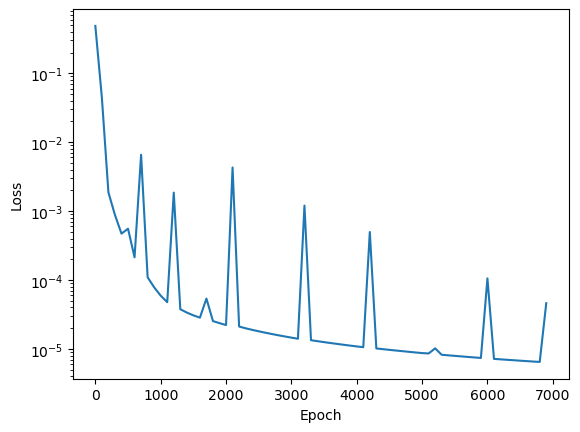

In [10]:
# Train model
epochs = 7000 # Number of training iterations (This can be adjusted based on convergence and computing time)
#List is to store the loss and epoch
loss_list = []
epoch_list = []

# Train model
for epoch in range(epochs):
    pde_loss, IC_loss, BC_left_loss, BC_right_loss,loss_total = train_step(
        X_left, X_right, X_collocation, X_ic, optimizer,model)
    
    if epoch % 100 == 0:
        loss_list.append(loss_total.item())
        epoch_list.append(epoch)
        scheduler.step() # Update learning rate
        print(f'Epoch {epoch}, pde {pde_loss.item():.4e} , IC {IC_loss.item():.4e}, BC_left {BC_left_loss.item():.4e}, BC_right {BC_right_loss.item():.4e}, loss {loss_total.item():.4e}')

# Plot loss
plt.plot(epoch_list, loss_list)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


Now that we have our trained model, we can use it to predict and visualize the results. Note that although we have only used $20 \times 20$ grid for training, we can now evaluate our model using an arbitrarily larger number of points. This showcases one of the great advantages of using a neural networks to solve differential equations, namely interpolation.

In [11]:
# Generate data for plotting
N_space_plot = 100
N_time_plot = 100
x_space_plot = np.linspace(0, 1, N_space_plot)
x_time_plot = np.linspace(0, 1, N_time_plot)
x_space_mesh, x_time_mesh = np.meshgrid(x_space_plot, x_time_plot)
x_space_flat = x_space_mesh.reshape(-1, 1)
x_time_flat = x_time_mesh.reshape(-1, 1)
x = np.hstack((x_space_flat, x_time_flat))
x_tensor = torch.tensor(x, dtype=torch.float32, device=device)
analytical = analytical_solution(x).reshape(N_space_plot, N_time_plot)

* When plotting, we need to work with either NumPy arrays or standard data structures like lists. Pytorch tensors are not directly compatible with Matplotlib's functions. Therefore, we have to convert the tensor to a NumPy array using .numpy().

* Additionally, PyTorch tensors used in model training are typically part of a computational graph, which is necessary for gradient computation during backpropagation. However, for plotting, gradient computation is irrelevant. Using .detach() removes the tensor from the computational graph, ensuring that unnecessary computational resources are not used.

* If your PyTorch model is running on a GPU, the tensors containing the model's outputs will also be on the GPU. Matplotlib, however, does not support plotting directly from GPU tensors. The .cpu() method ensures that the data is transferred back to the CPU, where Matplotlib can access and plot it.

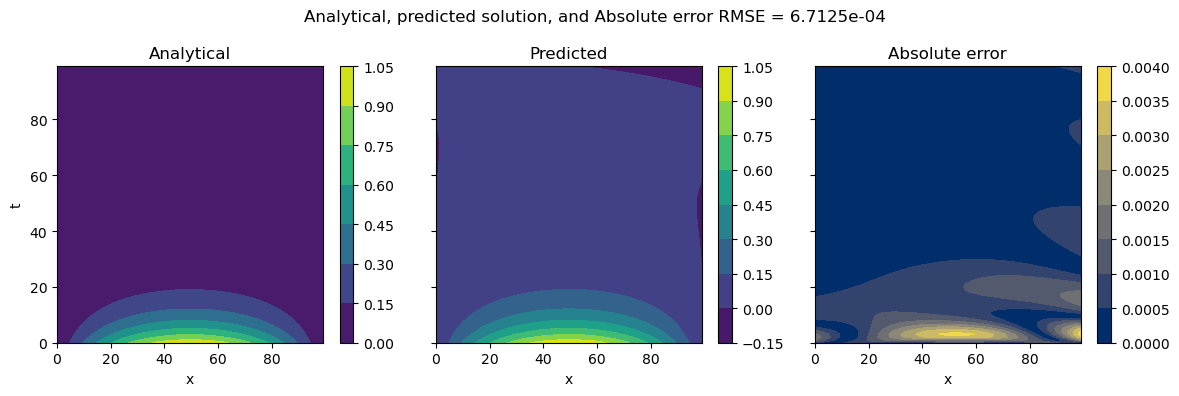

In [12]:
y_pred = model(x_tensor).detach().cpu().numpy().reshape(N_space_plot, N_time_plot)

# Plot prediction and analytical in subplots
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
fig.suptitle('Analytical and predicted solution')
c0=axs[0].contourf(analytical)
axs[0].cb = plt.colorbar(c0, ax=axs[0])
axs[0].set_title('Analytical')
axs[0].set_ylabel('t')
axs[0].set_xlabel('x')
c1=axs[1].contourf(y_pred)
axs[1].cb = plt.colorbar(c1, ax=axs[1])
axs[1].set_title('Predicted')
axs[1].set_xlabel('x')
c2=axs[2].contourf(np.abs(analytical-y_pred),cmap='cividis')
axs[2].cb = plt.colorbar(c2, ax=axs[2])
axs[2].set_title('Absolute error')
axs[2].set_xlabel('x')
RMSE = np.sqrt(np.mean((analytical-y_pred)**2))
# RMSE in title
fig.suptitle(f'Analytical, predicted solution, and Absolute error RMSE = {RMSE:.4e}')
plt.tight_layout()
plt.show()

#### Further paths based on the diffusion equation 

Now that we are familiar with the basics of Physics-Informed Neural Networks for solving partial differential equations, there are many project paths that can be taken from here. 

##### From the Diffusion Equation to the Schrödinger Equation

We start with the standard diffusion equation for a scalar field $\rho(\mathbf{r},t)$:

$$
\frac{\partial \rho}{\partial t}
= D\,\nabla^2 \rho
$$

where $D$ is the diffusion constant.

---

1. Wick rotation (imaginary‐time substitution)

Notice the formal similarity between diffusion and quantum evolution if we replace real time by imaginary time. Introduce

$$
t \;\longrightarrow\; -\,\frac{i\,t}{\hbar},
\qquad
\rho \;\longrightarrow\; \psi,
\qquad
D \;\longrightarrow\; \frac{\hbar}{2m}.
$$

Under these substitutions:

$$
\frac{\partial}{\partial t}\Big|_{\rho}
=
\frac{\partial}{\partial \bigl(-\,i t/\hbar\bigr)}\Big|_{\psi}
=
-\frac{i}{\hbar}\,\frac{\partial \psi}{\partial t},
$$

and

$$
D\,\nabla^2 \rho
\;\longrightarrow\;
\frac{\hbar}{2m}\,\nabla^2 \psi.
$$

---

2. Apply the substitution

Plugging into the diffusion equation,

$$
-\frac{i}{\hbar}\,\frac{\partial \psi}{\partial t}
=
\frac{\hbar}{2m}\,\nabla^2 \psi.
$$

Multiply both sides by $-\, i\hbar$:

$$
i\,\hbar\,\frac{\partial \psi}{\partial t}
=
-\frac{\hbar^2}{2m}\,\nabla^2 \psi.
$$

This is exactly the **free‐particle Schrödinger equation**:

$$
i\hbar\,\frac{\partial \psi}{\partial t}
=
-\frac{\hbar^2}{2m}\,\nabla^2 \psi.
$$

---

3. Including an External Potential

Physically, a potential $V(\mathbf r,t)$ contributes a drift term to the diffusion‐type evolution. For simpliticty we just add it to our equation and get 
$$
i\hbar\,\frac{\partial \psi}{\partial t}
=
-\frac{\hbar^2}{2m}\,\nabla^2\psi
\;+\;V(\mathbf r,t)\,\psi.
$$

Hence one arrives at the **full time‐dependent Schrödinger equation**

$$
i\hbar\,\frac{\partial \psi(\mathbf r,t)}{\partial t}
=
\Bigl(-\tfrac{\hbar^2}{2m}\,\nabla^2 + V(\mathbf r,t)\Bigr)\,\psi(\mathbf r,t).
$$


 


#### Finance and option pricing 

One can also derive one of the most important equations in mathematical finance from the diffusion equation by including a stochastic term. Throughout the rest of this tutorial we will solve the Black-Scholes equation using Physics-Informed Neural Networks. In addition to the fundamentals implemented and discussed regarding the diffusion equation, we will add more functionality and experiments to show how a possible project on PINNs may look like. 
This file is written to be pedagogical, and thus contains phrases and formulations not necessarily suitable for the more formal project that you will write. 



## **Mathematical finance with Physics Informed Neural Networks - The pricing of options**


#### On options and finance 
In finance an option is a contract which gives the owner the right to buy an underlying asset at a set time in the future called the time of maturity. The underlying asset can be everything from stocks to currencies to oil. 
Accurately pricing options is a major challenge in mathematical finance. Algorithms have been used to address this problem as far back as the early 1980s. Although these approaches have become more advanced, the complexity of the financial markets still makes options difficult to model accurately. Advancements in machine learning have established neural networks as a powerful tool for this, due to their ability to handle large datasets, and capture complex patterns. 

One mathematical model that helps in the pricing of options is the famous Black-Scholes model (also referred to as the Black-Scholes-Merton model). This mathematical model aims to estimate a fair price of an option based on certain assumptions and market conditions. A fair price simply means a reasonable price considering the price of the underlying asset and when the option must exercised. In this model the price of the option $C(S,t)$ is governed by a partial differential equation, the Black-Scholes equation (BS). Here $C(S,t)$ is a function of the price of the underlying asset $S$ and the time $t$. 



#### On Physics Informed Neural Networks
In addition to the constraints provided by the equation (as we saw above) one can train a PINN network on real-world data as well as the underlying differential equation dictating the distribution of the data.
Since the price of an option in the Black-Scholes model is governed by a partial differential equation it is natural to ask the question of whether Physics Informed Neural Networks can price options. This motivates us to construct a PINN model that will solve the Black-Scholes equation. We will then compare the results of the model with the analytical solution, as well as the prediction of a traditional feed-forward neural network. Later in the example we will also solve the multidimensional Black-Scholes equation which is a generalization of the Black-Scholes equation such that the option can have multiple underlying assets. We can think of such an option as a an option on a portfolio of assets. 


##### From the Heat Equation to the Black–Scholes PDE

We begin with the **heat equation** in the variables $(x,\tau)$:

$$
\frac{\partial u}{\partial \tau}
= \tfrac12\,\sigma^2\,\frac{\partial^2 u}{\partial x^2},
$$

where $\sigma$ is a constant.

---

1. Change of variables

Set
$$
x = \ln\!\Bigl(\frac{S}{K}\Bigr), 
\quad
\tau = \tfrac12\,\sigma^2\,(T - t),
\quad
u(x,\tau) = e^{\alpha x + \beta \tau}\;C(S,t),
$$

where
- $S$ is the underlying asset price,
- $t$ is the current time,
- $T$ is maturity,
- $K$ is the strike price,
- $\alpha$ and $\beta$ are constants to be chosen.

Compute the derivatives via the chain rule:

$$
\frac{\partial u}{\partial \tau}
= e^{\alpha x + \beta \tau}\,\Bigl(\beta\,C - \tfrac{2}{\sigma^2}\,C_t\Bigr),
$$

$$
\frac{\partial u}{\partial x}
= e^{\alpha x + \beta \tau}\,\bigl(\alpha\,C + S\,C_S\bigr),
$$

$$
\frac{\partial^2 u}{\partial x^2}
= e^{\alpha x + \beta \tau}\,\bigl(\alpha^2\,C + (2\alpha + 1)\,S\,C_S + S^2\,C_{SS}\bigr).
$$

---

2. Substitute into the heat equation

Plugging these into
$$
u_\tau = \tfrac12\,\sigma^2\,u_{xx},
$$

we get

$$
\beta\,C - \tfrac{2}{\sigma^2}\,C_t
\;=\;
\tfrac12\;\bigl[\alpha^2\,C + (2\alpha+1)\,S\,C_S + S^2\,C_{SS}\bigr].
$$

Rearrange:

$$
C_t
+ \frac{\sigma^2}{4}\,\bigl(\alpha^2\,C + (2\alpha+1)\,S\,C_S + S^2\,C_{SS}\bigr)
- \frac{\sigma^2}{2}\,\beta\,C
= 0.
$$

---

3. Choose $\alpha,\beta$ 

We pick $\alpha$ and $\beta$ so that the terms in $C$ and $C_S$ combine into the Black–Scholes form:

$$
2\alpha + 1 = \frac{2r}{\sigma^2},
\qquad
\beta = \alpha\,\frac{r}{\sigma^2} + \frac{r}{\sigma^2}.
$$

With these,
$$
C_t + \tfrac12\sigma^2 S^2 C_{SS} + rS C_S - rC = 0.
$$

---

4. The Black–Scholes PDE

Hence the option price $C(S,t)$ satisfies

$$
\boxed{
\frac{\partial C}{\partial t}
\;+\;
\frac12\,\sigma^2\,S^2\,\frac{\partial^2 C}{\partial S^2}
\;+\;
r\,S\,\frac{\partial C}{\partial S}
\;-\;
r\,C
=0
}.
$$





This partial differential equation governs the price of an option with a single underlying asset. 
Here $C(S,t)$ is the price of the option, $\sigma$ is the volatility of the underlying asset, i.e. how much the price fluctuates as times goes on, and $r$ is the risk-free rate. The risk-free rate is a measure of much money grows over time, under the assumption of a risk-free market. We will not go further into risk-free rates and volatilities in this example. We shall simply treat them as constants in our model. 


The partial differential equation has a terminal condition. This condition is at the time of maturity $t = T$, i.e. the set date when the option must be exercised. The terminal condition is given by 
$$
\boxed{C(S, T) = \max(S - K, 0)},
$$
Here $S$ is as before, the price of the underlying asset. We also notice a new term $K$. $K$ is known as the strike price. The strike price is the predetermined price at which you can buy the underlying asset. 


The boundary conditions are 

**Boundary at $S = 0$**:
$$
C(0, t) = 0, \quad 0 \le t \le T.
$$

**Boundary as $S \rightarrow \infty$** (large asset price):
$$
C(S, t) \approx S - K\,e^{-r\,(T - t)}, \quad 0 \le t \le T.
$$


In the case of one underlying asset the BS equation has a closed-form analytical solution. This allows us to compute the exact option
price without relying on numerical simulations or iterative methods—something that’s rarely possible in most
real-world scenarios. Not only does this offer a fast way to price European options, but the mathematics behind the solution also lay
the groundwork for more advanced models and numerical techniques used in modern option pricing, such as the
multi-dimensional Black-Scholes equation and Monte Carlo (MC)
methods.

To make sure every term and concept is understood we consider a simple example. 
If you believe that Apple stock will increase over the next year you might consider buying Apple stock. Since you are now familiar with options you will also know that you can buy an option that gives you the right to buy Apple stock at a price $K$ in one year, instead of buying the stock now. The attractiveness of options come from the fact that the strike price $K$ may be less than the price of the Apple stock in one year, so you essentially get to buy the stock at a discounted price one year from now. For a concrete example consider the table below. 
### Example: Buy Stock vs. Buy Option

| Parameter              | Value    |
|-----------------------|----------|
| Current Stock Price ($S_0$) | \$20      |
| Strike Price ($K$)         | \$22      |
| Time to Expiry ($T$)           | 1 year   |
| Price of option ($C(S_0, t=0)$)           | \$2       |

---

| Stock Price at Maturity ($T$) | Stock Profit/Loss               | Option Profit/Loss                                |
|-------------------------------|--------------------------------|--------------------------------------------------|
| \$10                          | $10 - 20 = \mathbf{-10}$       | Option worthless, loss = $\mathbf{-2}$           |
| \$18                          | $18 - 20 = \mathbf{-2}$        | Option worthless, loss = $\mathbf{-2}$           |
| \$22                          | $22 - 20 = \mathbf{2}$         | Break-even, payoff = $(22 - 22) - 2 = \mathbf{-2}$ |
| \$24                          | $24 - 20 = \mathbf{4}$         | Payoff = $(24 - 22) - 2 = \mathbf{0}$            |
| \$28                          | $28 - 20 = \mathbf{8}$         | Payoff = $(28 - 22) - 2 = \mathbf{4}$            |


---
Here we see some positive aspects of trading in options. When the stock price significantly decreases over the course of a year to \$10, buying the stock itself would result in losing \$10, while buying the option would only result in a loss of \$2.

We also see that when the stock is worth \$28 at the time of maturity, buying the stock yields a gain of \$8, which is 40\% of the money you invested, while the option yields a return of \$4, which is 200\% of the money invested.

There is much more to why options are attractive, but hopefully this gives you the main idea behind why it may be useful to buy such contracts.

*NB!*: What we have called an option above is a specific case of an option. There are a variety of different types of options, with different  criteria for when and how you can buy, and even sell underlying assets. For the people interested in finance we specifically work with European Call options in this example. That the option is European means that the option can only be exercised at the time of maturity. That the option is a call option means that the contract gives the owner the right to buy the underlying asset. A put option is analgously the right to sell the underlying asset involved in the option contract. We will not delve deeper into the specifics of options here. What we care about is using PINNs to solve the Black-Scholes equation! We will continue to call European Call options simply for 'options'. 



Now that we have a grasp of options and have motivated why it could be interesting to price them using PINNs, we start our exploration by solving the Black-Scholes equation using an analytical formula. We then compare this to the results provided by a PINN model. 
After this we continute to the most exciting - and difficult- part, which is pricing an option with multiple underlying assets. In this case there are no closed-form solutions so we will compare our results to Monte Carlo simulations. 



### Analytical Solution to the Black-Scholes Equation


The analytical solution to the Black-Scholes equation is:

$$
C(S, t) = S N(d_1) - K e^{-r(T - t)} N(d_2),
$$

where

$$
d_1 = \frac{\ln\left(\frac{S}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)(T - t)}{\sigma \sqrt{T - t}}, \quad
d_2 = d_1 - \sigma \sqrt{T - t}
$$

- $C$: call option price  
- $S$: current stock price  
- $K$: strike price  
- $r$: risk-free interest rate  
- $\sigma$: volatility  
- $T - t$: time to maturity  
- $N(\cdot)$: cumulative distribution function (CDF) of the standard normal distribution


In [13]:
import numpy as np 
from scipy.stats import norm 


def analytical_solution(S, K, T, t, r, sigma):
    """
    Computes the analytical solution of the Black-Scholes equation for a European call option.
  
    Parameters:
        - S (np.ndarray): Grid of asset prices (same shape as t). 
        - K      (float): Strike price of the option.
        - T      (float): Maturity time (i.e., time when option expires).
        - t (np.ndarray): Time grid (same shape as S). Must satisy 0 <= t <= T. 
        - r      (float): Risk-free interest rate
        - sigma  (float): Volatility of the underlying asset

    Returns:
        - The analytical solution of the BS-equation (the price of the call option).
    """
    # Time to maturity
    tau = T - t
    # Add a safeguard in case some values of t > T sneak in due to numerical error:
    tau = np.maximum(T - t, 0)

    
    # Initialize output array for option prices
    C = np.zeros_like(S)

    # Identify grid points where option has not yet expired (tau > 0)
    mask = tau > 0

    # Compute d+ and d− using the Black-Scholes formula where tau > 0
    sqrt_tau = np.sqrt(tau[mask])

   
    d_plus  = (np.log(S[mask] / K) + (r + 0.5 * sigma**2) * tau[mask]) / (sigma * sqrt_tau)
    d_minus = d_plus - sigma * sqrt_tau

    # Black–Scholes price before expiry
    C[mask] = (
        S[mask] * norm.cdf(d_plus) -
        K * np.exp(-r * tau[mask]) * norm.cdf(d_minus)
    )

    #At expiry (tau == 0), the option value equals the payoff: max(S - K, 0)
    C[~mask] = np.maximum(S[~mask] - K, 0)
    
    return C


Now we plot the solution on a grid.

In [14]:
import matplotlib.pyplot as plt

def plot_analytical(S_grid, t_grid, K, T, r, sigma, levels=20, cmap="viridis",
                    figsize=(6, 5)):
    """
    Plots the analytical Black–Scholes solution as a contour plot.
    
    Parameters:
    - S_grid, t_grid: 2D numpy arrays of the same shape defining the asset price and time grid.
    - K: Strike price.
    - T: Expiry time.
    - r: Risk-free interest rate.
    - sigma: Volatility.
    - levels: Number of contour levels or list of levels.
    - cmap: Colormap.
    - figsize: Figure size tuple.
    - save_path: Directory path to save the figure (optional).
    - filename: Filename for saving the figure (optional).
    
    Returns:
    - fig, ax: Matplotlib figure and axis objects.
    """
    # Compute analytical prices
    C = analytical_solution(S_grid, K, T, t_grid, r, sigma)
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    c = ax.contourf(S_grid, t_grid, C, levels=levels, cmap=cmap)
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label(r"$C(S,t)$ [\$]", fontsize=14)
    
    # Labels and styling
    ax.set_title("Analytical Black–Scholes Solution", fontsize=16)
    ax.set_xlabel(r"$S$ [\$]", fontsize=14)
    ax.set_ylabel(r"$t$ [years]", fontsize=14)
    ax.tick_params(labelsize=12)
    
    plt.tight_layout()
    

    return fig, ax


/var/folders/td/3yk470mj5p931p9dtkk0y6jw0000gn/T/ipykernel_33396/4185607999.py:36: RuntimeWarning: divide by zero encountered in log
  d_plus  = (np.log(S[mask] / K) + (r + 0.5 * sigma**2) * tau[mask]) / (sigma * sqrt_tau)


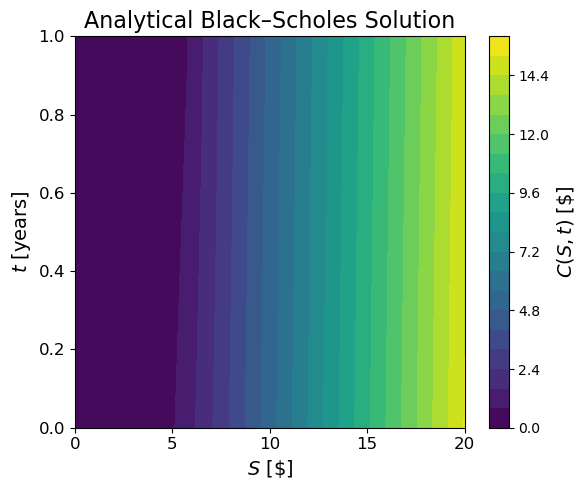

In [15]:
S_vals = np.linspace(0, 20, 100)
t_vals = np.linspace(0, 1, 100)
S_grid, t_grid = np.meshgrid(S_vals, t_vals)
fig, ax = plot_analytical(S_grid, t_grid, K=5, T=1, r=0.05, sigma=0.3)
plt.show()

It is important to note here that the values for $\sigma$ and $r$ are typical in mathematical finance, while the maxmimum price for $S$ and the strike price $K$ were chosen such that the behavior as $S$ become large is captured in the plot (the lines become more and more straight)

### Constructing our PINN model



**NB** in the tables and print statements below you might experience different results when running the file compared to what is printed here from before. Though the errors should be approximately of equal magntiude. One thing that may happen is that the PINN performs significantly worse in the 1D case before the hyperparameter congiruation (as you may see from the plots). This has sometimes happened (but not often) when writing the file. This discrepancy in results (even though we use exactly the same code) may come from the fact that the model gets stuck in local minima, or that the loss functions are not weighted properly. 

##### Setting up the Neural Network

The model is fully connected feed-forward neural network, also known as a Multilayer Perceptron (MLP). There is one input layer, multiple hidden layers, and one output layer.

We use tanh as the activation function for all hidden layers. The weights are initialized using uniform Xavier initialization. Uniform Xavier initialization can help with vanishing and exploding gradients at the beginning of training by ensuring that the variance of both activations and gradients stay roughly constant across layers. 

In [16]:
import torch
import torch.nn as nn
import torch.nn.init as init

class Model(nn.Module):
    """
    A fully connected feed-forward neural network designed for solving PDEs using 
    Physics-Informed Neural Networks (PINNs). 

    This model allows customization of the input size, the number and size of hidden layers, and the activation function.
    """
    def __init__(self, num_inputs, hidden_layers, activation_function=nn.Tanh()):
        """
        Initializes the fully connected neural network.

        Parameters:
            - num_inputs                (int): Number of input features (e.g., spatial and temporal coordinates).
            - hidden_layers     (list of int): List specifying the number of neurons in each hidden layer.
            - activation_function (nn.Module): Activation function to apply after each hidden layer.
        """
        super(Model, self).__init__()  # Initialize the parent class

        self.activation = activation_function
        
        # Build the network layer by layer
        layers = [nn.Linear(num_inputs, hidden_layers[0]), self.activation]
        for i in range(1, len(hidden_layers)):
            layers += [nn.Linear(hidden_layers[i-1], hidden_layers[i]), self.activation]
        layers.append(nn.Linear(hidden_layers[-1], 1))


        # Create model and move it to the appropriate device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = nn.Sequential(*layers).to(device)

        # Initialize weights using Xavier initialization 
        self.model.apply(self._init_weights)

       

    def _init_weights(self, m):
        """
        Applies Xavier unifeorm initialization to the weights of linear layers,
        and sets their biases to zero.

        Parameters:
            - m (nn.Module): A layer in the model passed during model.apply().
        """
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight, gain=init.calculate_gain('tanh'))
            if m.bias is not None:
                init.zeros_(m.bias)  # Set bias to zero
        
     
    
    def forward(self, x):
        """
        Performs the forward pass of the neural network.

        Parameters:
            - x (torch.Tensor): Input tensor of shape (batch_size, num_inputs),
                                typically representing spatial and/or temporal coordinates.

        Returns:
            - torch.Tensor:     Output tensor containing the model's predictions.
        """       
        # Pass input through the network
        return self.model(x)

#### Training Data

One great aspect of PINNs is that much of the data (sometimes all of it, as in our case) used for training can be generated at will, since we simply need to draw points from the domian the underlying equation is defined upon. To sample our data we will use LatinHypercube from SciPy. 

We create a class that handles initialization. We also define a normalization function that maps the domain $[0,S_\text{max}] \times [0,T]$ to the range $[-1,1] \times [-1,1]$. This is done to make training more stable, and because large inputs saturate for the tanh activation function.

In [17]:
from scipy.stats.qmc import LatinHypercube

In [18]:
class InitializeData():
    """
    Handles data initialization and normalization for training a PINN and
    financial PDEs with multplie underlying assets.
    """
    def __init__(self, S_max, T):
        """
        Parameters:
            - S_max_list (lifloatst): Maximum value for asset.
            - T         (float): Time to maturity.
        """
        self.S_max = S_max
        self.T = T 
        self.dim = 2  # Total input dimensions (assets + time) 
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
   
 
    
    def normalize(self, pts): 
        """
        Normalizes inputs [S, t] to [-1,1] range.
        
        Parameters:
            - pts (torch.Tensor): Shape (N, 2)
        
        Returns:
            - torch.Tensor: Normalized coordinates in [-1, 1].
        """        
        S = pts[:, :self.dim - 1] 
        t = pts[:, -1:]

      
        # Normalize each asset component and time
        x_norm = 2.0 * S / self.S_max - 1
        tau_norm = 2.0 * ((self.T - t) / self.T) - 1

        return torch.cat([x_norm, tau_norm], dim=1)
    
    def data_lbc(self, n_points, seed):
        """
        Generates 2D left boundary condition points over (S, t).

        Parameters:
            - n_points (int): Number of boundary points.
            - seed     (int): Random seed.
        
        Returns:
            - torch.Tensor: Shape (n_points, 2), each row is (S, t) normalized.
        """
        # Sample time values t in [0, T]
        sampler = LatinHypercube(d=1, seed=seed)
        t_samples = torch.tensor(sampler.random(n=n_points), dtype=torch.float32, device=self.device)
        t_scaled = t_samples * self.T  # Scale time to [0, T]


        #create tensor of shape (n_points, 1) filled with zeros for S 
        S_tensor = torch.full((n_points, 1), 0, dtype=torch.float32, device=self.device)

        # Concatenate (S, t)
        lbc_points = torch.cat([S_tensor, t_scaled], dim=1)

        # Normalize and return with shape (1, n_points, 2)
        return self.normalize(lbc_points)
    
    def data_rbc(self, n_points, seed):
        """
        Generates 2D left boundary condition points over (S, t).

        Parameters:
            - n_points (int): Number of boundary points.
            - seed     (int): Random seed.
        
        Returns:
            - torch.Tensor: Shape (n_points, 2), each row is (S, t) normalized.
        """
        # Sample time values t in [0, T]
        sampler = LatinHypercube(d=1, seed=seed)
        t_samples = torch.tensor(sampler.random(n=n_points), dtype=torch.float32, device=self.device)
        t_scaled = t_samples * self.T  # Scale time to [0, T]


    
        S_tensor = torch.full((n_points, 1), self.S_max, dtype=torch.float32, device=self.device)

        # Concatenate (S, t)
        rbc_points = torch.cat([S_tensor, t_scaled], dim=1)

        # Normalize and return with shape (n_points, 2)
        return self.normalize(rbc_points)
    

    def data_pde(self, n_points, seed):
        """
        Generates 1D collocation points (S, t) for PDE loss training.

        Parameters:
            - n_points (int): Base number of collocation points.
            - n_extra  (int): Extra points near S_max and t ≈ 0.
            - seed     (int): Random seed.

        Returns:
            - torch.Tensor: Normalized collocation points, shape (n_points + n_extra, 2).
        """
        # Base collocation points over the full domain 
        sampler = LatinHypercube(d=2, seed=seed)
        samples = torch.tensor(sampler.random(n=n_points), dtype=torch.float32, device=self.device)
        
        # Scale S and t
        samples[:, 0] *= self.S_max# S in [0, S_max]
        samples[:, 1] *= self.T             # t in [0, T]

        #return normalized collocation points 
        return self.normalize(samples)
    
    def data_tc(self, n_points, seed):
        """
        Generates 1D terminal condition points (S, T).

        Parameters:
            - n_points  (int): Number of main points over full S range.
            - seed    (int): Random seed.

        Returns:
            - torch.Tensor: Normalized terminal condition points, shape (n_main, 2).
        """


        # Main points: S in [0, S_max], t = T 
        sampler = LatinHypercube(d=1, seed=seed + 17)
        S = torch.tensor(sampler.random(n=n_points), dtype=torch.float32, device=self.device)
        S *= self.S_max
        t = torch.full((n_points, 1), self.T, dtype=torch.float32, device=self.device)
        samples = torch.cat([S, t], dim=1)
      
        # Normalize and return
        return self.normalize(samples)


##### Loss functions

Now we move on to defining the loss function for our model. As we have previously discussed PINNs incorporate the mathematical constraints governing a system into the training of the model itself. All of these loss functions are then used in a composite total loss function. In addition to the equation-based loss functions one can also define a traditional data loss. For all the loss functions we will use mean squared error (MSE). The MSE is defined as:
$$
    \text{MSE}(\mathbf{C}^{\text{target}}, \mathbf{\hat{C}}) = \frac{1}{N_{\text{cond}}} \sum_{j=1}^{N} (C_j^{target} - \hat{C}_j)^2,
$$
where $N_{\text{cond}}$ is the number of data points used in the respective loss function; this value varies depending on which loss component is being considered. $\mathbf{C}^{\text{target}}$ contains the target values $C_j$, and $\mathbf{\hat{C}}$ is the tensor containing the model prediction values $\hat{C_j}$. 



**PDE loss function**

We construct a loss term that measures how closely the PINN’s predicted price $\hat{C}(S,t)$
satisfies the Black-Scholes equation. At each collocation point $(S_j,t_j)$ define the PDE residual as
$$
R\bigl(S_j,\,t_j\bigr)
\;=\;
\frac{\partial \hat{C}}{\partial t}\Big|_{(S_j,\,t_j)}
\;+\;\frac{1}{2}\,\sigma^2\,S_j^2\,
\frac{\partial^2 \hat{C}}{\partial S^2}\Big|_{(S_j,\,t_j)}
\;+\;r\,S_j\,
\frac{\partial \hat{C}}{\partial S}\Big|_{(S_j,\,t_j)}
\;-\;r\,\hat{C}\bigl(S_j,\,t_j\bigr).
$$
We set $R^{\text{target}}_j=0 \quad \text{for all} \quad j$, as is given by BS, and collect all of these in the tensor $\mathbf{R}^{target}$. Let $\mathbf{\hat{R}}$ denote the residuals evaluated at each $(S_j, t_j)$. The PDE loss is then defined:
$$
\mathcal{L}_{\text{PDE}} = \text{MSE}(R^{target}, \hat{R}). 
$$


**Terminal Condition loss Function**

The target value $\mathbf{T^{\mathrm{target}}}$ is given by

$$
\mathbf{T^{\mathrm{target}}} = \max(S - K, 0),
$$

and $\mathbf{\hat{T}}$ is the model prediction. The loss is then the mean‑squared error between them:

$$
\mathcal{L}_{\mathrm{TC}}
= MSE(\mathbf{T}^{\mathrm{target}}, \mathbf{\hat{T}}).
$$


**Left boundary condition loss function** 

For the loss that enforces the left boundary condition, we define $\mathbf{L}^{\text{target}}$ to be a contain only zeros in accordance with the value expected when $S = 0$. The model prediction is $\mathbf{\hat{L}}$. 
The resulting loss is 
$$
\mathcal{L}_{\text{LBC}} = MSE(\mathbf{L}^{{\text{target}}}, \mathbf{\hat{L}}). 
$$

**Right boundary condition loss function**
Finally, we need to impose a loss function corresponding to the behavior for large $S$. 
When solving the equation on a computer we must truncate the spatial domain to $[0,S_\text{max}]$. 
We use a Dirichlet boundary condition and define it as 
$$
C(S_{\max}, t) = S_{\max} - K e^{-r(T - t)},
$$ 
where $C(S_{\max}, t)$ is the option price on the domain when $S = S_\text{max}$. The corresponding loss has as target $C_{R}^{\text{target}} =S_{\max} - K e^{-r(T - t)}$. The model prediction is denoted $\hat{C}_R$. Thus, we obtain the loss function  
$$
\mathcal{L}_{\text{RBC}} = \text{MSE}(\mathbf{C_R}^{\text{target}}, \mathbf{\hat{C}_R}). 
$$, where $\mathbf{\hat{C}_R}$ is the model prediction. 



Finally we obtain the total loss function given by: 

$$
\mathcal{L}_{\text{tot}} = \mathcal{L}_{\text{PDE}} + \mathcal{L}_{\text{TC}} + \mathcal{L}_{\text{LBC}} + \mathcal{L}_{\text{RBC}}
$$

**Data loss**
In addition to the aforementioned PINN-specific loss functions, we also create a data loss function for later comparison between our PINN model and a regular feed-forward Neural network. This is similarily defined as the loss functions above. 

$$
\mathcal{L}_\text{data} = MSE(\mathbf{C}^{\text{target}}_{\text{data}}, \mathbf{\hat{C}}_{\text{data}})
$$

The objective of the training is to minimize the $\mathcal{L}_{\text{tot}}$. This will hopefully lead to the neural network adequately approximating the solution to BS while also respecting the initial and boundary conditions. We create a class containing our loss functions. 

**Loss function class**


In [19]:
class LossFunctions():
    """
    Collection of loss function used to train a Physics-Informed Neural Network (PINN)
    for solving high-dimensional Black-Scholes-type PDEs.
    """
    def __init__(self, model, S_max, r=1.0, K=1.0, sigma=1.0, T=1.0):
        """
        Initializes loss functions for PDE training.

        Parameters:
            - model          (nn.Module): Neural network representing the PDE solution.
            - S_max             (float): Max value for the asset.
            - r                  (float): Risk-free interest rate.
            - K                  (float): Strike price of the option.
            - sigma              (float): Volatility for the asset.
            - T                  (float): Time to maturity.
        """
        self.model = model
        self.S_max = S_max
        self.r = r
        self.K = K
        self.T = T
        self.mse = nn.MSELoss()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.sigma = sigma




    def PDE_loss(self, input_tensor):
            """
            Computes the mean squared residual of the PDE.

            Parameters:
                - input_tensor (torch.Tensor): Normalized inputs (S_norm, t_norm)
            
            Returns:
                - torch.Tensor: Scalar PDE residual loss.
            """
            input_tensor = input_tensor.clone().requires_grad_(True)
            
            x_norm = input_tensor[:, :-1] 
            tau_norm = input_tensor[:, -1:] 
        
            X = torch.cat([x_norm, tau_norm], dim=1)
            X = X.float().requires_grad_()
    
            # Model prediction
            C = self.model(X)

            # Compute gradients
            dC = torch.autograd.grad(C, X, torch.ones_like(C), create_graph=True)[0]
            C_tau_norm = dC[:, -1:]  # derivative with respect to tau
            C_x_norm = dC[:, :-1]  # gradient with respect to x
            
            # Denormalize asset prices and time
            S = 0.5 * (x_norm + 1.0) * self.S_max
            C_t = C_tau_norm * (-2.0 / self.T)   


            
    
            # Compute second derivative with respect to asset
            C_xx_norm = torch.autograd.grad(C_x_norm, x_norm, torch.ones_like(C_x_norm), create_graph=True)[0]

            # Denormalize first and second derivatives
            C_s = C_x_norm * (2.0 / self.S_max) 
            C_ss = C_xx_norm * ((2.0 / self.S_max)**2)

            # Compute PDE residual
            pde_residual = C_t + (0.5 * self.sigma**2 * S**2 * C_ss) + (self.r * C_s * S) - (self.r * C)

            return torch.mean(pde_residual**2)
    
    def TC_loss(self, tc):
        """
        Computes the loss for the terminal condition at maturity (t = T).

        Parameters:
            - tc (torch.Tensor): Normalized input tensor of shape (N, d+1), where the last column is t = T.

        Returns:
            - torch.Tensor: Mean squared error between model predictions and terminal payoff.
        """
        C_tc = self.model(tc)

        # Convert normalized inputs to real asset prices
        x_norm = tc[:, :-1]  
        S = (1 + x_norm) * self.S_max * 0.5

        # Compute the basket value (mean of asset prices) 
        basket = torch.mean(S, dim=1, keepdim=True) 
        true_tc = torch.maximum(basket - self.K, torch.zeros_like(basket))

        return self.mse(C_tc, true_tc)

    
    def LBC_loss(self, lbc):
        """
        Computes the loss for the left boundary condition where S_i = 0.

        Parameters:
            - lbc (torch.Tensor): Normalized tensor of shape (N, 1) for S_i = 0.
        

        Returns:
            - torch.Tensor: Mean squared error between model output and true boundary condition.
        """
        C_lbc = self.model(lbc)
     
        return torch.mean(C_lbc**2)
        

    def RBC_loss(self, rbc):
            """
            Computes the right boundary loss where S_i = S_max_i, which corresponds to the behavior as S_i → ∞.

            Parameters:
                - rbc (torch.Tensor): Right boundary data for asset i. Shape: (N, 1).
            
            Returns:
                - torch.Tensor: MSE loss between model output and expected boundary behavior.
            """
        
            C_rbc = self.model(rbc)  # Model prediction at boundary
            
            # Denormalize asset prices
            x_norm = rbc[:, :-1]     
            S = 0.5 * 20 *(x_norm + 1.0) 

            # Denormalize time and compute tau = T - t
            t_norm = rbc[:, -1:]  
            tau = self.T * (t_norm + 1) * 0.5 



            true_rbc = torch.maximum(S - self.K * torch.exp(-self.r * tau), torch.zeros_like(S))

            return self.mse(C_rbc,true_rbc)




**Training**


Now we are soon ready to solve the Black-Scholes equation with our PINN setup. The last thing that remains is to implement a training class for the model. We have two methods. One that handles a single training step, and one that handles the entire training.

In [20]:
class Training(LossFunctions):
    """
    Training class for Physics-Informed Neural Networks (PINNs) applied to high-dimensional
    Black-Scholes-type PDEs. Inherits from the LossFunction class, which provides the
    loss definition for the terminal condition, boundary conditions, and PDE residual.
    """
    
    def __init__(self, model, S_max, r=1, K=1, sigma=1, T=1):
        """
        Initialize the Training class for PINN-based Black-Scholes training.

        Parameters:
            - model          (nn.Module): The neural network model.
            - S_max         (float): Max asset values for each dimension.
            - r                  (float): Risk-free interest rate.
            - K                  (float): Strike price.
            - sigma      (float): Volatility per asset.
            - T                  (float): Time to maturity.
        """
        super().__init__(model, S_max, r, K, sigma, T)

       

    def training_step_BS(self, lbc, rbc, tc, pde, optimizer):
        """
        Performs a single training step: computes all loss components, adapts weights,
        backpropagates the weighted loss, and updates model parameters.

        Parameters:
            - lbc                      (Tensor): Left boundary condition data (d, N, d+1).
            - rbc                      (Tensor): Right boundary condition data (d, N, d+1).
            - tc                       (Tensor): Terminal condition data (N, d+1).
            - pde                      (Tensor): PDE interior sampling points (N, d+1).

            - optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
           
        
        Returns:
            - (tuple): Tuple containing:
                - total_loss      (Tensor): Total weighted loss.
                - pde_loss        (Tensor): PDE residual loss.
                - bc_left_total   (Tensor): Left boundary condition loss.
                - bc_right_total  (Tensor): Right boundary condition loss.
                - tc_loss         (Tensor): Terminal condition loss.
        
        """

      
        # Compute each component of the loss
        bc_left_total = self.LBC_loss(lbc)     # Tensor
        bc_right_total = self.RBC_loss(rbc)    # Tensor
        tc_loss = self.TC_loss(tc)
        pde_loss = self.PDE_loss(pde)

        # Combine losses (you can adjust weights if needed)
        total_loss = pde_loss + bc_left_total + bc_right_total + tc_loss

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        return total_loss, pde_loss, bc_left_total, bc_right_total, tc_loss
    

    def training_cycle_BS(self, N_epochs, lbc, rbc, tc, pde, optimizer, print_epochs = True):
        """
        Full traning cycle with checkpointing of best model.

        Parameters:
            - N_epochs                       (int): Number of training epochs.
            - lbc                         (Tensor): Left boundary condition training data.
            - rbc                         (Tensor): Right boundary condition training data.
            - tc                          (Tensor): Terminal condition training data.
            - pde                         (Tensor): PDE interior point training data.
            - optimizer    (torch.optim.Optimizer): Optimizer instance.
            - print_epochs (bool): Flag to control printing of training progress.
        
        Returns:
                - train_loss       (list): Total training loss per epoch.
                - train_epochs     (list): Epoch indices for training.

        """
        # Lists to store training and validation results
        loss, epochs = [], []

        #For checkpointing
        loss_check = float("inf")
        best_model_state = None 
    
        #Start training loop      
        for epoch in range(N_epochs):       
            self.model.train() #put model in training mode           

            
            # Run single training step
            total_loss, pde_loss, lbc_loss, rbc_loss, tc_loss = self.training_step_BS(
                lbc, rbc, tc, pde,
                optimizer
            )

            loss.append(total_loss.item())
            epochs.append(epoch)

            if print_epochs == True and (epoch % 10 == 0 or epoch == N_epochs - 1):
                print(f"Epoch {epoch+1}/{N_epochs}, "
                    f"Total Loss: {total_loss.item():.4f}, "
                    f"PDE Loss: {pde_loss.item():.4f}, "
                    f"LBC Loss: {lbc_loss.item():.4f}, "
                    f"RBC Loss: {rbc_loss.item():.4f}, "
                    f"TC Loss: {tc_loss.item():.4f}")


            # Checkpointing: save model if loss improves
            if total_loss < loss_check:
                loss_check = total_loss
                best_model_state = self.model.state_dict()
      
        # Save the best model state
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
   


        return loss, epochs
    

Now we have implemented all we need for actually solving the Black-Scholes equation with PINNs! Now we train a model. 

In [21]:
import torch.optim as optim #import to use Adam optimizer


#Initialize a model with 3 hidden layers, 32 nodes in each
model = Model(2, [32,32,32])
optimizer = optim.Adam(model.parameters(), lr=1e-2) #learning rate 10^(-2)

In [22]:
"""_______Training__________"""

#parameters 
S_max = 20 #maximum asset price
T = 1 #time of maturity
sigma = 0.3 #volatility
r = 0.05 #risk-free rate 
K = 5 #Strike price



#Initilize data 
num_lbc_points = 300 #number of points for left boundary condition 
num_rbc_points = 300 #number of points for right boundary condition 
num_tc_points = 500 #number of points for terminal condition 
num_pde_points = 3000 #number of collocation points

data_initializer = InitializeData(S_max, T)
lbc = data_initializer.data_lbc(num_lbc_points, 32) #tensor with lbc data
rbc = data_initializer.data_rbc(num_rbc_points, 33) #tensor with rbc data
tc = data_initializer.data_tc(num_tc_points, 34) #tensor with rc data
pde = data_initializer.data_pde(num_pde_points, 35) #tensor with pde data


N_epochs = 3000 #number of training iterations

#initialize training object 
trainer = Training(model, S_max, r, K, sigma, T)

#train model
loss_his, epochs_his= trainer.training_cycle_BS(N_epochs, lbc, rbc, tc, pde,
                                                              optimizer)


Epoch 1/3000, Total Loss: 355.5317, PDE Loss: 2.2004, LBC Loss: 2.4213, RBC Loss: 277.8110, TC Loss: 73.0989
Epoch 11/3000, Total Loss: 95.8118, PDE Loss: 4.5588, LBC Loss: 50.4841, RBC Loss: 30.8050, TC Loss: 9.9639
Epoch 21/3000, Total Loss: 32.1757, PDE Loss: 3.0105, LBC Loss: 2.4420, RBC Loss: 16.9880, TC Loss: 9.7352
Epoch 31/3000, Total Loss: 13.2369, PDE Loss: 2.1513, LBC Loss: 2.2270, RBC Loss: 4.2572, TC Loss: 4.6013
Epoch 41/3000, Total Loss: 4.7343, PDE Loss: 1.2729, LBC Loss: 0.0151, RBC Loss: 2.7647, TC Loss: 0.6815
Epoch 51/3000, Total Loss: 2.3759, PDE Loss: 1.1917, LBC Loss: 0.0206, RBC Loss: 0.4101, TC Loss: 0.7535
Epoch 61/3000, Total Loss: 1.5979, PDE Loss: 0.5181, LBC Loss: 0.0434, RBC Loss: 0.5817, TC Loss: 0.4547
Epoch 71/3000, Total Loss: 1.0719, PDE Loss: 0.3585, LBC Loss: 0.0177, RBC Loss: 0.3853, TC Loss: 0.3105
Epoch 81/3000, Total Loss: 0.7908, PDE Loss: 0.3395, LBC Loss: 0.0207, RBC Loss: 0.1949, TC Loss: 0.2356
Epoch 91/3000, Total Loss: 0.5792, PDE Loss: 

Now we plot loss vs epochs to see if how the total loss evolves during training. 


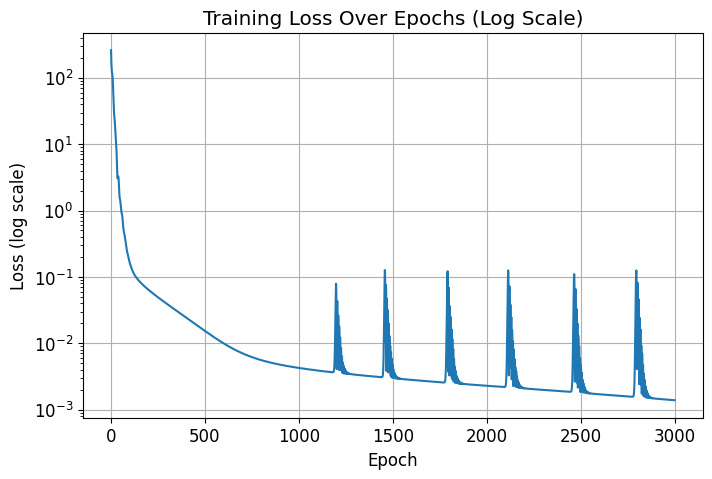

In [89]:
plt.figure(figsize=(8, 5))
plt.plot(epochs_his, loss_his)
plt.yscale('log')  # Set y-axis to log scale
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("Training Loss Over Epochs (Log Scale)")
plt.grid(True)
plt.show()

We see from the curve above that the loss has not yet converged. Try running with more epochs to see if you can obtain even better results. 

The sudden spikes in the loss curve may be caused by too high a learning rate, or sudden large gradients.

After training our model we compare it's predictions to the analytical solution.

In [90]:

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [91]:
def plot_comparison(S_grid, t_grid, analytical, predicted, save_path):
    """
    Generates visual comparisons between the PINN prediction and the analytical solution 
    for the 1D Black-Scholes equation on a 2D (S, t) grid. Produces and saves three plots:
    - PINN prediction vs analytical solution
    - Absolute error between the two
    - Zoomed-in view of small absolute errors (clipped)

    Parameters:
        - S_grid     (np.ndarray): 2D grid of asset prices.
        - t_grid     (np.ndarray): 2D grid of time values (same shape as S_grid).
        - analytical (np.ndarray): Analytical Black-Scholes solution on the grid.
        - predicted  (np.ndarray): PINN model prediction on the grid.
        - save_path         (str): Directory where plots will be saved.
    """

    levels = np.linspace(min(predicted.min(), analytical.min()),
                         max(predicted.max(), analytical.max()), 20)


    # Plot 1: PINN vs Analytical
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    plt.rcParams.update({
        "font.size": 14,
    })

    c1 = axes[0].contourf(S_grid, t_grid, predicted, levels=levels, cmap="viridis")
    fig.colorbar(c1, ax=axes[0])
    axes[0].set_title("PINN Prediction (3000 epochs)", fontsize=24)
    axes[0].set_xlabel(r"$S$ [\$]", fontsize=24)
    axes[0].set_ylabel(r"$t$ [years]", fontsize=22)
    axes[0].tick_params(axis="both", labelsize=18)

    c2 = axes[1].contourf(S_grid, t_grid, analytical, levels=levels, cmap="viridis")
    cbar = fig.colorbar(c2, ax=axes[1])
    cbar.set_label(r"$C$ [\$]", fontsize=20)
    axes[1].set_title("Analytical Solution", fontsize=24)
    axes[1].set_xlabel(r"$S$ [\$]", fontsize=22)
    axes[1].tick_params(axis="both", labelsize=18)

    plt.tight_layout()
 


    # Plot 2: Absolute error 
    abs_error = np.abs(predicted - analytical)
    #Prepare the custom colormap
    cmap = plt.cm.viridis.copy()
    cmap.set_bad("lightgrey")

    # Create figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 2 subplots side by side
    plt.rcParams.update({"font.size": 12})

    # --- Plot 1: Full Absolute Error ---
    cf1 = axes[0].contourf(S_grid, t_grid, abs_error, levels=20, cmap="viridis")
    cbar1 = fig.colorbar(cf1, ax=axes[0])
    cbar1.set_label(r"$|C_{\rm PINN}-C_{\rm ana}|$", fontsize=14)
    cbar1.ax.tick_params(labelsize=16)
    axes[0].set_xlabel(r"$S$ [\$]", fontsize=16)
    axes[0].set_ylabel(r"$t$ [years]", fontsize=16)
    axes[0].set_title("Absolute Error (3000 epochs)", fontsize=16)
    axes[0].tick_params(axis="both", labelsize=14)

    # --- Plot 2: Clipped Absolute Error ---
    masked_error = np.ma.masked_where(abs_error > 0.05, abs_error)  # Mask values > 0.1
    clip_point = 0.05
    cf2 = axes[1].contourf(S_grid, t_grid, masked_error, levels=np.linspace(0, clip_point, 20), cmap=cmap)
    cbar2 = fig.colorbar(cf2, ax=axes[1])
    cbar2.set_label(r"$|C_{\rm PINN}-C_{\rm ana}|$", fontsize=14)
    cbar2.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.4f"))
    axes[1].set_xlabel(r"$S$ [\$]", fontsize=16)
    axes[1].set_ylabel(r"$t$ [years]", fontsize=16)
    axes[1].set_title(f"Absolute Error ≤ {clip_point:.3f} (3000 epochs)", fontsize=16)
    axes[1].tick_params(axis="both", labelsize=14)

    plt.tight_layout()
    plt.show()


/var/folders/1n/kcxtjkk14hnb_vt5xqdg7zwr0000gn/T/ipykernel_54230/4185607999.py:36: RuntimeWarning: divide by zero encountered in log
  d_plus  = (np.log(S[mask] / K) + (r + 0.5 * sigma**2) * tau[mask]) / (sigma * sqrt_tau)


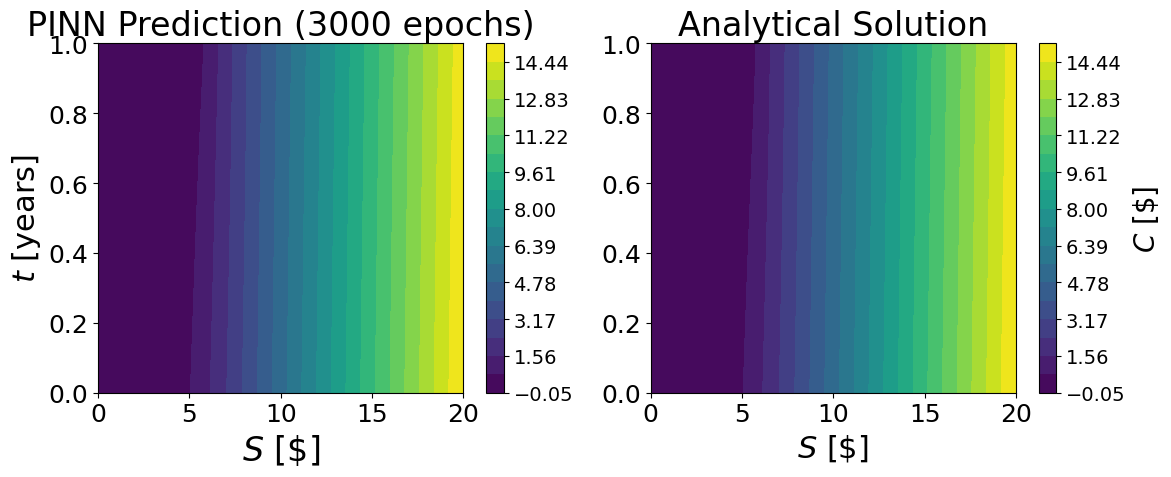

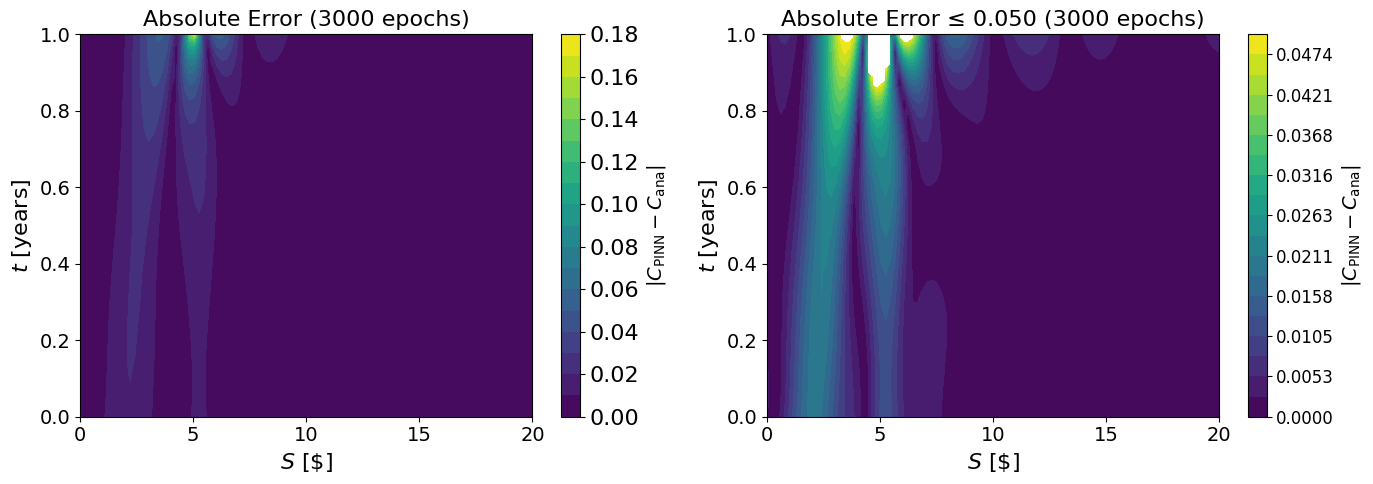

In [92]:


# Define parameters
num_S_points = 100
num_t_points = 100
S_array = np.linspace(0, S_max, num_S_points)
t = np.linspace(0, T, num_t_points)
S_mesh, t_mesh = np.meshgrid(S_array, t)
S_mesh_flat = S_mesh.reshape(-1, 1)
t_mesh_flat = t_mesh.reshape(-1, 1)

# Input to PINN model
x = np.hstack((S_mesh_flat, t_mesh_flat))
x_tensor = torch.tensor(x, dtype=torch.float32).to(trainer.device)
# Normalize input if required
x_tensor_norm = data_initializer.normalize(x_tensor)  # Assuming model has normalize()

# Predict using trained model
with torch.no_grad():
    predicted = model(x_tensor_norm).cpu().numpy().reshape(S_mesh.shape)

# Compute analytical solution on mesh
# Assumes analytical_solution takes meshgrid arrays (shape: (N,))
S_flat = S_mesh_flat.flatten()
t_flat = t_mesh_flat.flatten()
analytical_flat = analytical_solution(S_flat, K, T, t_flat, r, sigma)  # shape (N,)
analytical = analytical_flat.reshape(S_mesh.shape)

# Plot comparison
plot_comparison(
    S_grid=S_mesh,
    t_grid=t_mesh,
    analytical=analytical,
    predicted=predicted,         
    save_path="results"                     
)


We see that the model generally performs well. It struggles to capture the behavior given by the terminal condition at $S=K$, and the errors here seem to propagate through time. 

**Traditional Feedforward Neural network**

Now we create a traditional Neural Network that we can compare our PINNs model to. We could simply add a few methods and functionality to our classes from earlier, but to keep everything clear and distinct we create a new class for the traditional model. We only reuse the Model class from earlier. Since the new model requires less code we put everything in one class. 

In [93]:
class TraditionalSolver():
    def __init__(self, model, S_max_list, T, K, r, sigma):
       
        self.model = model 
        self.S_max = S_max
        self.T = T
        self.K = K
        self.r = r
        self.sigma = sigma

    def data_loss(self, analytical_data):
        C_data = self.model(analytical_data)  # shape: (N, 1)


        # Normalize and compute real S and t values
        x_norm = analytical_data[:, :-1]
        t_norm = analytical_data[:, -1:]


        
        S = 0.5 * (1 + x_norm) * self.S_max
        # Flip time interpretation, as we have terminal condition and solve backwards
        t = 0.5 * (1 - t_norm) * self.T

        
        true_solution = analytical_solution(S, self.K, self.T, t, self.r, self.sigma)
        true_solution = torch.tensor(true_solution, dtype=torch.float32).to(S.device) #convert to tensor


        mse = nn.MSELoss()
        
        return mse(C_data, true_solution)

    def training_step(self, data, optimizer):

        loss = self.data_loss(data)

        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss

    def training_cycle(self, N_epochs, data, optimizer):
        losses = []
        epochs = []

        best_loss = float("inf")
        best_model_state = None
        self.model.train() #put model in training mode           

        for epoch in range(N_epochs):
            loss = self.training_step(data, optimizer)
            losses.append(loss.item())
            epochs.append(epoch)


            if epoch % 10 == 0 or epoch == N_epochs - 1:
                print(f"Epoch {epoch+1}/{N_epochs}, Loss: {loss.item():.6f}")

            if loss.item() < best_loss:
                best_loss = loss.item()
                best_model_state = self.model.state_dict()


        if best_model_state:
            self.model.load_state_dict(best_model_state)
         

        return losses, epochs


Now we are ready to initialize an object from the TraditionalSolver class and solve the BS equation. The model above will train on points (S,t). It's loss function is defined such that the target value is the analytical solution to the BS equation. 

In [94]:
# Example:
traditional_model = Model(num_inputs=2, hidden_layers=[32, 32, 32], activation_function=nn.Tanh())
traditional_optimizer = torch.optim.Adam(traditional_model.parameters(), lr=1e-2)
traditional_solver = TraditionalSolver(
    traditional_model,
    S_max,
    T,
    K,
    r,
    sigma,
)

num_points_analytical = 4100  # Number of points for analytical solution
data_analytical = data_initializer.data_pde(num_points_analytical, 42)  # Generate terminal condition data


losses, epochs = traditional_solver.training_cycle(N_epochs, data_analytical, optimizer=traditional_optimizer) 

                                                             

/var/folders/1n/kcxtjkk14hnb_vt5xqdg7zwr0000gn/T/ipykernel_54230/4185607999.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  tau = np.maximum(T - t, 0)
/var/folders/1n/kcxtjkk14hnb_vt5xqdg7zwr0000gn/T/ipykernel_54230/4185607999.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sqrt_tau = np.sqrt(tau[mask])
/var/folders/1n/kcxtjkk14hnb_vt5xqdg7zwr0000gn/T/ipykernel_54230/4185607999.py:36: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  d_plus  = (np.log(S[mask] / K) + (r + 0.5 * sigma**2) * tau[mask]) / (sigma * sqrt_tau)
/var/folders/1n/kcxtjkk14hnb_vt5xqdg7zwr0000gn/T/ipykernel_54230/4185607999.py:41: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the futu

Epoch 1/3000, Loss: 57.760292
Epoch 11/3000, Loss: 5.343627
Epoch 21/3000, Loss: 3.186879
Epoch 31/3000, Loss: 1.728527
Epoch 41/3000, Loss: 0.769740
Epoch 51/3000, Loss: 0.368819
Epoch 61/3000, Loss: 0.221795
Epoch 71/3000, Loss: 0.144589
Epoch 81/3000, Loss: 0.104561
Epoch 91/3000, Loss: 0.077201
Epoch 101/3000, Loss: 0.058681
Epoch 111/3000, Loss: 0.047329
Epoch 121/3000, Loss: 0.040211
Epoch 131/3000, Loss: 0.035639
Epoch 141/3000, Loss: 0.032660
Epoch 151/3000, Loss: 0.030536
Epoch 161/3000, Loss: 0.028868
Epoch 171/3000, Loss: 0.027439
Epoch 181/3000, Loss: 0.026144
Epoch 191/3000, Loss: 0.024928
Epoch 201/3000, Loss: 0.023762
Epoch 211/3000, Loss: 0.022632
Epoch 221/3000, Loss: 0.021529
Epoch 231/3000, Loss: 0.020453
Epoch 241/3000, Loss: 0.019402
Epoch 251/3000, Loss: 0.018375
Epoch 261/3000, Loss: 0.017376
Epoch 271/3000, Loss: 0.016403
Epoch 281/3000, Loss: 0.015458
Epoch 291/3000, Loss: 0.014542
Epoch 301/3000, Loss: 0.013653
Epoch 311/3000, Loss: 0.012793
Epoch 321/3000, Lo

Now we plot the model trained traditionally with only one data loss function

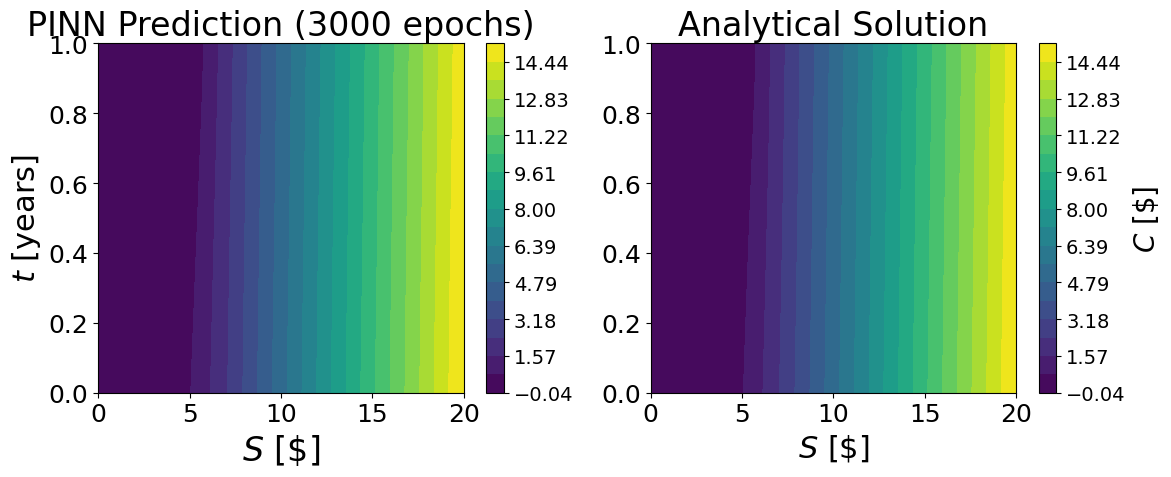

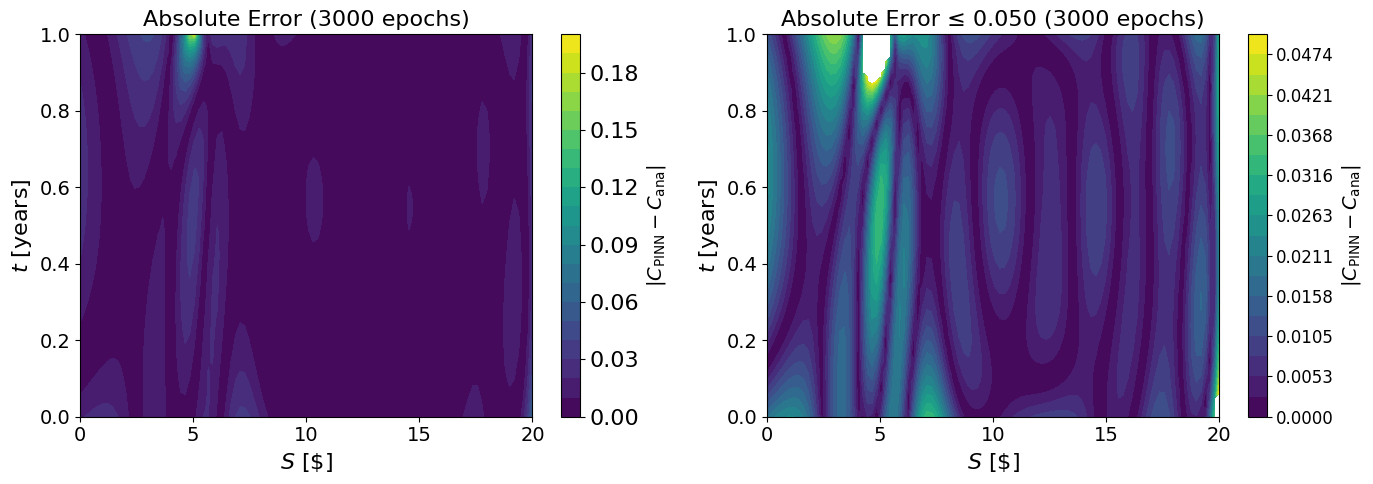

In [95]:


# Predict using trained model
with torch.no_grad():
    predicted_traditional = traditional_model(x_tensor_norm).cpu().numpy().reshape(S_mesh.shape)


# Plot comparison
plot_comparison(
    S_grid=S_mesh,
    t_grid=t_mesh,
    analytical=analytical,
    predicted=predicted_traditional,        
    save_path="results"                     
)

   



We see that the traditional model also performs well, but it struggles more close to the boundaries. The error at the terminal condition is present here as well. 

Finally we plot absolute error between analytical and traditional, and analytical and PINN to see their difference clearer. 

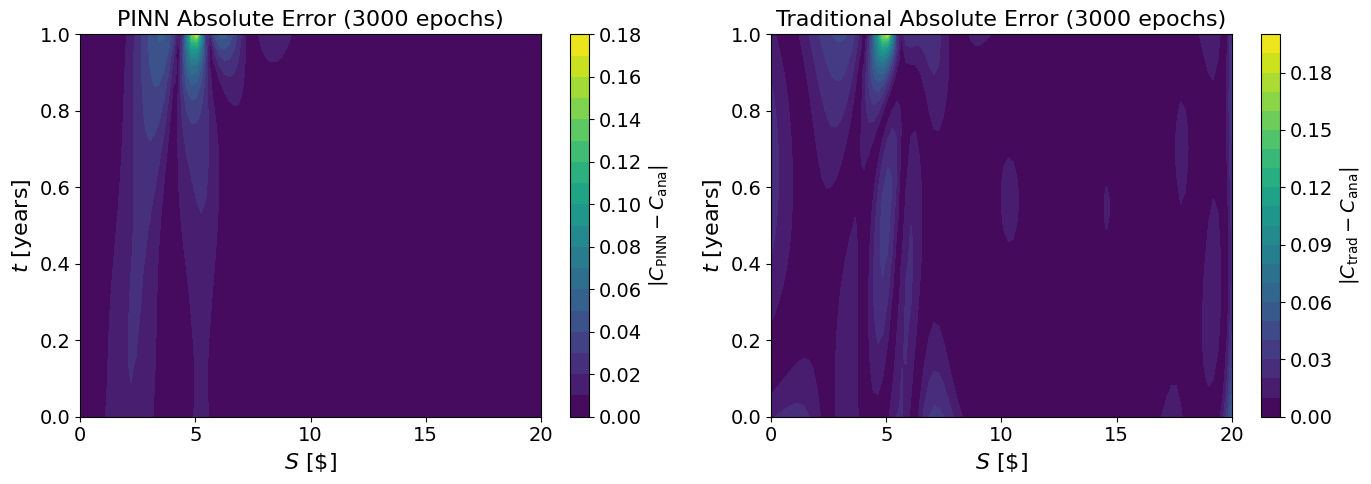

In [96]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
plt.rcParams.update({"font.size": 12})

# --- Left: PINN Absolute Error ---
abs_error_pinn = np.abs(predicted - analytical)
cf1 = axs[0].contourf(S_mesh, t_mesh, abs_error_pinn, levels=20, cmap="viridis")
cbar1 = fig.colorbar(cf1, ax=axs[0])
cbar1.set_label(r"$|C_{\rm PINN} - C_{\rm ana}|$", fontsize=14)
cbar1.ax.tick_params(labelsize=14)
axs[0].set_title("PINN Absolute Error (3000 epochs)", fontsize=16)
axs[0].set_xlabel(r"$S$ [\$]", fontsize=16)
axs[0].set_ylabel(r"$t$ [years]", fontsize=16)
axs[0].tick_params(axis="both", labelsize=14)

# --- Right: Traditional Absolute Error ---
abs_error_trad = np.abs(predicted_traditional - analytical)
cf2 = axs[1].contourf(S_mesh, t_mesh, abs_error_trad, levels=20, cmap="viridis")
cbar2 = fig.colorbar(cf2, ax=axs[1])
cbar2.set_label(r"$|C_{\rm trad} - C_{\rm ana}|$", fontsize=14)
cbar2.ax.tick_params(labelsize=14)
axs[1].set_title("Traditional Absolute Error (3000 epochs)", fontsize=16)
axs[1].set_xlabel(r"$S$ [\$]", fontsize=16)
axs[1].set_ylabel(r"$t$ [years]", fontsize=16)
axs[1].tick_params(axis="both", labelsize=14)

plt.tight_layout()




Here we see that both models experience the approximately the same maximal value for the absolute error. The PINN model outperforms the traditional model at both $S=0$ and $S=20$. Since the PINN model is trained explicitly on the boundary conditions of the equation it is expected that it actually performs better here. The PINN model also performs better where $S>10$, this may be due to the fact that in this region the PDE is satisfied well as the solution here is smooth and continuous. We also see that $S=20$ is a large enough $S$ value to accurately capture the asymptotic behavior as the model performs well on the right boundary. 

The traditional model performs alot better around $S = K = 5$. But both models struggle, which may be a result of the terminal condition being non-differentiable at $S = K$. A possible reason for why the PINN model struggles more is that the traditional model sees the actual solution around this kink, and the PINN does not. This may result in the error propagating more through (backwards) time for the PINN compared to the traditional.



Now we also plot the absolute error capped at a specific value to see if we can gain additional insight into the models' performance

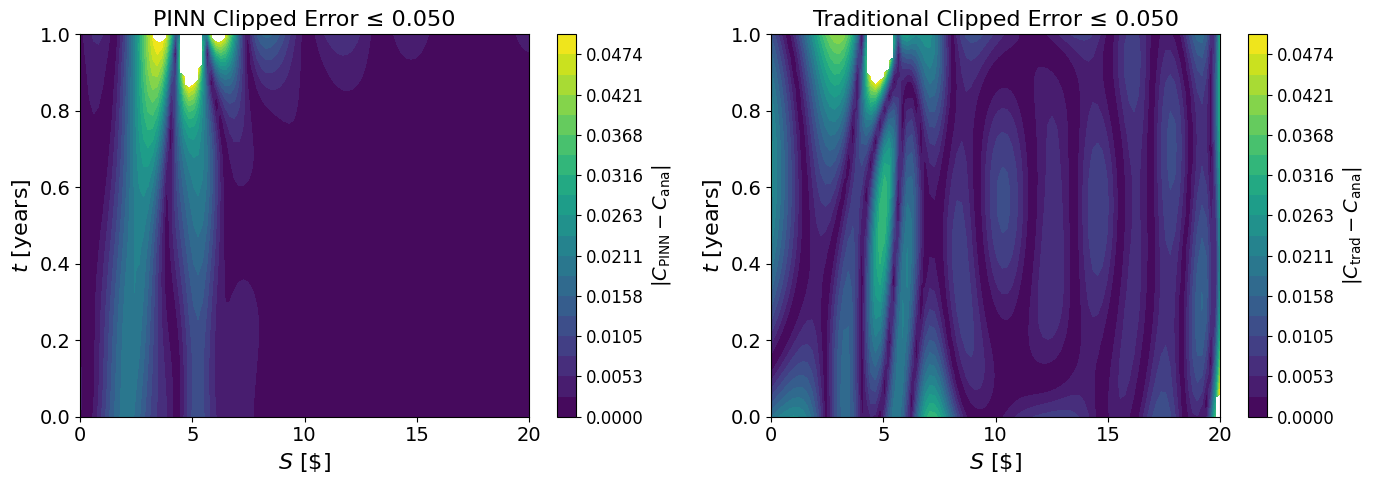

In [97]:
clip_point = 0.05
masked_pinn = np.ma.masked_where(abs_error_pinn > clip_point, abs_error_pinn)
masked_trad = np.ma.masked_where(abs_error_trad > clip_point, abs_error_trad)

cmap = plt.cm.viridis.copy()
cmap.set_bad("lightgrey")

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# --- Left: PINN Clipped Error ---
cf3 = axs[0].contourf(S_mesh, t_mesh, masked_pinn, levels=np.linspace(0, clip_point, 20), cmap=cmap)
cbar3 = fig.colorbar(cf3, ax=axs[0])
cbar3.set_label(r"$|C_{\rm PINN} - C_{\rm ana}|$", fontsize=14)
cbar3.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.4f"))
axs[0].set_title(f"PINN Clipped Error ≤ {clip_point:.3f}", fontsize=16)
axs[0].set_xlabel(r"$S$ [\$]", fontsize=16)
axs[0].set_ylabel(r"$t$ [years]", fontsize=16)
axs[0].tick_params(axis="both", labelsize=14)

# --- Right: Traditional Clipped Error ---
cf4 = axs[1].contourf(S_mesh, t_mesh, masked_trad, levels=np.linspace(0, clip_point, 20), cmap=cmap)
cbar4 = fig.colorbar(cf4, ax=axs[1])
cbar4.set_label(r"$|C_{\rm trad} - C_{\rm ana}|$", fontsize=14)
cbar4.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.4f"))
axs[1].set_title(f"Traditional Clipped Error ≤ {clip_point:.3f}", fontsize=16)
axs[1].set_xlabel(r"$S$ [\$]", fontsize=16)
axs[1].set_ylabel(r"$t$ [years]", fontsize=16)
axs[1].tick_params(axis="both", labelsize=14)

plt.tight_layout()


Again we see that the PINN model performs better in the right side of the domain. Both struggle in the left side, but the PINN struggles more. 

**Additional loss function for PINNs**

We will now define an additional loss function for the PINN model. This loss function will be a data loss, defined in the exact same way as the loss function for the traditional model above. We do this to see if we can obtain any performance gains. For fair comparison with our previous PINN model and the traditional neural net, we use an equal amount of points for this model as well. Only now we divide the $3000$ points previously used for the PDE loss on both PDE loss and data loss.

In [98]:
class LossFunctionsData():
    """
    Collection of loss function used to train a Physics-Informed Neural Network (PINN)
    for solving high-dimensional Black-Scholes-type PDEs.
    """
    def __init__(self, model, S_max, r=1.0, K=1.0, sigma=1.0, T=1.0):
        """
        Initializes loss functions for PDE training.

        Parameters:
            - model          (nn.Module): Neural network representing the PDE solution.
            - S_max_list       (list of float): Max value for the asset.
            - r                  (float): Risk-free interest rate.
            - K                  (float): Strike price of the option.
            - sigma              (float): Volatility for the asset.
            - T                  (float): Time to maturity.
        """
        self.model = model
        self.S_max = S_max
        self.r = r
        self.K = K
        self.T = T
        self.mse = nn.MSELoss()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.sigma = sigma




    def PDE_loss(self, input_tensor):
            """
            Computes the mean squared residual of the PDE.

            Parameters:
                - input_tensor (torch.Tensor): Normalized inputs (S_norm, t_norm)
            
            Returns:
                - torch.Tensor: Scalar PDE residual loss.
            """
            input_tensor = input_tensor.clone().requires_grad_(True)
            
            x_norm = input_tensor[:, :-1] 
            tau_norm = input_tensor[:, -1:] 
        
            X = torch.cat([x_norm, tau_norm], dim=1)
            X = X.float().requires_grad_()
    
            # Model prediction
            C = self.model(X)

            # Compute gradients
            dC = torch.autograd.grad(C, X, torch.ones_like(C), create_graph=True)[0]
            C_tau_norm = dC[:, -1:]  # ∂C/∂τ
            C_x_norm = dC[:, :-1]  # ∇C with respect to each asset
            
            # Denormalize asset prices and time
            S = 0.5 * (x_norm + 1.0) * self.S_max
            C_t = C_tau_norm * (-2.0 / self.T)   


            
    
            # Compute second derivative with respect to asset
            C_xx_norm = torch.autograd.grad(C_x_norm, x_norm, torch.ones_like(C_x_norm), create_graph=True)[0]

            # Denormalize first and second derivatives
            C_s = C_x_norm * (2.0 / self.S_max) 
            C_ss = C_xx_norm * ((2.0 / self.S_max)**2)

            # Compute PDE residual
            pde_residual = C_t + (0.5 * self.sigma**2 * S**2 * C_ss) + (self.r * C_s * S) - (self.r * C)

            return torch.mean(pde_residual**2)
    
    def TC_loss(self, tc):
        """
        Computes the loss for the terminal condition at maturity (t = T).

        Parameters:
            - tc (torch.Tensor): Normalized input tensor of shape (N, d+1), where the last column is t = T.

        Returns:
            - torch.Tensor: Mean squared error between model predictions and terminal payoff.
        """
        C_tc = self.model(tc)

        # Convert normalized inputs to real asset prices
        x_norm = tc[:, :-1]  
        S = (1 + x_norm) * self.S_max * 0.5

        # Compute the basket value (mean of asset prices) 
        basket = torch.mean(S, dim=1, keepdim=True) 
        true_tc = torch.maximum(basket - self.K, torch.zeros_like(basket))

        return self.mse(C_tc, true_tc)

    
    def LBC_loss(self, lbc):
        """
        Computes the loss for the left boundary condition where S_i = 0.

        Parameters:
            - lbc (torch.Tensor): Normalized tensor of shape (N, 1) for S_i = 0.
        

        Returns:
            - torch.Tensor: Mean squared error between model output and true boundary condition.
        """
        C_lbc = self.model(lbc)
     
        return torch.mean(C_lbc**2)
        

    def RBC_loss(self, rbc):
            """
            Computes the right boundary loss where S_i = S_max_i, which corresponds to the behavior as S_i → ∞.

            Parameters:
                - rbc (torch.Tensor): Right boundary data for asset i. Shape: (N, 1).
            
            Returns:
                - torch.Tensor: MSE loss between model output and expected boundary behavior.
            """
        
            C_rbc = self.model(rbc)  # Model prediction at boundary
            
            # Denormalize asset prices
            x_norm = rbc[:, :-1]     
            S = 0.5 * self.S_max*(x_norm + 1.0) 

            # Denormalize time and compute tau = T - t
            t_norm = rbc[:, -1:]  
            tau = self.T * (t_norm + 1) * 0.5 



            true_rbc = torch.maximum(S - self.K * torch.exp(-self.r * tau), torch.zeros_like(S))

            return self.mse(C_rbc,true_rbc)

    
    def data_loss(self, analytical_data):
        """
        Computes the loss for the analytical data points.

        Argument: 
            - analytical_data (torch.Tensor): Normalized input tensor of shape (N, d+1), where the last column is t.

        Returns:
            - torch.Tensor: Mean squared error between model predictions and analytical solution.
        """


        C_data = self.model(analytical_data)  # shape: (N, 1)


        # Normalize and compute real S and t values
        x_norm = analytical_data[:, :-1]
        t_norm = analytical_data[:, -1:]


        
        S = 0.5 * (1 + x_norm) * self.S_max
        # Flip time interpretation: t_norm = -1 → T, t_norm = 1 → 0 as we have terminal condition and solve backwards
        t = 0.5 * (1 - t_norm) * self.T



        true_solution = analytical_solution(S, self.K, self.T, t, self.r, self.sigma)
        true_solution = torch.tensor(true_solution, dtype=torch.float32).to(S.device) #convert to tensor



        
        return self.mse(C_data, true_solution)

At the bottom of the code you can now see that we have added the same data loss function as before. Now we also need to change the training class so that we will get a total loss function given by 

$$
\mathcal{L}_{\text{tot}} = \mathcal{L}_{\text{PDE}} + \mathcal{L}_{\text{TC}} + \mathcal{L}_{\text{LBC}} + \mathcal{L}_{\text{RBC}} + \mathcal{L}_{\text{DATA}}.
$$

In [99]:
class TrainingData(LossFunctionsData):
    """
    Training class for Physics-Informed Neural Networks (PINNs) applied to high-dimensional
    Black-Scholes-type PDEs. Inherits from the LossFunction class, which provides the
    loss definition for the terminal condition, boundary conditions, and PDE residual.
    """
    
    def __init__(self, model, S_max, r=1, K=1, sigma=1, T=1):
        """
        Initialize the Training class for PINN-based Black-Scholes training.

        Parameters:
            - model          (nn.Module): The neural network model.
            - S_max           (float): Max asset values for each dimension.
            - r                  (float): Risk-free interest rate.
            - K                  (float): Strike price.
            - sigma             (float): Volatility per asset.
            - T                  (float): Time to maturity.
        """
        super().__init__(model, S_max, r, K, sigma, T)

       

    def training_step_BS(self, lbc, rbc, tc, pde, data, optimizer):
        """
        Performs a single training step: computes all loss components, adapts weights,
        backpropagates the weighted loss, and updates model parameters.

        Parameters:
            - lbc                      (Tensor): Left boundary condition data (d, N, 2).
            - rbc                      (Tensor): Right boundary condition data (d, N, 2).
            - tc                       (Tensor): Terminal condition data (N, 2).
            - pde                      (Tensor): PDE interior sampling points (N, 2).
            - data                     (Tensor): PDE points for analytical solution loss (data loss) (N, 2).
            - optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
            - PINN_bool (bool): Flag to indicate if this is a PINN training step.
        
        Returns:
            - (tuple): Tuple containing:
                - total_loss      (Tensor): Total weighted loss.
                - pde_loss        (Tensor): PDE residual loss.
                - bc_left_total   (Tensor): Left boundary condition loss.
                - bc_right_total  (Tensor): Right boundary condition loss.
                - tc_loss         (Tensor): Terminal condition loss.
        
        """

      
        # Compute each component of the loss
        bc_left_total = self.LBC_loss(lbc)     # Tensor
        bc_right_total = self.RBC_loss(rbc)    # Tensor
        tc_loss = self.TC_loss(tc)
        data_loss = self.data_loss(data)        # Tensor
        pde_loss = self.PDE_loss(pde)

        # Combine losses (you can adjust weights if needed)
        total_loss = pde_loss + bc_left_total + bc_right_total + tc_loss + data_loss

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        return total_loss, pde_loss, bc_left_total, bc_right_total, tc_loss, data_loss
    

    def training_cycle_BS(self, N_epochs, lbc, rbc, tc, pde, data, optimizer):
        """
        Full traning cycle with checkpointing of best model.

        Parameters:
            - N_epochs                       (int): Number of training epochs.
            - lbc                         (Tensor): Left boundary condition training data.
            - rbc                         (Tensor): Right boundary condition training data.
            - tc                          (Tensor): Terminal condition training data.
            - pde                         (Tensor): PDE interior point training data.
            - data                     (Tensor): PDE points for analytical solution loss (data loss) (N, 2).
            - optimizer    (torch.optim.Optimizer): Optimizer instance.
        
        Returns:
            - (tuple): Tuple containing:
                - train_loss       (list): Total training loss per epoch.
                - train_epochs     (list): Epoch indices for training.
                - best_model_state (dict): Model weights with lowest validation loss.
        """
        # Lists to store training and validation results
        loss, epochs = [], []

        #For checkpointing
        best_loss = float("inf")
        best_model_state = None 
    
        #Start training loop      
        for epoch in range(N_epochs):       
            self.model.train() #put model in training mode           

            
            # Run single training step
            total_loss, pde_loss, lbc_loss, rbc_loss, tc_loss, data_loss = self.training_step_BS(
                lbc, rbc, tc, pde, data,
                optimizer
            )

            loss.append(total_loss.item())
            epochs.append(epoch)

            if epoch % 10 == 0 or epoch == N_epochs - 1:
                print(f"Epoch {epoch+1}/{N_epochs}, "
                    f"Total Loss: {total_loss.item():.4f}, "
                    f"PDE Loss: {pde_loss.item():.4f}, "
                    f"LBC Loss: {lbc_loss.item():.4f}, "
                    f"RBC Loss: {rbc_loss.item():.4f}, "
                    f"TC Loss: {tc_loss.item():.4f},   "
                    f"Data Loss: {data_loss.item():.4f}")


            # Checkpointing: save model if validation loss improves
            if total_loss < best_loss:
                best_loss = total_loss
                best_model_state = self.model.state_dict()
         

        # Save the best model state
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)

        return loss, epochs

Now we have implemented all we need for the additional data loss function. We now train a new model. 

In [100]:
model_data_1 = Model(2, [32, 32, 32], activation_function=nn.Tanh()) #initialize model with 3 hidden layers, 32 nodes in each
optimizer_1 = torch.optim.Adam(model_data_1.parameters(), lr=1e-2)

#initialize training object 
trainer = TrainingData(model_data_1, S_max, r, K, sigma, T)
#Initilize data 
num_lbc_points = 300 #number of points for left boundary condition 
num_rbc_points = 300 #number of points for right boundary condition 
num_tc_points = 500 #number of points for terminal condition 
num_pde_points = 1500 #number of collocation points
num_data_points = 1500 #number of collocation points for analytical solution loss
data_initializer = InitializeData(S_max, T)
lbc_1 = data_initializer.data_lbc(num_lbc_points, 32) #tensor with lbc data
rbc_1 = data_initializer.data_rbc(num_rbc_points, 33) #tensor with rbc data
tc_1 = data_initializer.data_tc(num_tc_points, 34) #tensor with rc data
pde_1 = data_initializer.data_pde(num_pde_points, 35) #tensor with pde data
data_1 = data_initializer.data_pde(num_data_points, 37)



#train model
loss, epochs= trainer.training_cycle_BS(N_epochs, lbc_1, rbc_1, tc_1, pde_1, data_1,
                                                              optimizer_1)

/var/folders/1n/kcxtjkk14hnb_vt5xqdg7zwr0000gn/T/ipykernel_54230/4185607999.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  tau = np.maximum(T - t, 0)
/var/folders/1n/kcxtjkk14hnb_vt5xqdg7zwr0000gn/T/ipykernel_54230/4185607999.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sqrt_tau = np.sqrt(tau[mask])
/var/folders/1n/kcxtjkk14hnb_vt5xqdg7zwr0000gn/T/ipykernel_54230/4185607999.py:36: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  d_plus  = (np.log(S[mask] / K) + (r + 0.5 * sigma**2) * tau[mask]) / (sigma * sqrt_tau)
/var/folders/1n/kcxtjkk14hnb_vt5xqdg7zwr0000gn/T/ipykernel_54230/4185607999.py:41: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the futu

Epoch 1/3000, Total Loss: 343.1694, PDE Loss: 2.7254, LBC Loss: 0.0836, RBC Loss: 222.8665, TC Loss: 60.9767,   Data Loss: 56.5171
Epoch 11/3000, Total Loss: 97.6146, PDE Loss: 6.3317, LBC Loss: 50.5497, RBC Loss: 23.3147, TC Loss: 6.7902,   Data Loss: 10.6284
Epoch 21/3000, Total Loss: 43.4651, PDE Loss: 6.1597, LBC Loss: 3.1950, RBC Loss: 13.3736, TC Loss: 7.2597,   Data Loss: 13.4770
Epoch 31/3000, Total Loss: 14.0533, PDE Loss: 1.2077, LBC Loss: 4.6393, RBC Loss: 6.2575, TC Loss: 0.8707,   Data Loss: 1.0780
Epoch 41/3000, Total Loss: 4.0862, PDE Loss: 1.4434, LBC Loss: 0.3742, RBC Loss: 0.7842, TC Loss: 0.8397,   Data Loss: 0.6447
Epoch 51/3000, Total Loss: 1.9546, PDE Loss: 0.7049, LBC Loss: 0.0127, RBC Loss: 0.5303, TC Loss: 0.4511,   Data Loss: 0.2556
Epoch 61/3000, Total Loss: 1.2298, PDE Loss: 0.4621, LBC Loss: 0.0284, RBC Loss: 0.4071, TC Loss: 0.1946,   Data Loss: 0.1378
Epoch 71/3000, Total Loss: 0.7690, PDE Loss: 0.3147, LBC Loss: 0.0339, RBC Loss: 0.1782, TC Loss: 0.1465,

We now plot the absolute error

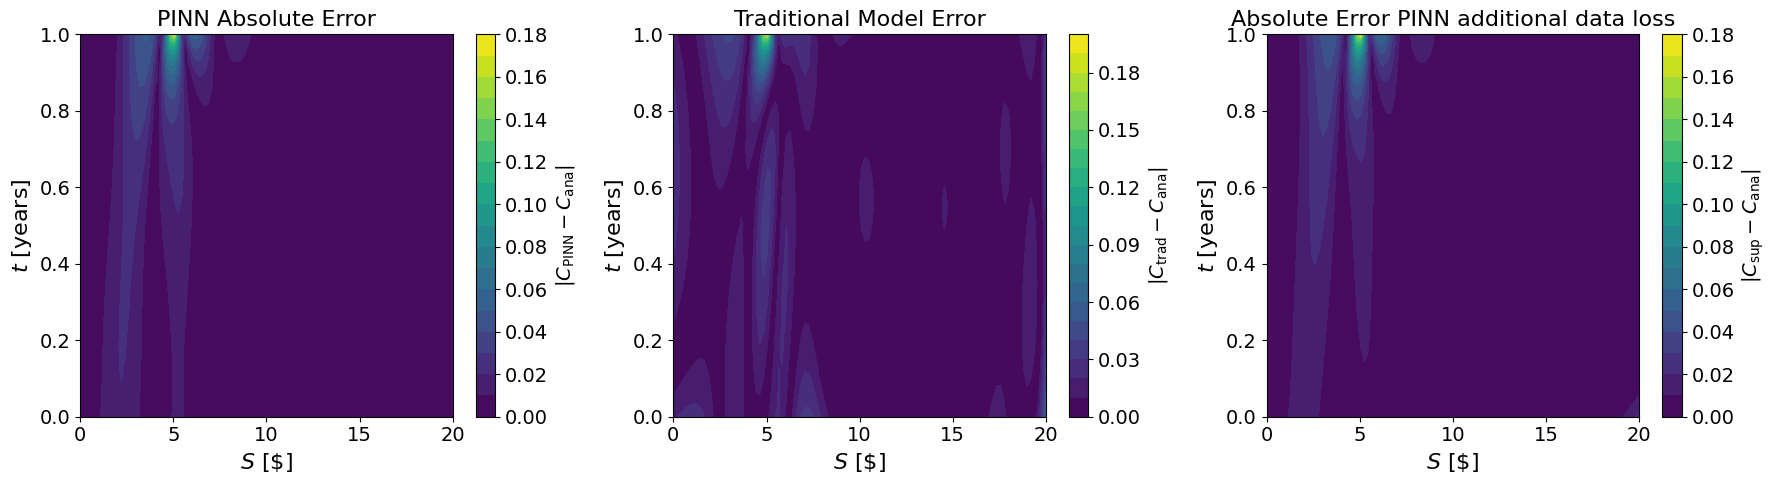

In [101]:
# --- after computing predicted_data ---
with torch.no_grad():
    predicted_data_1 = model_data_1(x_tensor_norm).cpu().numpy().reshape(S_mesh.shape)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
plt.rcParams.update({"font.size": 12})

# --- Left: PINN Absolute Error ---
abs_error_pinn = np.abs(predicted - analytical)
cf1 = axs[0].contourf(S_mesh, t_mesh, abs_error_pinn, levels=20, cmap="viridis")
cbar1 = fig.colorbar(cf1, ax=axs[0])
cbar1.set_label(r"$|C_{\rm PINN} - C_{\rm ana}|$", fontsize=14)
cbar1.ax.tick_params(labelsize=14)
axs[0].set_title("PINN Absolute Error", fontsize=16)
axs[0].set_xlabel(r"$S$ [\$]", fontsize=16)
axs[0].set_ylabel(r"$t$ [years]", fontsize=16)
axs[0].tick_params(axis="both", labelsize=14)

# --- Middle: Traditional Absolute Error ---
abs_error_trad = np.abs(predicted_traditional - analytical)
cf2 = axs[1].contourf(S_mesh, t_mesh, abs_error_trad, levels=20, cmap="viridis")
cbar2 = fig.colorbar(cf2, ax=axs[1])
cbar2.set_label(r"$|C_{\rm trad} - C_{\rm ana}|$", fontsize=14)
cbar2.ax.tick_params(labelsize=14)
axs[1].set_title("Traditional Model Error", fontsize=16)
axs[1].set_xlabel(r"$S$ [\$]", fontsize=16)
axs[1].set_ylabel(r"$t$ [years]", fontsize=16)
axs[1].tick_params(axis="both", labelsize=14)

# --- Right: Additional Data loss Absolute Error ---
abs_error_1 = np.abs(predicted_data_1 - analytical)
cf3 = axs[2].contourf(S_mesh, t_mesh, abs_error_1, levels=20, cmap="viridis")
cbar3 = fig.colorbar(cf3, ax=axs[2])
cbar3.set_label(r"$|C_{\rm sup} - C_{\rm ana}|$", fontsize=14)
cbar3.ax.tick_params(labelsize=14)
axs[2].set_title("Absolute Error PINN additional data loss", fontsize=16)
axs[2].set_xlabel(r"$S$ [\$]", fontsize=16)
axs[2].set_ylabel(r"$t$ [years]", fontsize=16)
axs[2].tick_params(axis="both", labelsize=14)

plt.tight_layout()
plt.show()



We see that performance increased when adding the new data loss function compared to the previous PINN model. Some areas of high absolute error decreased around $S = K = 5$. Especially the propagation of error in time at around $S=4$. This fits with our description that the data loss function makes the model see the actual solution, so the error do not propagate as much. 


To sum up: we now have three different models. They were all trained with the same number of epochs and number of data points. 

1. PINN without data loss, corresponds to model
2. Traditional Model with only data loss, corresponds to traditional_model. 
3. PINN with additional data loss component, different data for the data loss and the pde loss, corresponds to model_data_1


We see that all PINN models have different geometry in the heatmaps than the traditional model. The PINN models generally perform better on the right side of the domain than the traditional model, but the traditional model perform better than they do in the left side of the domain where we find the kink in the solution at $S = K$ and $t=T$. The errors from this kink which both traditional and PINN experience seem to propagate more in the PINN models. Finally we calculate the sum of the absolute errors on the domain for all three models.

In [ ]:
print("mean absolute error over the domain:")
print("__________________________")
print("PINN with data loss:")
print(sum(abs_error_1.flatten())/ len(abs_error_1.flatten()))
print("__________________________")
print("PINN without data loss:")
print(sum(abs_error_pinn.flatten())/ len(abs_error_pinn.flatten()))
print("__________________________")
print("Traditional neural network:")
print(sum(abs_error_trad.flatten()) / len(abs_error_trad.flatten()))




sum of absolute errror in all points, divided by number of points
__________________________
PINN with data loss:
0.005290074229471434
__________________________
PINN without data loss:
0.005197012388524498
__________________________
Traditional neural network:
0.008293590158631675


We see performance of same magnitude for all models, but the PINN models perform  better! 

#### Experiments 

To optimize our model we need to find the best hyperparameters, such as network depth and width, and the best activation function. 
We will continute to work with a PINN model without a data loss function, as the performance were similar and the code developed for our project was developed for no data loss. Feel free to test out how a model with a dataloss also performs after hyperparameter optimization. 


**Activation Function**


Activation functions play an important role in neural networks by introducing non‑linearity. They map the outputs of neurons into a range that is easier to work with, helping the network learn complex patterns. Up until this moment we have only used tanh, this has been done for simplicity and introducing the reader to proejct. We will now perform experiments with both tanh and the GELU activation function for solving the Black–Scholes equation. Since PINNs require first and second derivatives, we have chosen smooth, twice‑differentiable activations.

---

**1. Gaussian Error Linear Unit (GELU)**

The GELU activation is defined as:

$$
\mathrm{GELU}(x) = x \,\Phi(x)
= x \cdot \frac12 \Bigl(1 + \operatorname{erf}\bigl(\tfrac{x}{\sqrt2}\bigr)\Bigr),
$$

where

$$
\operatorname{erf}(x) = \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2}\,dt.
$$
This non‑monotonic activation can help capture complex, non‑linear patterns. 

Its derivative is:

$$
\frac{d}{dx}\,\mathrm{GELU}(x)
= \Phi(x)
\;+\; x \cdot \frac12 \sqrt{\frac{2}{\pi}} \,e^{-x^2/2}.
$$



---

**2. Hyperbolic Tangent (tanh)**

The tanh activation is defined as:

$$
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}.
$$

Its derivative is:

$$
\frac{d}{dx}\,\tanh(x) = 1 - \tanh^2(x).
$$

As $x\to+\infty$, $\tanh(x)\to1$, and as $x\to-\infty$, $\tanh(x)\to-1$. In the regions of saturation (large $|x|$), the gradient vanishes, which can slow or halt learning. However, tanh’s zero‑centered output often leads to more balanced gradients and improved training stability.

---


**Network depth and width**

Increasing the width (number of neurons in each layer) and the depth (number of hidden layers) can increase a neural networks representational capacity. 
Making a network wider may allow the network to learn hierarchical features of a solution, such as edges and shapes. One possible downside of deep networks is that they sometimes can cause vanishing gradients as more hidden layers means more multiplications in the gradient chains. 
Wider networks can help the network learn parallell features of a solution as the neurons in the given layer can learn different features, though one can run the risk of overfitting the data. 
In addition increasing width and depth will also increase computation time. We there experiment with both 32 nodes in each layer and 64 in each layer. For the depth we will consider 3 and 4 layers. 




**Learning rate**

Lastly we will consider the learning rate of the model. The learning rate determines how much the model’s parameters are updated in response to the gradient of the total loss function during training. If the learning rate is too
large, the network can experience convergence problems
and fluctuations in the loss function. On the other hand,
if the learning rate is too small the model will require
many epochs to converge and it may get stuck in local
minima. We will consider learning rates of $10^{-2}$ and $10^{-3}$. 


##### The experiments

We will run sixteen experiments in total, as we have two activation functions, two different depths, two different widths and two learning rates to check. We thus check all combinations of the four aforementioned hyperparameters. When performing such sweeps of the hyperparameter space one usually conducts many more simulations and configurations. If you want to check more hyperparameters feel free to add more elements to either of the lists containing the hyperparameters.

Another important thing to note is that the best configuration when running with few epochs (as we do), may not be the best when running with more epochs. This is because different configurations can have different convergence properties. Again feel free to use more epochs to get a more accurate answer for the best configuration. 

As we now are interested in obtaining the best model configuration we also implement a validation (evaluation) step in our Training class. This method will keep track of the models performance in each epoch on completely new data. 

In [103]:
class Training(LossFunctions):
    """
    PINN training with per-epoch validation and early stopping.
    """

    def __init__(self, model, S_max_list, r=1, K=1, sigma=1, T=1):
        super().__init__(model, S_max_list, r, K, sigma, T)

    def training_step_BS(self, lbc, rbc, tc, pde, optimizer):
        # single train step on one batch (or full set)
        bc_left  = self.LBC_loss(lbc)
        bc_right = self.RBC_loss(rbc)
        tc_loss  = self.TC_loss(tc)
        pde_loss = self.PDE_loss(pde)
        total    = bc_left + bc_right + tc_loss + pde_loss

        optimizer.zero_grad()
        total.backward()
        optimizer.step()
        return total

    def evaluate_BS(self, lbc, rbc, tc, pde):
        # pure eval step (no grads, no updates)
        self.model.eval()
        with torch.no_grad():
            bc_left  = self.LBC_loss(lbc)
            bc_right = self.RBC_loss(rbc)
            tc_loss  = self.TC_loss(tc)
        pde_loss = self.PDE_loss(pde)
        total    = bc_left + bc_right + tc_loss + pde_loss

        return {
            "total": total.item(),
            "pde":   pde_loss.item(),
            "lbc":   bc_left.item(),
            "rbc":   bc_right.item(),
            "tc":    tc_loss.item()
        }

    def training_cycle_BS(
        self,
        N_epochs,
        train_lbc, train_rbc, train_tc, train_pde,
        optimizer,
        val_lbc=None, val_rbc=None, val_tc=None, val_pde=None,
        print_epochs=True
    ):
        """
        Full training loop with per-epoch validation, checkpointing, and optional early stopping.

        Returns:
            train_history (list[float])
            val_history   (list[float]) or None if no val set
            best_state    (dict)     checkpointed weights
        """
        best_val_loss = float('inf')
        best_state    = None
        wait          = 0

        train_history = []
        val_history   = [] if val_lbc is not None else None

        for epoch in range(1, N_epochs+1):
            # Training
            self.model.train()
            train_loss = self.training_step_BS(
                train_lbc, train_rbc, train_tc, train_pde, optimizer
            )
            train_history.append(train_loss.item())

            # Validation
            if val_lbc is not None:
                metrics = self.evaluate_BS(val_lbc, val_rbc, val_tc, val_pde)
                val_history.append(metrics['total'])

                # Checkpoint on improvement
                if metrics['total'] < best_val_loss:
                    best_val_loss = metrics['total']
                    best_state    = self.model.state_dict()
                    wait = 0
                else:
                    wait += 1

            # Logging 
            if print_epochs and (epoch % 10 == 0 or epoch == N_epochs):
                msg = f"Epoch {epoch}/{N_epochs}: train={train_history[-1]:.4f}"
                if val_history is not None:
                    msg += f", val={val_history[-1]:.4f}"
                print(msg)



        # Restore best weights (if any)
        if best_state is not None:
            self.model.load_state_dict(best_state)

        return train_history, val_history


In [104]:
import itertools


# === Hyper‑parameter grid ===
widths      = [32, 64]
depths      = [3, 4]
lrs         = [1e-2, 1e-3]
activations = [nn.Tanh(), nn.GELU()]

N_epochs    = 3000


results     = []
best_val    = float('inf')
best_config = None

# Validation sizes
num_val_lbc = num_lbc_points
num_val_rbc = num_rbc_points
num_val_tc  = num_tc_points
num_val_pde = num_pde_points

# Initialize validation data generator
val_data = InitializeData(S_max, T)

for width, depth, lr, activation in itertools.product(widths, depths, lrs, activations):
    print(f"→ width={width}, depth={depth}, lr={lr}, act={activation.__class__.__name__}")

    # Build model, optimizer, trainer
    model     = Model(2, [width]*depth, activation_function=activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    trainer   = Training(model, S_max, r, K, sigma, T)

    # Prepare one fixed validation set (or regenerate each epoch inside trainer)
    val_lbc = val_data.data_lbc(num_val_lbc, seed=384)
    val_rbc = val_data.data_rbc(num_val_rbc, seed=859)
    val_tc  = val_data.data_tc(num_val_tc,   seed=144)
    val_pde = val_data.data_pde(num_val_pde, seed=139)

    # === Train + validate per epoch, with early stopping ===
    train_hist, val_hist = trainer.training_cycle_BS(
        N_epochs,
        train_lbc=lbc, train_rbc=rbc, train_tc=tc, train_pde=pde,
        optimizer=optimizer,
        val_lbc=val_lbc, val_rbc=val_rbc, val_tc=val_tc, val_pde=val_pde,
        print_epochs=False,
    )

    # After this call, trainer.model has been reset to best_state internally.
    final_val = val_hist[-1]
    print(f"    → Final validation loss = {final_val:.6e}\n")

    # Track best overall
    if final_val < best_val:
        best_val    = final_val
        best_config = {
            'width':      width,
            'depth':      depth,
            'lr':         lr,
            'activation': activation.__class__.__name__
        }

    results.append({
        'loss':       final_val,
        'width':      width,
        'depth':      depth,
        'lr':         lr,
        'activation': activation.__class__.__name__
    })

# === Summary ===
print("=== Best configuration by validation loss ===")
print(f" Width       : {best_config['width']}")
print(f" Depth       : {best_config['depth']}")
print(f" Learning R. : {best_config['lr']}")
print(f" Activation  : {best_config['activation']}")
print(f" Val loss    : {best_val:.6e}")




→ width=32, depth=3, lr=0.01, act=Tanh
    → Final validation loss = 1.813792e-03

→ width=32, depth=3, lr=0.01, act=GELU


KeyboardInterrupt: 

We see here that a learning rate of 0.01 performs better than that of 0.001. Running with more epochs would likely yield lower validation losses for a learning rate of 0.001. Try a simulation with more epochs and see if its true! We will go for a learning rate 0.01, width 32, depth 3 and tanh activation function as this will mean faster running times. The tanh is chosen because we are all familiar with it and it performs generally just as well as GELU in our simulations above. 

#### More experiments
##### Batch training 

We will now introduce a new hyperparameter to tune: batch size. After initializing and normalizing the data, we implement mini-batch training, where each of the datasets (LBC, RBC, PDE, and TC) are split into batches based on a specified batch size.
During training, each step computes the gradient using one batch from each of the LBC, RBC, PDE, and TC datasets. One epoch is defined as a full pass through all batches for the PDE dataset. 
Mini-batch training often introduces stochasticity in the gradient estimation, which can act as a form of implicit regularization. Since each update is based on a subset of the data, the model may generalize better than if trained on the full dataset at each step.
On the other hand, using the entire dataset (i.e., full-batch training) generally provides a more accurate estimate of the gradient, but is more computationally expensive.
To explore the effect of batch size, we experiment with different numbers of batches (i.e., different batch sizes) for the same total number of data points across the LBC, RBC, PDE, and TC datasets.
We will reuse the previously defined Training class, now extended with support for mini-batch training.

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from itertools import cycle
import torch

class Training(LossFunctions):
    """
    PINN training with mini-batch, per-epoch validation, checkpointing, and optional early stopping.
    """

    def __init__(self, model, S_max_list, r=1, K=1, sigma=1, T=1):
        super().__init__(model, S_max_list, r, K, sigma, T)

    def training_step_BS(self, lbc, rbc, tc, pde, optimizer):
        # single train step on one batch
        bc_left  = self.LBC_loss(lbc)
        bc_right = self.RBC_loss(rbc)
        tc_loss  = self.TC_loss(tc)
        pde_loss = self.PDE_loss(pde)
        total    = bc_left + bc_right + tc_loss + pde_loss

        optimizer.zero_grad()
        total.backward()
        optimizer.step()
        return total

    def evaluate_BS(self, lbc, rbc, tc, pde):
        # pure eval step (no grads, no updates)
        self.model.eval()
        with torch.no_grad():
            bc_left  = self.LBC_loss(lbc)
            bc_right = self.RBC_loss(rbc)
            tc_loss  = self.TC_loss(tc)
        pde_loss = self.PDE_loss(pde)
        total    = bc_left + bc_right + tc_loss + pde_loss

        return {
            "total": total.item(),
            "pde":   pde_loss.item(),
            "lbc":   bc_left.item(),
            "rbc":   bc_right.item(),
            "tc":    tc_loss.item()
        }

    def training_cycle_BS(
        self,
        N_epochs,
        train_lbc, train_rbc, train_tc, train_pde,
        optimizer,
        batch_size=None,
        val_lbc=None, val_rbc=None, val_tc=None, val_pde=None,
        print_epochs=True
    ):
        """
        Full training loop with mini-batch for each dataset, per-epoch validation, checkpointing.

        Returns:
            train_history (list[float])
            val_history   (list[float]) or None if no val set
            best_state    (dict)     checkpointed weights
        """
        # Prepare DataLoaders for each dataset
        if batch_size is not None:
            lbc_loader = DataLoader(train_lbc, batch_size=batch_size, shuffle=True)
            rbc_loader = DataLoader(train_rbc, batch_size=batch_size, shuffle=True)
            tc_loader  = DataLoader(train_tc,  batch_size=batch_size, shuffle=True)
            pde_loader = DataLoader(train_pde, batch_size=batch_size, shuffle=True)
        else:
            # full-batch single iteration
            lbc_loader = [(train_lbc,)]
            rbc_loader = [(train_rbc,)]
            tc_loader  = [(train_tc,)]
            pde_loader = [(train_pde,)]

        best_val_loss = float('inf')
        best_state    = None
       

        train_history = []
        val_history   = [] if val_lbc is not None else None

        for epoch in range(1, N_epochs+1):
            # Training
            self.model.train()
            epoch_loss = 0.0

            # Create cycling iterators for BC and TC loaders
            lbc_cycle = cycle(lbc_loader)
            rbc_cycle = cycle(rbc_loader)
            tc_cycle  = cycle(tc_loader)

            # Iterate over all PDE batches, recycling BC and TC as needed
            for pde_batch in pde_loader:
                # extract if wrapped in tuple
                pde_b = pde_batch[0] if isinstance(pde_batch, tuple) else pde_batch
                lbc_batch = next(lbc_cycle)
                rbc_batch = next(rbc_cycle)
                tc_batch  = next(tc_cycle)

                lbc_b = lbc_batch[0] if isinstance(lbc_batch, tuple) else lbc_batch
                rbc_b = rbc_batch[0] if isinstance(rbc_batch, tuple) else rbc_batch
                tc_b  = tc_batch[0]  if isinstance(tc_batch, tuple)  else tc_batch

                loss = self.training_step_BS(lbc_b, rbc_b, tc_b, pde_b, optimizer)
                epoch_loss += loss.item()

            # Average training loss over PDE batches
            avg_train = epoch_loss / len(pde_loader)
            train_history.append(avg_train)

            # Validation
            if val_lbc is not None:
                metrics = self.evaluate_BS(val_lbc, val_rbc, val_tc, val_pde)
                val_history.append(metrics['total'])

                # Checkpoint on improvement
                if metrics['total'] < best_val_loss:
                    best_val_loss = metrics['total']
                    best_state    = self.model.state_dict()
                  

            # Logging
            if print_epochs and (epoch % 100 == 0 or epoch == N_epochs):
                msg = f"Epoch {epoch}/{N_epochs}: train={avg_train:.4f}"
                if val_history is not None:
                    msg += f", val={val_history[-1]:.4f}"
                print(msg)

        # Restore best weights
        if best_state is not None:
            self.model.load_state_dict(best_state)

        return train_history, val_history


In [ ]:

# === Fixed Hyperparameters ===
width       = 32
depth       = 3
lr          = 1e-2
activation  = nn.Tanh()
N_epochs    = 1000

# Batch sizes to test
batch_sizes = [16, 32, 64, 128, None]

results      = []
best_val     = float('inf')
best_config  = None

#initialize training object 

#Initilize data 
num_lbc_points = 300 #number of points for left boundary condition 
num_rbc_points = 300 #number of points for right boundary condition 
num_tc_points = 500 #number of points for terminal condition 
num_pde_points = 3000 #number of collocation points





data_initializer = InitializeData(S_max,T)

#Training data
lbc = data_initializer.data_lbc(num_lbc_points, seed=8)
rbc = data_initializer.data_rbc(num_rbc_points, seed=787)
tc = data_initializer.data_tc(num_tc_points, seed=466)
pde = data_initializer.data_pde(num_pde_points, seed=987)

#Validation data, use same number of validation data points
lbc_val = data_initializer.data_lbc(num_lbc_points, seed=5)
rbc_val = data_initializer.data_rbc(num_rbc_points, seed=328)
tc_val = data_initializer.data_tc(num_tc_points, seed=2939)
pde_val = data_initializer.data_pde(num_pde_points, seed=139)

# Initialize validation data generator
val_data = InitializeData(S_max, T)

for batch_size in batch_sizes:
    print(f"\n=== Training with batch_size = {batch_size} ===")

    # Build model + optimizer + trainer
    model     = Model(2, [width] * depth, activation_function=activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    trainer   = Training(model, S_max, r, K, sigma, T)

    # Train and validate per epoch 
    train_hist, val_hist = trainer.training_cycle_BS(
        N_epochs,
        lbc, rbc, tc, pde,
        optimizer,
        batch_size,
        val_lbc=val_lbc,
        val_rbc=val_rbc,
        val_tc=val_tc,
        val_pde=val_pde,
    )

    # Compute best (minimum) losses observed during training and validation
    best_train = min(train_hist)
    best_val_i = min(val_hist) if val_hist is not None else float('nan')

    print(f"→ Best training   loss = {best_train:.6f}")
    print(f"→ Best validation loss = {best_val_i:.6f}")

    # Track best overall by validation loss
    if best_val_i < best_val:
        best_val    = best_val_i
        best_config = batch_size

    results.append({
        'batch_size': batch_size,
        'best_train_loss': best_train,
        'best_val_loss':   best_val_i
    })

# === Summary ===
print("\n=== Best batch size by validation loss ===")
print(f"Batch size     : {best_config}")
print(f"Validation loss: {best_val:.6f}")





=== Training with batch_size = 16 ===
Epoch 100/1000: train=0.0148, val=0.0167
Epoch 200/1000: train=0.0027, val=0.0021
Epoch 300/1000: train=0.0013, val=0.0005
Epoch 400/1000: train=0.0032, val=0.0056
Epoch 500/1000: train=0.0016, val=0.0012
Epoch 600/1000: train=0.0329, val=0.0024
Epoch 700/1000: train=0.1197, val=0.0044
Epoch 800/1000: train=0.0228, val=0.0028
Epoch 900/1000: train=0.0087, val=0.0017
Epoch 1000/1000: train=0.0015, val=0.0013
→ Best training   loss = 0.000644
→ Best validation loss = 0.000294

=== Training with batch_size = 32 ===
Epoch 100/1000: train=0.0083, val=0.0087
Epoch 200/1000: train=0.0038, val=0.0017
Epoch 300/1000: train=0.0077, val=0.0024
Epoch 400/1000: train=0.0032, val=0.0011
Epoch 500/1000: train=0.0016, val=0.0010
Epoch 600/1000: train=0.0026, val=0.0009
Epoch 700/1000: train=0.0045, val=0.0077
Epoch 800/1000: train=0.0005, val=0.0004
Epoch 900/1000: train=0.0095, val=0.0033
Epoch 1000/1000: train=0.0010, val=0.0022
→ Best training   loss = 0.00023

In [ ]:
print(results)

[{'batch_size': 16, 'best_train_loss': 0.0006437725905345089, 'best_val_loss': 0.00029367487877607346}, {'batch_size': 32, 'best_train_loss': 0.00023527444662907695, 'best_val_loss': 0.00022083206567913294}, {'batch_size': 64, 'best_train_loss': 0.00029715206186123626, 'best_val_loss': 0.00025632549659349024}, {'batch_size': 128, 'best_train_loss': 0.00033163792856309254, 'best_val_loss': 0.0003231350565329194}, {'batch_size': None, 'best_train_loss': 0.004822739399969578, 'best_val_loss': 0.005014221183955669}]


When printing results as above we see that all batch_sizes have similar performance, with sizes of 16 and 32 achieving the lowest validation losses. 
Generally large batch sizes converge faster, so the smaller batch sizes may perform even better when running with more epochs! 
We also see that with no batch training (as we have previously trained our model) performance is significantly worse. Since performance is similar for all the four batch sizes we test, we choose a batch size of 128 for computational efficiency. 

#### Weighting of loss functions

When training a neural network with multiple loss functions, one of the loss components might end up much larger than the others. If we do not address this, the network will mostly focus on reducing the bigger loss and ignore the smaller ones. To balance the losses, we can assign weights to each one, which helps the network treat all losses more equally and learn everything it is supposed to.

One way to weight the losses is to manually choose the weights, but it is difficult to know which ones will result in a better model without running many simulations. Another approach is to let the model automatically adjust the weights, for example, by looking at the gradients of each loss and using them to scale the losses. This ensures that the size of the gradients of each loss function is equal, which prevents the model from focusing too much on reducing certain losses during training.

The weight for the *i*-th loss function, where the hat indicates the computed value, is given by:

$$
\hat{\lambda}_i = \frac{ \sum_{j} \left\| \nabla_{\theta} \mathcal{L}_j \right\| }{ \left\| \nabla_{\theta} \mathcal{L}_i \right\| },
$$

where $\|\cdot\|$ denotes the L2 norm, and $\theta$ represents the model's trainable parameters. Instead of directly using the newly calculated $\hat{\lambda}_i$ for each loss, we update the weights using a moving average with the following rule:

$$
\lambda_i^{\text{new}} = \alpha \lambda_i^{\text{old}} + (1 - \alpha) \hat{\lambda}_i,
$$

where $\alpha$ defines the balance between the new values and the old values. Doing it this way smooths out the updates, which prevents sudden jumps in the weight values.



Our new total loss function will then be: 
$$
\mathcal{L}_{\text{tot}} = \lambda_1 \mathcal{L}_{\text{PDE}} +  \lambda_2 \mathcal{L}_{\text{TC}} +  \lambda_3 \mathcal{L}_{\text{LBC}} +  \lambda_4 \mathcal{L}_{\text{RBC}} 
$$


We implement this by changing our Training class. 

In [ ]:
import torch
from torch.autograd import grad
from torch.utils.data import DataLoader
from itertools import cycle

class Training(LossFunctions):
    """
    PINN training with GradNorm adaptive weighting.
    """

    def __init__(self, model, S_max, r=0.05, K=5, sigma=0.3, T=1, alpha=0.9):
        super().__init__(model, S_max, r, K, sigma, T)
        self.device = next(model.parameters()).device
        # Initialize EMA weights for each component
        self.alpha = alpha
        self.weights = {
            "bc_left":  torch.ones(1, device=self.device),
            "bc_right": torch.ones(1, device=self.device),
            "tc":       torch.ones(1, device=self.device),
            "pde":      torch.ones(1, device=self.device),
        }

    def training_step_BS(self, lbc, rbc, tc, pde, optimizer):
        """
        Training step with adaptive weighting (GradNorm style) using 4 scalar loss components.

        Arguments:
            lbc, rbc: Left and right boundary condition tensors
            tc: Terminal condition tensor
            pde: PDE interior sample tensor
            optimizer: Torch optimizer

        Returns:
            Tuple of (total loss, pde loss, left BC loss, right BC loss, terminal loss)
        """
        # Compute raw scalar losses
        loss_bc_left  = self.LBC_loss(lbc)
        loss_bc_right = self.RBC_loss(rbc)
        loss_tc       = self.TC_loss(tc)
        loss_pde      = self.PDE_loss(pde)

        loss_names = ["bc_left", "bc_right", "tc", "pde"]
        raw_losses = [loss_bc_left, loss_bc_right, loss_tc, loss_pde]

        # Constants
        epsilon = 1e-8
       
        # Compute gradient norms for each loss component
        grads_norm = {}
        for name, loss in zip(loss_names, raw_losses):
            # Compute gradient of current loss w.r.t model parameters
            grads = torch.autograd.grad(
                loss,
                self.model.parameters(),
                retain_graph=True,
                allow_unused=True  # In case some parameters don't affect some losses
            )

            # L2 norm of all gradients (ignore None gradients)
            norm = torch.sqrt(sum(
                g.pow(2).sum() for g in grads if g is not None
            ))
            grads_norm[name] = norm.clamp_min(epsilon)

        # Compute target weights: inverse proportion to gradient norms
        total_norm = sum(grads_norm.values())
        hat_weights = {n: total_norm / grads_norm[n] for n in loss_names}

        # EMA update of self.weights
        for n in loss_names:
            self.weights[n] = (
                self.alpha * self.weights[n] + (1 - self.alpha) * hat_weights[n].detach()
            )

        # Normalize weights to sum to 1
        total_weight = sum(self.weights.values())
        self.weights = {k: v / total_weight for k, v in self.weights.items()}

        # Weighted losses
        weighted_losses = {
            n: self.weights[n] * raw_losses[i]
            for i, n in enumerate(loss_names)
        }
        total_loss = sum(weighted_losses.values())

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        optimizer.step()

        return (
            total_loss.detach(),
            weighted_losses["pde"].detach(),
            weighted_losses["bc_left"].detach(),
            weighted_losses["bc_right"].detach(),
            weighted_losses["tc"].detach(),
        )


    def evaluate_BS(self, lbc, rbc, tc, pde):
        # pure eval step (no grads, no updates)
        self.model.eval()
        with torch.no_grad():
            bc_left  = self.LBC_loss(lbc)
            bc_right = self.RBC_loss(rbc)
            tc_loss  = self.TC_loss(tc)
        pde_loss = self.PDE_loss(pde)
        total    = bc_left + bc_right + tc_loss + pde_loss

        return {
            "total": total.item(),
            "pde":   pde_loss.item(),
            "lbc":   bc_left.item(),
            "rbc":   bc_right.item(),
            "tc":    tc_loss.item()
        }


    def training_cycle_BS(
        self,
        N_epochs,
        train_lbc, train_rbc, train_tc, train_pde,
        optimizer,
        batch_size=None,
        val_lbc=None, val_rbc=None, val_tc=None, val_pde=None,
        print_frequency = 100
    ):
        """
        Full training loop: for each epoch, step through all PDE batches,
        pairing each with the next BC/TC batch (cycling if one loader is shorter).
        """

        epochs_list = []

        # Prepare DataLoaders
        if batch_size is not None:
            lbc_loader = DataLoader(train_lbc, batch_size=batch_size, shuffle=True, drop_last=True)
            rbc_loader = DataLoader(train_rbc, batch_size=batch_size, shuffle=True, drop_last=True)
            tc_loader  = DataLoader(train_tc,  batch_size=batch_size, shuffle=True, drop_last=True)
            pde_loader = DataLoader(train_pde, batch_size=batch_size, shuffle=True, drop_last=True)
        else:
            lbc_loader = [train_lbc]
            rbc_loader = [train_rbc]
            tc_loader  = [train_tc]
            pde_loader = [train_pde]

        best_val_loss = float('inf')
        best_state    = None

        train_history = []
        val_history   = [] if val_lbc is not None else None

        for epoch in range(1, N_epochs + 1):
            self.model.train()
            epoch_loss = 0.0

            # Create cycling iterators for BC and TC loaders
            lbc_cycle = cycle(lbc_loader)
            rbc_cycle = cycle(rbc_loader)
            tc_cycle  = cycle(tc_loader)

            # Now loop over every PDE batch
            for pde_b in pde_loader:
                # grab next BC/TC batches (they'll cycle if shorter)
                lbc_b = next(lbc_cycle)
                rbc_b = next(rbc_cycle)
                tc_b  = next(tc_cycle)

                # unwrap if needed (for batch_size=None case)
                if isinstance(lbc_b, tuple):  lbc_b = lbc_b[0]
                if isinstance(rbc_b, tuple):  rbc_b = rbc_b[0]
                if isinstance(tc_b,  tuple):  tc_b  = tc_b[0]

                # training step
                total_loss, pde_loss, bc_left, bc_right, tc_loss = \
                    self.training_step_BS(lbc_b, rbc_b, tc_b, pde_b, optimizer)

                epoch_loss += total_loss.item()

            # average over number of PDE batches
            avg_train = epoch_loss / len(pde_loader)
            train_history.append(avg_train)

            # Validation 
            if val_lbc is not None:
                metrics = self.evaluate_BS(val_lbc, val_rbc, val_tc, val_pde)
                val_history.append(metrics['total'])
                epochs_list.append(epoch)
                if metrics['total'] < best_val_loss:
                    best_val_loss = metrics['total']
                    best_state    = self.model.state_dict()

                

            if epoch % print_frequency == 0 or epoch == N_epochs or epoch==1:
                msg = f"Epoch {epoch}/{N_epochs}: train_loss = {avg_train:.8f}"
                if val_history is not None:
                    msg += f", val_loss = {val_history[-1]:.8f}"
                print(msg)

        # restore best
        if best_state is not None:
            self.model.load_state_dict(best_state)
        


        return train_history, val_history, epochs_list



Finally, we test the performance of our model with the adaptive weights and the hyperparameters configuration we found to be optimal. 

Epoch 1/3000: train_loss = 8.21643329, val_loss = 180.89370728
Epoch 100/3000: train_loss = 0.00038755, val_loss = 0.00256605
Epoch 200/3000: train_loss = 0.00015313, val_loss = 0.00127124
Epoch 300/3000: train_loss = 0.00012900, val_loss = 0.00093636
Epoch 400/3000: train_loss = 0.00006089, val_loss = 0.00083598
Epoch 500/3000: train_loss = 0.00007999, val_loss = 0.00086694
Epoch 600/3000: train_loss = 0.00016454, val_loss = 0.00138672
Epoch 700/3000: train_loss = 0.00002592, val_loss = 0.00088485
Epoch 800/3000: train_loss = 0.00002523, val_loss = 0.00050632
Epoch 900/3000: train_loss = 0.00003605, val_loss = 0.00047311
Epoch 1000/3000: train_loss = 0.00003091, val_loss = 0.00045047
Epoch 1100/3000: train_loss = 0.00006298, val_loss = 0.00052029
Epoch 1200/3000: train_loss = 0.00004933, val_loss = 0.00165503
Epoch 1300/3000: train_loss = 0.00004938, val_loss = 0.00038352
Epoch 1400/3000: train_loss = 0.00001022, val_loss = 0.00024647
Epoch 1500/3000: train_loss = 0.00005798, val_loss

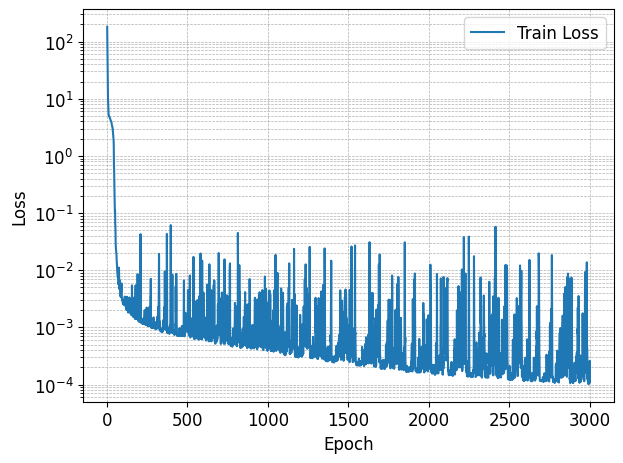

In [ ]:
model_complete = Model(2, [32,32,32], activation_function=nn.Tanh()) #initialize model with 3 hidden layers, 32 nodes in each
optimizer_complete = optim.Adam(model_complete.parameters(), lr=1e-3) 
S_max = 20 
T = 1.0 
sigma = 0.3
r = 0.05 
K = 5

#initialize training object 
trainer = Training(model_complete, S_max, r, K, sigma, T)
#Initilize data 
num_lbc_points = 300 #number of points for left boundary condition 
num_rbc_points = 300 #number of points for right boundary condition 
num_tc_points = 500 #number of points for terminal condition 
num_pde_points = 3000 #number of collocation points





data_initializer = InitializeData(S_max,T)

#Training data
lbc = data_initializer.data_lbc(num_lbc_points, seed=8)
rbc = data_initializer.data_rbc(num_rbc_points, seed=787)
tc = data_initializer.data_tc(num_tc_points, seed=466)
pde = data_initializer.data_pde(num_pde_points, seed=987)

#Validation data, use same number of validation data points
lbc_val = data_initializer.data_lbc(num_lbc_points, seed=5)
rbc_val = data_initializer.data_rbc(num_rbc_points, seed=328)
tc_val = data_initializer.data_tc(num_tc_points, seed=2939)
pde_val = data_initializer.data_pde(num_pde_points, seed=139)






batch_size = 128 #batch size for training

N_epochs = 3000 #number of epochs for training

#train model
loss_weights, validation_loss, epochs_list = trainer.training_cycle_BS(N_epochs, lbc, rbc, tc, pde, optimizer_complete, batch_size=batch_size, val_lbc= lbc_val,
                                                                       val_rbc=rbc_val, val_tc=tc_val, val_pde=pde_val
                                                                          )

plt.figure()
plt.plot(epochs_list, validation_loss, label='Train Loss')


plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.yscale('log')        #set y-axis to logarithmic
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

We see a slight decrease in the lowest validation loss when using adaptive weights. We also see greater fluctuatuions in the loss plot. This may be a result of the mini-batch training. Lowering the learning rate would also yield less fluctuations. In the code I have a learning rate of 0.001 which yielded better restults for me! Try with both 0.01 and 0.001. 
NB: In the logging of the training and validation losses above we see the weighted training losses. The validation losses are not weighted. We therefore experience a larger validation loss than a training loss. The key metric to pay attention to is the validation loss. 

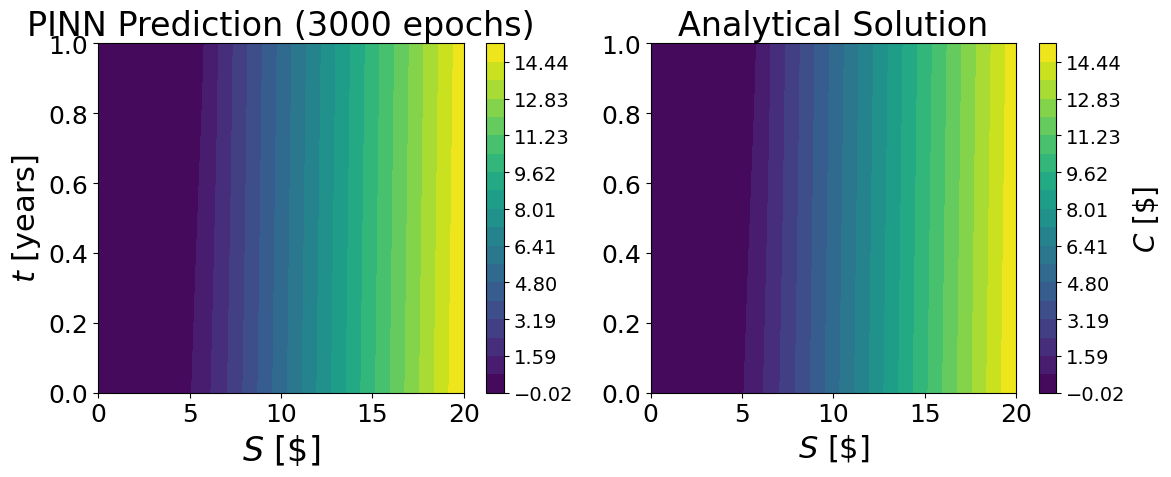

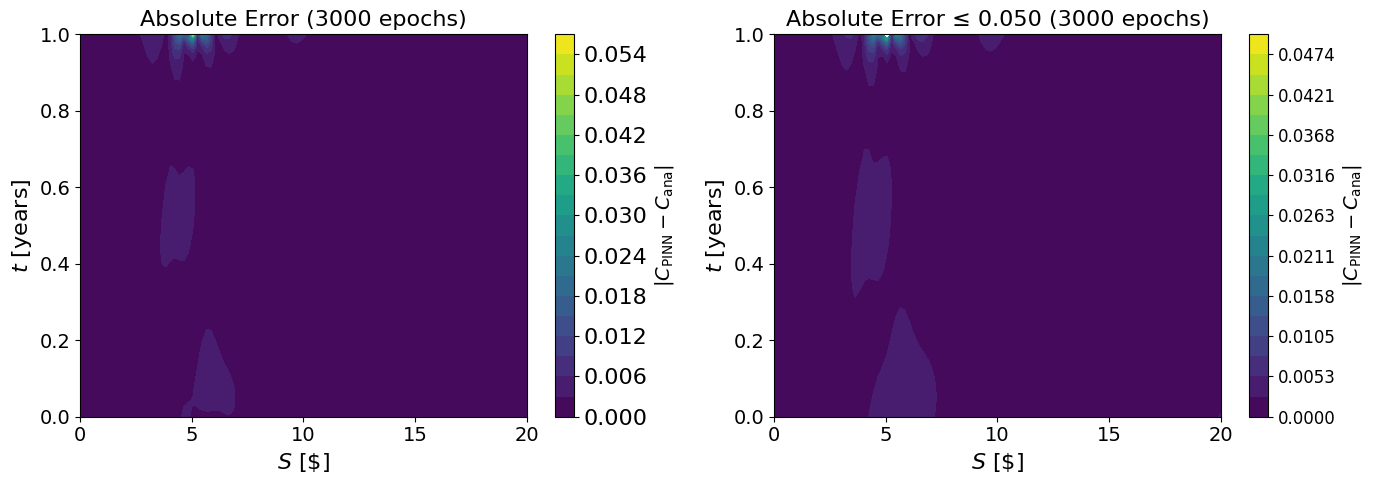

In [ ]:
with torch.no_grad():
    predicted_complete = model_complete(x_tensor_norm).cpu().numpy().reshape(S_mesh.shape)


plot_comparison(
    S_grid=S_mesh,
    t_grid=t_mesh,
    analytical=analytical,
    predicted=predicted_complete,       
    save_path="results"                     
)

abs_error_flat= np.abs(analytical.flatten() - predicted_complete.flatten())


Now we print the average absolute error on the grid as before. When running with the above setup and the best hyperparameters we have found I generally get performance gains corresponding to a decrease in absolute error of about a factor of 0.5 compared to previously. 

We also see that the model now performs significantly better at the kink $S=K$. This may be due to the weighting of loss functions. 


In [ ]:
print(sum(abs_error_flat)/len(abs_error_flat))


0.0011704614974662926


We see that the mean absolute error is 0.0011 compared to earlier where we got 0.0052. 


#### Multidimensional Black-Scholes 

Since we now have some experience with the Black-Scholes equation and PINNs, we are ready to tackle the harder problem: solving the multidimensional version. That the equation is multidimensional simply means that there can be arbitrarily many underlying assets in the same option. Generally no closed form solution exists in more than one spatial (asset) dimension. 
The equation is: 
$$
\boxed{

\frac{\partial C}{\partial t} 
+ \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \sigma_i \sigma_j S_i S_j \rho_{ij} 
\frac{\partial^2 C}{\partial S_i \partial S_j} \\
+ \sum_{i=1}^N r S_i \frac{\partial C}{\partial S_i} 
- rC = 0
}
$$




Here $C$ and $r$ is as before. $\sigma_i$ is the volatility of the i'th asset, and $\rho_{ij}$ is the correlation between asset i and j. The terminal condition is now given by 

$$
\boxed{
C(\mathbf{S}, T) = \max\left(B(\mathbf{S}) - K,\, 0\right),
}
$$
where $B(\mathbf{S})$ is given by $B(\mathbf{S}) = \frac{1}{N} \sum_{i=1}^{N} S_i$. The strike price $K$ is as before. 

We will use the same $S_\text{max}$ for all the assets in a given basket. All assets will also have the same volatility. Furthermore, we set $\rho$ as the identity matrix, i.e. there is no correlation between assets. 

Defining proper boundary conditions for this equation is a difficult task as one must use approximations. There is a variety of ways doing this. 
We also note that for N assets there are $2N$ different boundaries! 

**Left boundary condition**
Suppose we have a basket of assets N assets (this simply means a collection of assets/a portfolio), $B(\mathbf{S})$. If one of the companies in your basket suddenly goes bankrupt the stock goes to zero, i.e. $S_i = 0$. We now essentially have a basket of N-1 assets. This means that we have an $N-1$ dimensional PDE to solve instead of an $N$ dimensional at the left boundary! To tackle this issue we will use our previously trained model to provide target values at the left boundary. It is important to note that the larger dimensional must have the financial parameters as the model in one lower dimension, i.e. $r,K,\sigma,S_\text{max}$, must be the same for both models. For the two-dimensional case we can also simply use the analytical formula for the Black-Scholes equation with $\frac{1}{2}S$ as the variable for the left boundary target values. 


**Right boundary condition**
For the right boundary we will use a Neumann boundary condition. The mathematical derivation of the boundary condition is omitted here as it requires  knowledge of stochastic differential equation, which is outside of our scope. Yet we can get an intutition for why the definition makes sense. 
As the price of one asset $S_i$ grows very large (mathematically goes to infinity) what behavior can we expect from the basket of assets? Well, the asset $S_i$ will dominate the basket so we have $B(\mathbf{S}) \approx \frac{1}{N} S_i$. Differentiating this expression yields $\frac{1}{N}$ so we define our right boundary conditions to be $\frac{1}{N}$. The right boundary condition should be defined for the price of the option, not the basket of assets, but these actually coincide here. This is part of the mathematical step we omitted. 



#### Loss functions

We are now ready to define our loss functions for the multidimensional case! 
We start with the PDE loss.

**PDE loss**

Analogously to the case with one asset, we define the PDE residual at every collocation point

$$
R_{M}(\mathbf{S}_k, t_k) =
\frac{\partial \hat{C}}{\partial t} \Big|_{(\mathbf{S}_k, t_k)} +
\frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \sigma_i \sigma_j S_i S_j \rho_{ij}
\frac{\partial^2 \hat{C}}{\partial S_i \partial S_j} \Big|_{(\mathbf{S}_k, t_k)} +
\sum_{i=1}^N r S_i \frac{\partial \hat{C}}{\partial S_i} \Big|_{(\mathbf{S}_k, t_k)} -
r \hat{C}(\mathbf{S}_k, t_k).
$$

Since this is supposed to equal zero we set $\mathbf{R}^{\text{target}}_{M}$ to be zero. $\mathbf{\hat{R}}$ is the model prediction. 
We then define

$$
\mathcal{L}_{\text{PDE}} = MSE(\mathbf{R}^{\text{target}}_{M}, \mathbf{\hat{R}})
$$


**TC loss**

We define the terminal condition loss as 
$$
\mathcal{L}_{\text{TC}}^{M} = \text{MSE}(\mathbf{T_{M}}^{\text{target}}, \mathbf{\hat{T}_M}),
$$
where $\mathbf{T_{\text{M}}}^{\text{target}}$ is the value given by the terminal condition above and $\mathbf{\hat{T}_M}$ is the model prediction. 

**Left boundary condition loss**


As previously mentioned the target values will be defined by a model trained in $N-1$ dimensions if we look at a basket with $N$ assets. If $N=2$ we simply use the analytical formula for the one dimensional Black-Scholes equation. We let $\mathbf{L}^{\text{target}}$ denote the target values and $\mathcal{\hat{L}}$ denote the model prediction. It follows that the left boundary condition loss function is defined as 

$$
\mathcal{L}_{\text{LBC}} = MSE(\mathbf{L}^{\text{target}}, \mathcal{\hat{L}}).
$$
Remember that in this case we have $N$ left boundaries, so we will have $N$ left boundary losses to consider in the total loss function. 

**Right boundary condition loss**
We define a loss function that only apply to right boundaries ($S_i = S_{\text{max}_i}$), corresponding to the previously discussed Neumann condition. The target value of the model is equal to $1/N$. One important consideration here is that we expect
$$
\frac{\partial C}{dS_i} \approx \frac{1}{N}, 
$$
in the limit as $S_i \rightarrow \infty$. Since we have a truncated domain, this asymptotic behavior might not be captured correctly. If we also consider the normalization the boundary condition should have a target value of $\frac{S_{\text{max}}}{2N}$. 
Because of the difficulty of capturing the correct asymptotic behavior we have conducted experiments with different values to find the value $\lambda$ that yields the most accurate model predictions. These experiments are not included here as it is not very informative to the reader, though you should definitely conduct such experiments if it is relevant to your project (check out the repo https://github.uio.no/fredrink/FYS5429 if you want more information on the experiments). The target, $\mathbf{N_{M}}^{\text{target}}$ is then set to $\lambda$ for all points, and the model prediction is denoted $\mathbf{\hat{T}_M}$. The loss is defined 
$$
    \mathcal{L}_{\text{Ne}}^{M} = \text{MSE}(\mathbf{N_{M}}^{\text{target}}, \mathbf{\hat{N}_{M}}). 
$$


Through experiments we found that with $S_{\text{max}} = 20$ we get $\lambda = 4.3$ (with normalization) in the case of two assets.



We are now ready to start coding. We will use the modelclass as it is, make simple changes to the InitializeData class, and define a new loss function class as they greatly differ in multiple dimensions compared to one. We start with the InitializeData class.

**Initialize data**

We will now define a single method for data generation for both the left and right boundaries. This is done to keep the code shorter. The most important point is is that we store all data for the different N left boundary conditions in a tensor of shape (N,num_points,N+1), where N is the number of assets. Each boundary condition is stored at a different index along the first axis of the tensor.

In [ ]:
class InitializeDataMulti():
    """
    Handles data initialization and normalization for training a PINN and
    financial PDEs with multplie underlying assets.
    """
    def __init__(self, S_max_list, T):
        """
        Parameters:
            - S_max_list (list): Maximum values for each asset.
            - T         (float): Time to maturity.
        """
        self.S_max_list = S_max_list
        self.T = T 
        self.dim = len(S_max_list) + 1  # Total input dimensions (assets + time) 
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.S_max_tensor = torch.tensor(S_max_list, dtype=torch.float32, device=self.device)
 
    
    def normalize(self, pts): 
        """
        Normalizes inputs [S_1, ..., S_d, t] to [-1,1] range.
        
        Parameters:
            - pts (torch.Tensor): Shape (N, d+1)
        
        Returns:
            - torch.Tensor: Normalized coordinates in [-1, 1].
        """        
        S = pts[:, :self.dim - 1] 
        t = pts[:, -1:]

        # Use global max across all assets for normalization
        global_max = max(self.S_max_list)
        

        # Normalize each asset component and time
        x_norm = 2.0 * S / global_max - 1
        tau_norm = 2.0 * ((self.T - t) / self.T) - 1

        return torch.cat([x_norm, tau_norm], dim=1)
    
    
   
    def initialize_bc(self, n_points, seed, rbc=False):
        """
        Generates boundary condition points.

        Parameters:
            - n_points (int): Number of points per asset dimension.
            - seed     (int): Random seed.
            - rbc     (bool): If True, generates right boundary. Else left.
        
        Returns:
            - torch.Tensor: Shape (dim-1, n_points, dim) with normalized BCs.
        """
        bc_list = []
       
        for j in range(self.dim-1):
            # Sample all asset dimensions except j, plus time
            sampler = LatinHypercube(d=self.dim-1, seed=seed + j)
            samples = torch.tensor(sampler.random(n=n_points), dtype=torch.float32, device=self.device)
            samples[:, -1:] = samples[:, -1:] * self.T  # Scale time to [0, T]

            # Set boundary value for current asset
            if rbc == False: #initialization of left boundary data
                bc_torch = torch.zeros((n_points,1), dtype=torch.float32, device=self.device)
            else: 
                bc_torch = torch.full((n_points,1),self.S_max_list[j], dtype=torch.float32, device=self.device) #initilization of right boundary data
            
            # Scale other asset dimensions
            tmp_list = self.S_max_list.copy()
            del tmp_list[j] 
            samples[:,:-1] *= torch.tensor(tmp_list, dtype=torch.float32, device=self.device)
            
            # Insert boundary value in correct asset position
            before_j = samples[:, :j]
            after_j = samples[:, j:]
            bc_i = torch.cat((before_j, bc_torch, after_j), dim=1)

            # Normalize the pointsn and add to lsit
            bc_list.append(self.normalize(bc_i))
            
    
        return torch.stack(bc_list, dim=0)
    

    def initialize_tc(self, n_main, seed):
        """
        Generates terminal condition points.

        Parameters:
            - n_main  (int): Standard number of points.
            - seed    (int): Random seed.
        
        Returns:
            - torch.Tensor: Normalized terminal condition data.
        """
        # Main points at t = T
        sampler = LatinHypercube(d=self.dim-1, seed=seed+17)
        S_tc = torch.tensor(sampler.random(n=n_main), dtype=torch.float32, device=self.device)
        S_tc *= self.S_max_tensor  # Scale each asset dimension
        
        # All points will have t = T
        t_tc = torch.full((n_main,1), self.T, dtype=torch.float32, device=self.device)

    
        tc = torch.cat([S_tc, t_tc], dim=1)
      
        return self.normalize(tc)


    def initialize_pde(self, n_points, seed):
        """
        Generates collocation points for training the PDE loss.

        Parameters:
            - n_points (int): Base number of collocation points.
            - seed     (int): Random seed.

        Returns:
            - torch.Tensor: Normalized collocation points.
        """
        # Base collocation points in the full domain
        sampler = LatinHypercube(d=self.dim, seed=seed)
        samples = torch.tensor(sampler.random(n=n_points), dtype=torch.float32, device=self.device)
       
        # Scale asset and time dimension
        samples[:,:self.dim-1] *= self.S_max_tensor
        samples[:,-1] *= self.T
        
        return self.normalize(samples)

**Loss functions**

We now move on to defining new loss functions. They are defined and calculated as given aboven. 
There is now two methods for both left and right boundaries. The logic behind this is that the method def BC_right_loss(self, rbc_i, i, key) computes the loss for a given left boundary and def lbc_total_loss(self, lbc, key) sums up the loss for all left boundaries. The same is done for the right boundaries. 
jacrev below is used for computing the Jacobian efficiently, and vmap is used for vectorization. 
     

In [ ]:
from torch.func import jacrev
from torch import vmap

class LossFunctionsMulti():
    """
    Collection of loss function used to train a Physics-Informed Neural Network (PINN)
    for solving high-dimensional Black-Scholes-type PDEs.
    """
    def __init__(self, model, S_max_list, r=1.0, K=1.0, sigma=0.2, T=1.0, rho=None):
        """
        Initializes loss functions for PDE training.

        Parameters:
            - model          (nn.Module): Neural network representing the PDE solution.
            - S_max_list (list of float): Max values for each asset.
            - r                  (float): Risk-free interest rate.
            - K                  (float): Strike price of the option.
            - sigma      (list of float): Volatility for each asset.
            - T                  (float): Time to maturity.
            - rho    (tensor or ndarray): Correlation matrix (defaults to identity).
        """
        self.model = model
        self.S_max_list = S_max_list
        self.r = r
        self.K = K
        self.T = T
        self.d = len(S_max_list)  # Number of assets
        self.global_max = np.max(S_max_list) 
        self.mse = nn.MSELoss()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.sigma = torch.as_tensor(sigma, dtype=torch.float32, device=self.device).flatten()  # Make sure sigma is a tensor and on correct device

        # Use identity matrix if no correlation matrix is given
        if rho is None:
            self.rho = torch.eye(self.d, dtype=torch.float32, device=self.device)
        else:
            self.rho = torch.as_tensor(rho, dtype=torch.float32, device=self.device)



    def PDE_loss(self, input_tensor):
        """
        Computes the mean squared residual of the PDE.

        Parameters:
            - input_tensor (torch.Tensor): Normalized inputs (S_norm, t_norm)
        
        Returns:
            - torch.Tensor: Scalar PDE residual loss.
        """
        input_tensor = input_tensor.clone().requires_grad_(True)
        
        x_norm = input_tensor[:, :self.d] 
        tau_norm = input_tensor[:, -1:] 
       
        X = torch.cat([x_norm, tau_norm], dim=1)
        X = X.float().requires_grad_()
   
        # Model prediction
        C = self.model(X)

        # Compute gradients
        dC = torch.autograd.grad(C, X, torch.ones_like(C), create_graph=True)[0]
        C_tau_norm = dC[:, -1:]  # derivative w.r.t. normalized time
        C_x_norm = dC[:, :self.d]  #  derivative w.r.t. normalized assets
        
        # Denormalize asset prices and time
        S = 0.5 * (x_norm + 1.0) * self.global_max
        C_t = C_tau_norm * (-2.0 / self.T)   

    

        # Define a function that returns the spatial gradient for one sample
        def grad_C_x(x, tau):
            xt = torch.cat([x, tau], dim=-1).unsqueeze(0)  # [1, d+1]
            C_val = self.model(xt)  # [1, 1]
            dC_dX = torch.autograd.grad(C_val, xt, torch.ones_like(C_val), create_graph=True)[0]  #
            return dC_dX[0, :self.d]  # [d]

        #Compute Hessian using Jacobian of the gradient
        hessian_single = jacrev(grad_C_x, argnums=0)
        H_xx_norm = vmap(hessian_single, in_dims=(0, 0))(x_norm, tau_norm)

        # Convert normalized second derivatives to original coodinates
        scales = (2.0 / torch.tensor(self.S_max_list, device=x_norm.device))
        scale_mat = scales[None, :] * scales[:, None]  # [d, d]
        H_SS = H_xx_norm * scale_mat.unsqueeze(0)  # [batch, d, d]

        # Denormalize first derivatives
        C_s = C_x_norm * (2.0 / torch.tensor(self.S_max_list, device=self.device))  # [batch, d]

        # Initialize PDE residual with time derivatives
        pde_residual = C_t.clone()  # [batch, 1]

        # Add volatility and correlation terms
        for i in range(self.d):
            for j in range(self.d):
                pde_residual += (
                    0.5
                    * self.sigma[i]
                    * self.sigma[j]
                    * self.rho[i, j]
                    * S[:, i:i+1]
                    * S[:, j:j+1]
                    * H_SS[:, i, j].unsqueeze(-1)
                )

        # Add drift (first term) and discounting terms (second term)
        drift = (self.r * S * C_s).sum(dim=1, keepdim=True)
        pde_residual += drift - (self.r * C)

        return torch.mean(pde_residual**2)



    def TC_loss(self, tc):
        """
        Computes the loss for the terminal condition at maturity (t = T).

        Parameters:
            - tc (torch.Tensor): Normalized input tensor of shape (N, d+1), where the last column is t = T.

        Returns:
            - torch.Tensor: Mean squared error between model predictions and terminal payoff.
        """
        C_tc = self.model(tc)

        # Convert normalized inputs to real asset prices
        x_norm = tc[:, :-1]  
        S = (1 + x_norm) * self.global_max * 0.5

        # Compute the basket value (mean of asset prices) 
        basket = torch.mean(S, dim=1, keepdim=True) 
        true_tc = torch.maximum(basket - self.K, torch.zeros_like(basket))

        return self.mse(C_tc, true_tc)
    


    def BC_left_loss(self, lbc_i, i, model):
        """
        Computes the loss for the left boundary condition where S_i = 0.

        Parameters:
            - lbc_i (torch.Tensor): Normalized tensor of shape (N, d+1) for S_i = 0 along one asset dimension.
            - i (int): Index of the asset dimension.
            - key (str): Specifies the boundary condition type ("Dirichlet" or "Model").
            - model (nn.Module): The model used to predict the boundary condition.

        Returns:
            - torch.Tensor: Mean squared error between model output and true boundary condition.
        """
        C_lbc = self.model(lbc_i)

        # Remove the column for asset i (reduce dimension)
        lbc_i = lbc_i.clone()
        lbc_i = torch.cat([lbc_i[:, :i], lbc_i[:, i+1:]], dim=1)
    
        # Separate normalized time and asset
        x_norm = lbc_i[:, :-1]
        t_norm = lbc_i[:, -1:]

        # Denormalize asset
        S_max_effective = self.S_max_list[0]  # Assume one remaining asset
        S_unnorm = 0.5 * (x_norm + 1.0) * S_max_effective

        # Apply weight before normalization
        weight = 1 / len(self.S_max_list)
        S_weighted = S_unnorm * weight

        # Renormalize using same S_max as model was trained on
        S_renorm = 2.0 * (S_weighted / S_max_effective) - 1.0

        # Reconstruct input
        lbc_i_weighted = torch.cat([S_renorm, t_norm], dim=1)
    


        if self.d == 2: 
            t = 0.5 * (1 - t_norm) * self.T  # shape: (N, 1)
            t = t.detach().cpu().numpy().flatten()  # shape: (N,)
            S = S_weighted.detach().cpu().numpy().flatten()  # shape: (N,)
         

            true_solution = analytical_solution(S, self.K, self.T, t, self.r, torch.max(self.sigma).item())
            true_solution = torch.tensor(true_solution, dtype=torch.float32).to(x_norm.device).view(-1, 1)
          
            return self.mse(C_lbc, true_solution)
           

        else: 
            # For ND case, we use a previously trained model to predict the boundary condition
            # Load (N-1)D model
            model_optimus = model #use previously trained model
            model_optimus.to(self.device).eval()

            # Predict 1D boundary solution
            true_lbc_i = model_optimus(lbc_i_weighted)

            return self.mse(C_lbc, true_lbc_i)
      


    def lbc_total_loss(self, lbc):
        """
        Computes the total left boundary loss across all asset dimensions.

        Parameters:
            - lbc (torch.Tensor): Tensor of shape (d, N, d+1), where each slice corresponds to one S_i = 0 boundary.
       
        Returns:
            - list of torch.Tensor: Individual MSE losses for each left boundary condition.
        """   
        total_loss = []  # List to store the MSE for each asset's left boundary 
     
        for i in range(lbc.shape[0]):
            lbc_i = lbc[i]  # Select boudnary data for asset i (S_i = 0)
            total_loss.append(self.BC_left_loss(lbc_i, i, self.model))
        
        return total_loss
        


    def BC_right_loss(self, rbc_i, i):
        """
        Computes the right boundary loss where S_i = S_max_i, which corresponds to the behavior as S_i → ∞.

        Parameters:
            - rbc_i (torch.Tensor): Right boundary data for asset i. Shape: (N, d+1).
            - i              (int): Index of the asset dimension this boundary belongs to.
          

        Returns:
            - torch.Tensor: MSE loss between model output and expected boundary behavior.
        """
        rbc_i = rbc_i.clone().requires_grad_(True)  # Enable gradient tracking, shape: (N, d)
        C_rbc = self.model(rbc_i)  # Model prediction at boundary
        
        # Denormalize asset prices
        x_norm = rbc_i[:, :-1]     
        S = 0.5 * self.global_max*(x_norm + 1.0) 

        # Denormalize time and compute tau = T - t
        t_norm = rbc_i[:, -1:]  
        tau = self.T * (t_norm + 1) * 0.5 
     
        # Compute basket value (mean of all asset prices)
        basket = torch.mean(S, dim=1, keepdim=True)

  
        # Enforce Neumann BC 
        grad_outputs = torch.ones_like(C_rbc)

        # Compute gradients with respect to inputs
        dC_dX = torch.autograd.grad(
            outputs=C_rbc,
            inputs=rbc_i,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True,
        )[0]  # Shape: (N, d)

        # Select gradient component for asset i
        dC_dS_i = dC_dX[:, i:i+1]   # Shape: (N, 1)

        # Define target and loss
        target = torch.ones_like(dC_dS_i) * 4.5
        loss = self.mse(dC_dS_i, target)

        # Adds a dummy term that uses the output value, to ensure all parameters are involved when computing weights
        # in train_BS. The bias in the last layer is not included when calculating loss weights for the right boundary 
        # if the dummy term isn't present. 
        dummy_reg = 1e-8 * torch.mean(C_rbc**2)

     
        return loss + dummy_reg
            

     
    def rbc_total_loss(self, rbc):
        """
        Computes the total right boundary loss across all asset dimensions.

        Parameters:
            - rbc (torch.Tensor): Tensor of shape (d, N, d+1), where each slice corresponds to one S_i = S_max_i boundary.
            - key            (str): Type of boundary condition ("Dirichlet", "Neumann", etc.).

        Returns:
            - list of torch.Tensor: Individual MSE losses for each right boundary condition.
        """    
        total_loss = []  # List to store individual boundary losses

        for i in range(rbc.shape[0]):
            rbc_i = rbc[i]  # Select boudnary data for asset i (S_i = S_max_i)
            total_loss.append(self.BC_right_loss(rbc_i, i))

        return total_loss

Now we must finally generalize the training loop to arbitrary many dimensions, keep in mind how we weight the loss functions. We have one weight for the sum of all left boundary condition losses, and one for the sum of all right boundary condition losses. We rewrite our previous Training class. 

In [ ]:
import copy
from torch.utils.data import DataLoader, TensorDataset
class TrainingMulti(LossFunctionsMulti):
    """
    Training class for Physics-Informed Neural Networks (PINNs) applied to high-dimensional
    Black-Scholes-type PDEs. Inherits form the LossFunction class, which provides the
    loss definition for the terminal condition, boundary conditions, and PDE residual.
    """
    def __init__(self, model, S_max_list, r=1, K=1, sigma=1, T=1):
        """
        Initialize the Training class for PINN-based Black-Scholes training.

        Parameters:
            - model          (nn.Module): The neural network model.
            - S_max_list (list of float): Max asset values for each dimension.
            - r                  (float): Risk-free interest rate.
            - K                  (float): Strike price.
            - sigma      (list of float): Volatility per asset.
            - T                  (float): Time to maturity.
        """
        super().__init__(model, S_max_list, r, K, sigma, T)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Initialize adaptive weights for each loss component
        self.weights = {}
        for i in range(len(S_max_list)):
            self.weights[f"bc_left_{i}"] = torch.tensor(1.0, device=self.device)
            self.weights[f"bc_right_{i}"] = torch.tensor(1.0, device=self.device)
        self.weights["tc"] = torch.tensor(1.0, device=self.device)
        self.weights["pde"] = torch.tensor(1.0, device=self.device)
        

    
    def trim_dataset(self, data, num_batches, bc=False):
        """
        Trims data so it's divisible by the number of batches.

        Parameters:
            - data     (Tensor): Data to trim. Shape (d, N, d+1) if bc=True, otherwise (N, d+1).
            - num_batches (int): Desired number of batches.
            - bc         (bool): Whether the data is boundary condition data.

        Returns:
            - Tensor: Trimmed data tensor
        """
        if bc:
            trimmed_len = (len(data[0]) // num_batches) * num_batches
            return data[:, :trimmed_len, :]
        else: 
            trimmed_len = (len(data) // num_batches) * num_batches
            return data[:trimmed_len]
      


    def training_step_BS(self, lbc, rbc, tc, pde, optimizer):
        """
        Performs a single training step: computes all loss components, adapts weights,
        backpropagates the weighted loss, and updates model parameters.

        Parameters:
            - lbc                      (Tensor): Left boundary condition data (d, N, d+1).
            - rbc                      (Tensor): Right boundary condition data (d, N, d+1).
            - tc                       (Tensor): Terminal condition data (N, d+1).
            - pde                      (Tensor): PDE interior sampling points (N, d+1).
            - optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
          
        Returns:
            - (tuple): Tuple containing:
                - total_loss    (Tensor): Total weighted loss.
                - pde_loss      (Tensor): PDE residual loss.
                - bc_left_total (Tensor): Left boundary condition loss.
                - bc_right_total(Tensor): Right boundary condition loss.
                - tc_loss       (Tensor): Terminal condition loss.
        """
        # Compute each component of the loss
        bc_left_losses = self.lbc_total_loss(lbc)  # List of tensors
        bc_right_losses = self.rbc_total_loss(rbc)  # List of tensors
        tc_loss = self.TC_loss(tc)
        pde_loss = self.PDE_loss(pde)

    
            
        # Names and raw values of all losses (for weighting)
        loss_names = (
            [f"bc_left_{i}" for i in range(len(bc_left_losses))] +
            [f"bc_right_{i}" for i in range(len(bc_right_losses))] +
            ["tc", "pde"]
        )
        raw_losses = bc_left_losses + bc_right_losses + [tc_loss, pde_loss]

        # Adaptive weighting based on the total gradient (GradNorm)
        epsilon, alpha = 1e-8, 0.9
        grads = {}
            
        # Compute gradient norms for each loss component
        for name, loss in zip(loss_names, raw_losses):
            optimizer.zero_grad()

            # Get gradients of model parameters with respect to current loss
            param_grads = torch.autograd.grad(
                loss,
                self.model.parameters(),
                retain_graph=True
            )

            # Compute total gradient norm (L2 norm)
            grad_norm = torch.sqrt(sum(g.pow(2).sum() for g in param_grads if g is not None))
            grads[name] = grad_norm
            
            #test to check for vanishing gradients 
            if grad_norm < 1e-8:
                    print(f"[WARNING] Vanishing gradient detected in '{name}'")
                
        total_grad = sum(grads.values())
                        
        # Compute relative weights based on inverse gradient magnitudes
        weights_hat = {n: total_grad / (grads[n] + epsilon) for n in loss_names}
        for n in loss_names:
            self.weights[n] = alpha * self.weights[n] + (1 - alpha) * weights_hat[n]  # Update rule: moving average

        # Normalize weights to sum to 1
        total_weight = sum(self.weights.values())
        self.weights = {k: v / total_weight for k, v in self.weights.items()}

        # Compute weighted losses using updated weights
        weighted_losses = {
            n: self.weights[n] * raw_losses[i] for i, n in enumerate(loss_names)
        }
        total_loss = sum(weighted_losses.values())

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1)
        optimizer.step()

        # Sum BC losses across all asset dimensions for easier logging
        bc_left_total = sum(weighted_losses[n] for n in loss_names if n.startswith("bc_left"))
        bc_right_total = sum(weighted_losses[n] for n in loss_names if n.startswith("bc_right"))

        return total_loss, weighted_losses["pde"], bc_left_total, bc_right_total, weighted_losses["tc"]
    




    def training_cycle_BS(self, N_epochs, lbc, rbc, tc, pde, optimizer, scheduler, batch_size, key_lbc, key_rbc, use_scheduler=False):
        """
        Full training cycle with validation and checkpointing of best model.

        Parameters:
            - N_epochs                       (int): Number of training epochs.
            - lbc                         (Tensor): Left boundary condition training data.
            - rbc                         (Tensor): Right boundary condition training data.
            - tc                          (Tensor): Terminal condition training data.
            - pde                         (Tensor): PDE interior point training data.
            - optimizer    (torch.optim.Optimizer): Optimizer instance.
            - scheduler (torch.optim.lr_scheduler): Learning rate scheduler.
            - batch_size                    (int): Batch size per epoch.
            - key_lbc                        (int): Index of asset dimension for left boundary loss.
            - key_rbc                        (int): Index of asset dimension for right boundary loss.
            - use_scheduler                 (bool): Whether to use lr scheduler after each epoch.

        Returns:
            - (tuple): Training and validation stats and best model state.
        """
        # --- Initialize structures ---
        train_components = {k: [] for k in ["total", "pde", "bc_left", "bc_right", "tc"]}
        val_components   = {k: [] for k in ["total", "pde", "bc_left", "bc_right", "tc"]}
        val_seed_lbc, val_seed_rbc, val_seed_tc, val_seed_pde = 40, 70, 144, 490 
        pde_N_val, tc_N_val, lbc_N_val, rbc_N_val = 10000, 2000, 1000, 1000

        # --- Generate validation data ---
        data_initializer_val = InitializeDataMulti(self.S_max_list, self.T)
        lbc_val = data_initializer_val.initialize_bc(lbc_N_val, val_seed_lbc)
        rbc_val = data_initializer_val.initialize_bc(rbc_N_val, val_seed_rbc, rbc=True)
        tc_val = data_initializer_val.initialize_tc(tc_N_val, val_seed_tc)
        pde_val = data_initializer_val.initialize_pde(pde_N_val, val_seed_pde)

        loss, epochs = [], []
        val_loss, epochs_val = [], []
        best_val_loss = float("inf")
        best_model_state = None

        # --- Trim datasets to be divisible by batch_size ---
        def trim_len(x, bs, bc=False):
            L = len(x[0]) if bc else len(x)
            trim = (L // bs) * bs
            return x[:, :trim, :] if bc else x[:trim]

        lbc = trim_len(lbc, batch_size, bc=True)
        rbc = trim_len(rbc, batch_size, bc=True)
        tc = trim_len(tc, batch_size)
        pde = trim_len(pde, batch_size)

        # --- Create DataLoaders ---
        lbc_dl = DataLoader(TensorDataset(lbc.permute(1, 0, 2)), batch_size, shuffle=True, drop_last=True) #must permute dimensions of lbc to fit DataLoader setup
        rbc_dl = DataLoader(TensorDataset(rbc.permute(1, 0, 2)), batch_size, shuffle=True, drop_last=True)#must permute dimensions of rbc to fit DataLoader setup
        tc_dl  = DataLoader(TensorDataset(tc), batch_size, shuffle=True, drop_last=True)
        pde_dl = DataLoader(TensorDataset(pde), batch_size, shuffle=True, drop_last=True)

        # --- Training loop ---
        for epoch in range(N_epochs):       
            self.model.train() 
            total, pde_sum, bc_l_sum, bc_r_sum, tc_sum = 0.0, 0.0, 0.0, 0.0, 0.0
            batches = 0

            for (lbc_batch, rbc_batch, tc_batch, pde_batch) in zip(lbc_dl, rbc_dl, tc_dl, pde_dl):
                lbc_batch[0] = lbc_batch[0].transpose(0, 1) #correct the dimensions
                rbc_batch[0] = rbc_batch[0].transpose(0, 1) #correct the dimensions

                total_loss, pde_loss, bc_l, bc_r, tc_l = self.training_step_BS(
                    lbc_batch[0], rbc_batch[0], tc_batch[0], pde_batch[0], optimizer
                )

                total += total_loss.item()
                pde_sum += pde_loss.item()
                bc_l_sum += bc_l.item()
                bc_r_sum += bc_r.item()
                tc_sum += tc_l.item()
                batches += 1    

            # --- Log training ---
            avg_loss = total / batches
            avg_pde = pde_sum / batches
            avg_bc_left = bc_l_sum / batches
            avg_bc_right = bc_r_sum / batches
            avg_tc = tc_sum / batches

            loss.append(avg_loss)
            epochs.append(epoch)
            train_components["total"].append(avg_loss)
            train_components["pde"].append(avg_pde)
            train_components["bc_left"].append(avg_bc_left)
            train_components["bc_right"].append(avg_bc_right)
            train_components["tc"].append(avg_tc)

            # --- Validation ---
            if epoch % 50 == 0: 
                self.model.eval()
                with torch.no_grad():
                    tc_val_loss = self.TC_loss(tc_val)
                    bc_l_val = sum(self.lbc_total_loss(lbc_val))
                bc_r_val = sum(self.rbc_total_loss(rbc_val))
                pde_val_loss = self.PDE_loss(pde_val)
                total_val_loss = pde_val_loss + tc_val_loss + bc_r_val + bc_l_val

                val_loss.append(total_val_loss.item())
                epochs_val.append(epoch)
                val_components["total"].append(total_val_loss.item())
                val_components["pde"].append(pde_val_loss.item())
                val_components["bc_left"].append(bc_l_val.item())
                val_components["bc_right"].append(bc_r_val.item())
                val_components["tc"].append(tc_val_loss.item())

                if total_val_loss.item() < best_val_loss:
                    best_val_loss = total_val_loss.item()
                    best_model_state = copy.deepcopy(self.model.state_dict())
                self.model.train()  

            # --- Print ---
            if epoch % 100 == 0:
                if use_scheduler:
                    scheduler.step()
                print(f"T: Epoch {epoch}, pde {pde_loss.item():.3e}, TC {avg_tc:.3e}, BC_left {avg_bc_left:.3e}, BC_right {avg_bc_right:.3e}, loss {avg_loss:.3e}")
                print(f"V: Epoch {epoch}, pde {pde_val_loss.item():.3e}, TC {tc_val_loss.item():.3e}, BC_left {bc_l_val.item():.3e}, BC_right {bc_r_val.item():.3e}, loss {total_val_loss.item():.3e}")
            
        return loss, epochs, val_loss, epochs_val, train_components, val_components, best_model_state
        

When doing multidimensional PDEs a deeper and wider network than in the one-dimensional case is generally needed as the solution becomes more complex. We therefore increase to four hidden layers and 50 hidden nodes in each layer. This should also be optimized using hyperparameter grid search as in the one-dimensional case, but is not included here as we did not have the time to do it. 
We also increase the number of training points as our sample space has increased in size. 
Feel free to optimize the hyperparameters yourself to see if the results improve. 

T: Epoch 0, pde 3.825e-01, TC 2.495e+00, BC_left 2.320e+00, BC_right 4.958e+00, loss 1.020e+01
V: Epoch 0, pde 1.646e+00, TC 3.249e+01, BC_left 1.091e+01, BC_right 3.084e+01, loss 7.589e+01
T: Epoch 100, pde 1.984e-04, TC 1.408e-03, BC_left 7.052e-04, BC_right 2.798e-04, loss 2.982e-03
V: Epoch 100, pde 7.855e-03, TC 5.363e-02, BC_left 2.568e-03, BC_right 1.907e-03, loss 6.596e-02
T: Epoch 200, pde 2.267e-04, TC 6.353e-04, BC_left 2.540e-04, BC_right 1.009e-04, loss 1.262e-03
V: Epoch 200, pde 1.895e-03, TC 1.260e-02, BC_left 1.142e-03, BC_right 5.122e-04, loss 1.615e-02
T: Epoch 300, pde 2.493e-04, TC 3.172e-04, BC_left 1.220e-04, BC_right 5.723e-05, loss 6.553e-04
V: Epoch 300, pde 1.405e-03, TC 3.754e-03, BC_left 6.191e-04, BC_right 6.321e-04, loss 6.409e-03
T: Epoch 400, pde 1.616e-04, TC 2.659e-04, BC_left 1.553e-04, BC_right 8.263e-05, loss 6.992e-04
V: Epoch 400, pde 1.072e-03, TC 1.545e-03, BC_left 5.588e-04, BC_right 9.162e-04, loss 4.093e-03
T: Epoch 500, pde 6.826e-05, TC 1.

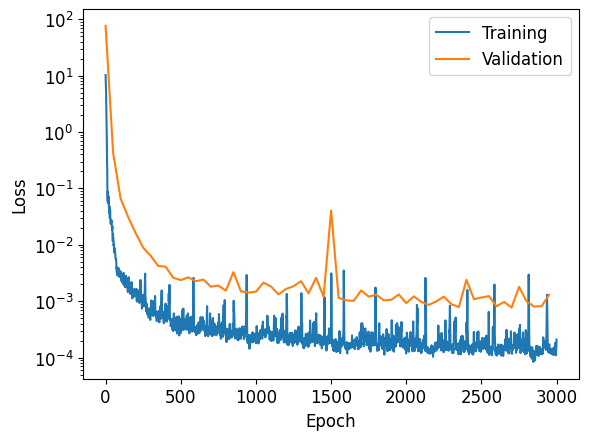

In [ ]:
import os
import json
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Configuration
S_max_list = [20, 20]   # Maximum asset price for each asset 
sigma_list = [0.2, 0.2]  # Volatility
T = 1.0             # Maturity time
r = 0.05            # Risk-free rate
K = 5.0             # Strike price


# Number of training points for each component
lbc_N = 1500        # Left boundary condition
rbc_N = 2000       # Right coundary condition
tc_N = 2500          # Terminal condition
pde_N = 14000       # PDE interior points (collocation points)

# Model architecture and training parameters
hidden_layers = [32, 32, 32]
epochs = 3000
batch_size = 128



# Data initialization
data_initializer = InitializeDataMulti(S_max_list, T)
lbc = data_initializer.initialize_bc(lbc_N, seed=1)
rbc = data_initializer.initialize_bc(rbc_N, seed=3, rbc=True)
tc = data_initializer.initialize_tc(tc_N, seed=7)
pde = data_initializer.initialize_pde(pde_N, seed=12)



# Model initialization, with optimizer and scheduler
model_multi = Model(num_inputs=3, hidden_layers = hidden_layers, activation_function=nn.Tanh())
optimizer_multi = torch.optim.Adam(model_multi.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer_multi, gamma=0.99)


if __name__ == "__main__":
    # Training
    trainer = TrainingMulti(model_multi, S_max_list, r, K, sigma_list, T)
    loss, epochs, val_loss, epochs_val, train_components, val_components, best_model_state = trainer.training_cycle_BS(
        epochs, lbc, rbc, tc, pde, optimizer_multi, scheduler, batch_size, key_lbc=0, key_rbc=0, use_scheduler=False
    )


    # Save training results to JSON
    results = {
        "epochs": epochs,
        "train_loss": loss,      
        "val_loss": val_loss,     
        "min_val_loss": float(min(val_loss)), 
        "train_components": train_components,
        "val_components": val_components,
    }

 
    
    # Plot loss curve
    plt.plot(results["epochs"], loss, label="Training")
    plt.plot(results["epochs"][::50], val_loss, label="Validation")
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

NB: In the logging of the training and validation losses above we see the weighted training losses. The validation losses are not weighted. We therefore experience a larger validation loss than training loss. The key metric to pay attention to is the validation loss. 

**Monte Carlo Simulation** 

Since there is no analytical solution to the multidimensional Black-Scholes equation we compare our PINN model's prediction to a solution provided by Monte Carlo simulation. We implement a simple Monte Carlo setup. 
For more information on Monte Carlo simulation for Black-Scholes and finance in general see the book, Monte Carlo methods in financial engineering, https://link.springer.com/book/10.1007/978-0-387-21617-1, especially chapter 1.2.2. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def price_european_call_on_grid(n_simulations, S_grid, t_array, K, r, sigma, weights, rho_vec, T):
    """
    Prices a European call option using Monte Carlo simulation, evaluated on a grid of (S, t) points.

    Parameters:
        - n_simulations  (int): Number of Monte Carlo samples.
        - S_grid  (np.ndarray): Grid of spot prices, shape (..., n_assets).
        - t_array (np.ndarray): Time values corresponding to S_grid points, same leading dims as S_grid.
        - K            (float): Strike price of the option.
        - r            (float): Risk-free interest rate.
        - sigma   (np.ndarray): Volatilities of the assets, shape (n_assets,).
        - weights (np.ndarray): Portfolio weights (for basket options), shape (n_assets,).
        - rho_vec (np.ndarray): Correlation vector for upper-triangle (excluding diagonal).
        - T            (float): Maturity time of the option.

    Returns:
        - np.ndarray: Option prices with shape equal to S_grid.shape[:-1].
    """
    # Extract shape info
    grid_shape = S_grid.shape[:-1]
    n_points = int(np.prod(grid_shape))
    n_assets = S_grid.shape[-1]

    # Single‐asset case
    if n_assets == 1:
        S_flat = S_grid.reshape(-1)               
        tau = np.maximum(T - t_array.reshape(-1), 0.0)

        # Draw normal samples for all simulations at once
        z = np.random.standard_normal((n_simulations, n_points))

        # Compute drift and volatility
        drift = (r - 0.5 * sigma[0] ** 2) * tau
        vol = sigma[0] * np.sqrt(tau)

        # Simulate terminal price
        S_T = S_flat * np.exp(drift + vol * z)


        # Discounted payoff 
        payoffs = np.maximum(S_T - K, 0.0)
        prices  = np.exp(-r * tau) * payoffs.mean(axis=0)

        return prices.reshape(grid_shape)
    

    # Multi-asset case
    else:
        S_flat = S_grid.reshape(n_points, n_assets)
        t_flat = t_array.reshape(-1)
        tau_flat = np.maximum(T - t_flat, 0.0)
    
        # Build full correlation matrix
        corr = np.eye(n_assets)
        idx = 0
        for i in range(n_assets):
            for j in range(i+1, n_assets):
                corr[i, j] = corr[j, i] = rho_vec[idx]
                idx += 1

        # Covariance and Cholesky decomposition
        cov = np.outer(sigma, sigma) * corr
        L = np.linalg.cholesky(cov)

        # Generate correlated random variables
        z = np.random.standard_normal((n_simulations, n_points, n_assets))
        cz = z @ L.T  # Shape (n_simulations, n_points, n_assets)

        # Risk-neutral drift and volatility
        drift_flat = (r - 0.5 * sigma ** 2)[None, :] * tau_flat[:, None]  # Shape (n_points, n_assets)
        vol_flat = sigma[None, :] * np.sqrt(tau_flat)[:, None]  # Shape (n_points, n_assets)

        # Simulate terminal price paths
        S_T = S_flat[None, :, :] * np.exp(drift_flat[None, :, :] + vol_flat[None, :, :] * cz)


        # Basket value and payoff
        basket = S_T @ weights        
        payoffs = np.maximum(basket - K, 0.0)
        mean_payoff = payoffs.mean(axis=0)

        # Discounted option price
        prices_flat = np.exp(-r * tau_flat) * mean_payoff
        
        return prices_flat.reshape(grid_shape)



To test if our Monte Carlo implementation is correct we compare it to the analytical solution for the one dimensional Black-Scholes equation. 

/var/folders/1n/kcxtjkk14hnb_vt5xqdg7zwr0000gn/T/ipykernel_2138/4185607999.py:36: RuntimeWarning: divide by zero encountered in log
  d_plus  = (np.log(S[mask] / K) + (r + 0.5 * sigma**2) * tau[mask]) / (sigma * sqrt_tau)


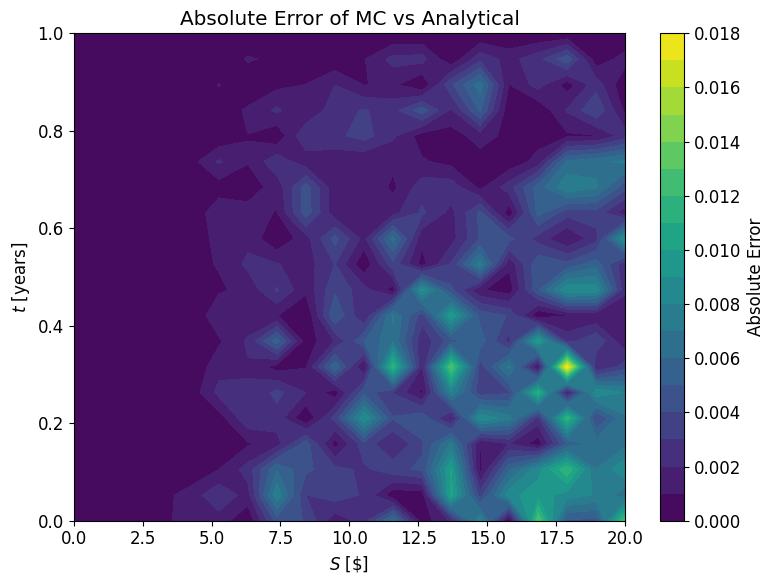

In [ ]:
"""
Plots the absolute error between MC and analytical solutions of the 1D BS equation.
"""
# Build the asset and time grids
S_max = 20
N_S = 20
S1 = np.linspace(0.0, S_max, N_S)
t_array = np.linspace(0.0, 1, 20)

# Parameters for the 1D call option
K = 5
r = 0.05
sigma1 = np.array([0.3])
weights1 = np.array([1])
rho1 = np.array([])  # No correlation in 1D
n_simulations = 400_000  # Number of Monte Carlo simulations
T = 1.0





#Create mesh for asset prices and time
S_mesh, t_mesh = np.meshgrid(S1, t_array, indexing="xy")

#Compute Monte Carlo prices
prices_1d = price_european_call_on_grid(
    n_simulations, S_mesh[..., None], t_mesh, K, r,
    sigma1, weights1, rho1, T
)

#Compute analytical Black-Scholes prices
analytical = analytical_solution(S_mesh, K, T, t_mesh, r, sigma1)

#Compute absolute error
abs_err = np.abs(prices_1d - analytical)

#Plot absolute error
fig, ax = plt.subplots(figsize=(8, 6))
cf = ax.contourf(S_mesh, t_mesh, abs_err, levels=20, cmap="viridis")
ax.set_title("Absolute Error of MC vs Analytical")
ax.set_xlabel(r"$S$ [\$]")
ax.set_ylabel(r"$t$ [years]")
_ = fig.colorbar(cf, ax=ax, label="Absolute Error")
plt.tight_layout()
plt.show()


With $400k$ simulations on a $20 \times 20$ grid we obtain a maximum absolute error of 0.023 (you may get different results, but the error should be in approximately the same order). If you want an even more accurate simulation you can run with more simulations. 
Now its time to compare it to the model solver for the 2-dimensional Black-Scholes equation. Since we have already trained a PINN model the remaning thing is to perform a Monte Carlo simulation for two underlying assets. 

In [ ]:
S1 = np.linspace(0, 20, 17)
S2 = np.linspace(0, 20, 17)
S_list = [S1, S2]
t_array = np.linspace(0, 1.0, 5)
K = 5.0
r = 0.05
sigma = np.array([0.2, 0.2])
weights = np.array([0.5, 0.5]) #weight both assets equally 
rho_vec = np.array([0]) #no correlation
n_simulations = 600_000


# Build mesh for the assets
mesh = np.meshgrid(*S_list, indexing='ij')

# Stack to get Sg of shape (..., N)
Sg = np.stack(mesh, axis=-1)

# Call price_european_call_on_grid, collect the 2D result, and stack them into shape
grid_shape = tuple(len(S) for S in S_list) 
N_times = len(t_array)

# Pre-allocate a container for prices
all_prices = np.zeros((N_times,) + grid_shape)

# Loop over each time t
for idx, t in enumerate(t_array):
    # Build a full t-grid 
    t_grid = np.full(grid_shape, t)  # shape = (15, 15)

    # Call the Monte Carlo pricer at this single time t_grid:
    price_2d = price_european_call_on_grid(
        n_simulations = n_simulations,
        S_grid        = Sg,        
        t_array       = t_grid,   
        K             = K,
        r             = r,
        sigma         = sigma,
        weights       = weights,
        rho_vec       = rho_vec,
        T             = 1.0        
    )
    # Store prices
    all_prices[idx] = price_2d

print(all_prices.shape)  # Should be (N_times, 17, 17)






(5, 17, 17)


Now we plot the predictions of our model against the Monte Carlo simulation. We plot for $5$ different time slices. In the method ready_input_PINN we construct input data to the model from the mehsgrid used for Monte Carlo simulations. 

In [ ]:

name = "Best Model"

def ready_input_PINN(S1_mesh, S2_mesh, t_mesh):
    """
    Function that takes in meshes and returns torch tensor for model input
    
    """
    coords = np.column_stack((
        S1_mesh.ravel(),   # shape (Nt*NS1*NS2,)
        S2_mesh.ravel(),
        t_mesh.ravel()
    ))

    #turn into a torch tensor on the right device
    input_tensor = torch.tensor(
        coords,
        dtype=torch.float32,
        device=device
    )  # shape (Npoints, 3)

    # split back into individual columns
    S1_col = input_tensor[:, 0:1]   # shape (Npoints,1)
    S2_col = input_tensor[:, 1:2]
    t_col  = input_tensor[:, 2:3]

    # normalize each to [–1, +1]:
    #    spatial dims: S / S_max  → [0,1] → *2–1  → [–1,1]
    x1_norm = 2.0 * (S1_col / S_max_list[0]) - 1.0
    x2_norm = 2.0 * (S2_col / S_max_list[1]) - 1.0

  
    tau_non_d = (T - t_col) / T
    tau_norm  = 2.0 * tau_non_d - 1.0

    # re-concatenate into your final input
    input_norm = torch.cat([x1_norm, x2_norm, tau_norm], dim=1)
    # shape (Nt*NS1*NS2, 3)
    return input_norm

T=1  # Terminal time
S1 = np.linspace(0, 20, 17) 
S2 = np.linspace(0, 20, 17)

# Build mesh:
S1g, S2g = np.meshgrid(S1, S2, indexing='ij')
S_max_list=[20, 20]


t_array=np.linspace(0, T, 5)
tg, s1g, s2g = np.meshgrid(t_array, S1, S2,indexing='ij') 


input_norm = ready_input_PINN(s1g, s2g, tg)
#PINN solution
with torch.no_grad():
    C_PINN_flat = model_multi(input_norm)

#Reshaping to corrrect shape for absolute error calculation
PINN_prediction = C_PINN_flat.reshape(tg.shape)

#Calculate absolute error between PINN prediction and prices
abs_error=np.abs(PINN_prediction - price_2d)

all_min = min(price_2d.min(), PINN_prediction.min())
all_max = max(price_2d.max(), PINN_prediction.max())

/var/folders/1n/kcxtjkk14hnb_vt5xqdg7zwr0000gn/T/ipykernel_2138/3248495166.py:62: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  abs_error=np.abs(PINN_prediction - price_2d)


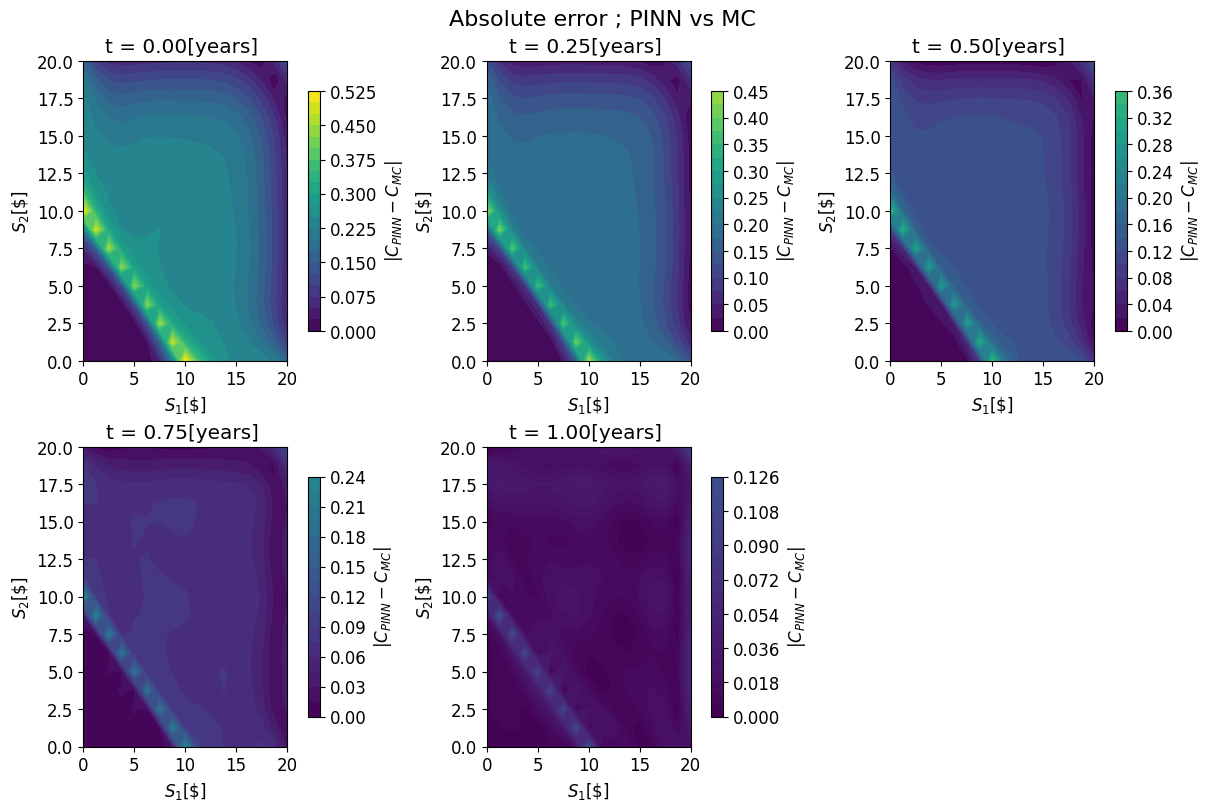

In [ ]:

import matplotlib.colors as mcolors

"""
Plotting subplots of absolute error between MC prediction and PINN prediction,
for five different time slices

"""

nrows, ncols = 2, 3  

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols,
    figsize=(4 * ncols, 4 * nrows),
    constrained_layout=True
)
axes_flat = axes.ravel()

# Compute a single color‐range for all panels
vmin = np.nanmin(abs_error)
vmax = np.nanmax(abs_error)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
time_slices = [0, 0.25, 0.5, 0.75, 1.0] #Defining times for subplots [years]
# Plot into the first 5 axes
for ax, t_val in zip(axes_flat[: len(time_slices) ], time_slices):
    # find the time index closest to t_val
    idx = np.argmin(np.abs(tg[:, 0, 0] - t_val))

    cf = ax.contourf(
        s1g[idx], s2g[idx], abs_error[idx],
        levels=20,
        cmap='viridis',
        norm=norm
    )
    ax.set_title(f't = {t_array[idx]:.2f}[years] ')
    ax.set_xlabel(r'$S_1$[\$]')
    ax.set_ylabel(r'$S_2$[\$]')

    # add a colorbar to each subplot
    cbar = fig.colorbar(
        cf, ax=ax, shrink=0.8, orientation='vertical'
    )
    cbar.set_label(r'$|C_{PINN} - C_{MC}|$')

# hide 6th plot
axes_flat[5].axis('off')

# define title and save figure
fig.suptitle("Absolute error ; PINN vs MC ", fontsize=16)
plt.show()



We here see that the model performs relatively well at time t=1, which corresponds to the terminal condition, but struggles as time goes on (backwards). The errors seem to accumulate through time. In the bottom left corners of the plot there is a distinct trinagle shaped area with better performance. This may be because the price of the option is zero here, and the model easily predicts this value. There is an abrupt jump to the line of higher error. This is in the area where $S=K$. We know that the terminal condition has a kink here, so this may come from that. Interestingly, in the one dimensional case the error decreased as time decreased, but here the error from the terminal condition is smaller at $t=1$ and increases as time decreases. 
The Neumann boundary condition seem to work well as the model performs well for large asset prices. Though, it struggles with the transition from satisfying the PDE to satisfying the right boundaries. 

For further research you can find the optimal hyperparameters to see if that increases performance. Feel free to play around with the code at will. Ideally perform grid searches of the hyperparameters more thorougly in the one dimensional case, and the two dimensional case. 

You can also train a model on two assets and use this for predicting target values for the left boundaries for a model on three assets. 





#### Summary 

**Higher dimensional simulations** 
You can now implement this code in higher dimensions as well to see how the model performs there, just remember to use a model trained in one dimension less for the left boundary! 




This file is meant to be used for hints and tips, and perhaps as a source of inspiration, regarding how to do a project in a machine learning course. 
In your actual report you must generally avoid using informal language as has been done here on multiple occasions. 
You must also run with more epochs, and generally a more exhaustive hyperparameter grid search. The different experiments conducted in this project can be of help so that you see what hyperparameters should actually be optimized. 
The comparison between different models (here we compared a traditional neural network and the PINN model) may also be of great interesert in your project as it is useful to see if this relatively new approach (PINNs) actually works better than traditional ones. 

In you report you also need to analyze and discuss the results more thoroughly. In addition, you should implement a clearer and more concise description of the theory and methods used (this will be well explained in the course material and on the course website). It also goes without saying that citations and references should be done per the standards of scientific reports when you write your project. 